In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce

import seaborn as sns
from matplotlib import pyplot as plt
import textwrap

from sklearn.model_selection import train_test_split

pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df_completo=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset de entrenamiento.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables y las **probabilidades asociadas** a cada ocupación.   

## Parámetros del modelo

Los parámetros de este modelo son n, el **número máximo de posiciones en el ranking de ocupaciones** que se seleccionan como predictores, y el **umbral de frecuencia mínima**.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

## Entrenamiento, validación y test

En las **etapas iniciales** del proceso de construcción del clasificador se han empleado los datos de la **encuesta completa**. Se ha hecho así porque las primeras etapas son un **análisis descriptivo** del dataset que informa de las frecuencias de títulos y ocupaciones y de la distribución de las de ocupaciones distintas asociadas a cada título. Al aplicar el análisis sobre los datos de la encuesta completa obtenemos información poblacional sobre estas relaciones.   
  
Para las fases de entrenamiento y predicción se ha separado el dataset en tres subconjuntos: **train, validación y test**.    
  
El conjunto de **train** se obtiene como resultado de un **muestreo aleatorio estratificado** que garantiza una presencia de todos los títulos proporcional a la observada en la encuesta. No obstante, se han realizado pruebas sobre un conjunto de train seleccionado aleatoriamente sin estratificación. Los resultados de estas pruebas no difieren dramáticamente de los obtenidos con muestreo estratificado.   
  
Para la selección de los subconjuntos de **validación** y de **test** se ha buscado un **muestreo aleatorio no estratificado** para evitar que la similitud excesiva de las distribuciones de títulos en los tres conjuntos influya en la medición de la capacidad predictiva del clasificador. 

Las **proporciones** del tamaño de la encuesta que representan las observaciones seleccionadas en train, validación y test se fijan en 0.6, 0.2 y 0.2 respectivamente. 

El funcionamiento del algoritmo y el diseño de las métricas de evaluación se han ilustrado empleando las **columnas de título y de ocupacion literales** (strings) en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. No obstante, el diseño del algoritmo permite sutituir las columnas literales por las numéricas para operar de forma más eficiente. También permite establecer otros regresores y targets distintos de los títulos y las ocupaciones. 


## Objetivos del modelo

El principal objetivo de la construcción de un clasificador elemental es **conocer en qué medida las titulaciones universitarias de grado y de máster explican por sí solas las profesiones que alcanzan los titulados**.    
  
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 


- Las encuestas empleadas en este proyecto solo informan con detalle de un **único título universitario de cada encuestado**. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  


- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   

Los resultados del modelo sirven también al objetivo de **identificar las titulaciones que tienen relaciones más estrechas con las ocupaciones** más frecuentes de los titulados y aquellas otras para las cuales la capacidad del título como predicctor de la profesión futura es más pobre. 


## Justificación

**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  

- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  
  
  
- Clasificador **específico** para un modelo con un **único regresor** en el que, además, **el regresor y el target son variables categóricas**.  


- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones (o categorías del regresor) o por ocupaciones (categorías del target). En particular, emplear un único regresor permite obtener mediciones del accuracy desagregadas para cada uno de los títulos observados en el proceso de evaluación. Esto facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas.   
  
  
- **Flexibilidad** para incorporar un número variable de precicciones para cada título a las métricas de accuracy, recall y precisión y para ajustar estas métricas de acuerdo con las probabilidades asignadas a las distintas predicciones.  
   

- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para **estimar la dificultad del problema de clasificación** (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  

## Diseño del clasificador y de las funciones de evaluación 

Todas las funciones que componen las distintas etapas de la construcción del clasificador están diseñadas para operar con la información mínima imprescindible: el dataset y la identificación de las columnas regresor y target. A medida que avanzan los cálculos, cada función llama a la anterior para recuperar sus resultados, a los que añade las transformaciones (o columnas nuevas) que aporta la siguiente etapa de construcción.   

Esta estrategia tiene la desventaja de que requiere que en cada etapa se recalculen todos los cómputos intermedios anteriores. Su principal ventaja es que todas las funciones son autónomas: solo precisan la información mínima sobre el modelo para devolver sus resultados.  

Así, el **proceso de construcción y entrenamiento del clasificador** se resumen en los resultados de una única función, **naive_fit**, que devuelve un clasificador entrenado. 

De forma análoga, el **proceso de predicción** solo requiere como argumentos el clasificador entrenado y el título para el que se desea una predicción. Esto se resume en la función **naive_predice**, que devuelve las predicciones de ocupaciones para el título y sus probabilidades asociadas. 

Por último, las distintas etapas del **proceso de evaluación** solo requieren la identificación del clasificador entrenado y del dataset de evaluación. Las funciones de evaluación difieren entre ellas en el grado de agregación de los resultados y en la métrica de evaluación protagonista en cada caso. Esto se describe con más detalle en el capítulo de evaluación del clasificador. 

# Dataset encuesta 

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df_completo[df_completo['ocupacion'].notna()]
df.shape

(59844, 351)

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

#### Categorías del regresor: 

In [4]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

In [5]:
rank_titulos=pd.DataFrame(df['titulo_ppal_'].value_counts())
rank_titulos.rename(columns={'titulo_ppal_':'núm. de encuestados'},inplace=True)
rank_titulos['proporción']=rank_titulos['núm. de encuestados']/rank_titulos['núm. de encuestados'].sum()
rank_titulos['posición ranking']=rank_titulos['núm. de encuestados'].rank(ascending=False)
rank_titulos.head(20)
# Los 20 títulos con más encuestados: 

,núm. de encuestados,proporción,posición ranking
Grado Administración y empresa,2637,0.044065,1.0
Grado Enfermería,2330,0.038935,2.0
Grado Derecho,2199,0.036746,3.0
Grado Informática,2189,0.036578,4.0
Grado Educación primaria,2065,0.034506,5.0
Grado Educación infantil,1882,0.031448,6.0
Máster Formación de docentes de educación secundaria y formación profesional,1730,0.028908,7.0
Grado Medicina,1433,0.023946,8.0
Grado Psicología,1378,0.023027,9.0
Grado Otros maestros,1262,0.021088,10.0


#### Categorías del target: 

In [6]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

In [7]:
rank_ocupaciones=pd.DataFrame(df['ocupacion_'].value_counts())
rank_ocupaciones.rename(columns={'ocupacion_':'núm. de encuestados'},inplace=True)
rank_ocupaciones['proporción']=rank_ocupaciones['núm. de encuestados']\
                               /rank_ocupaciones['núm. de encuestados'].sum()
rank_ocupaciones['posición ranking']=rank_ocupaciones['núm. de encuestados'].rank(ascending=False)
rank_ocupaciones.head(20)
# Los 20 ocupaciones con más encuestados: 

,núm. de encuestados,proporción,posición ranking
Profesionales de la enseñanza,9809,0.163909,1.0
"Profesionales de las ciencias, matemáticas e ingeniería",7794,0.130239,2.0
Profesionales sanitarios,7568,0.126462,3.0
"Expertos en gestión, finanzas, comercio, etc",2931,0.048977,4.0
"Empleados servicios financieros, contables y de apoyo",2531,0.042293,5.0
Profesionales de las ciencias sociales,2200,0.036762,6.0
Técnicos ciencias e ingenierías,2105,0.035175,7.0
Profesionales IT,1866,0.031181,8.0
Profesionales de la eduación especial y no reglada,1768,0.029543,9.0
Técnicos TI,1662,0.027772,10.0


# 1. Distribución del número de titulados (observaciones) por título

Se explora la distribución del número de encuestados (o titulados) para cada título,  

In [8]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    """ Cuenta el número de observaciones para cada categoría del regresor. 
    """
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    return out

In [9]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor
0,Grado Actividad física y del deporte,966
1,Grado Administración y empresa,2637
2,Grado Antropología social y cultural y Estudios y gestión de la cultura,281
3,Grado Arqueología,34
4,Grado Arquitectura técnica,1050


In [10]:
num_titulados_encuesta.tail()

,titulo_ppal_,obs regresor
168,Máster Técnicas audiovisuales y medios de comunicación,96
169,"Máster Vehículos de motor, barcos y aeronaves",63
170,Máster Ventas al por mayor y al por menor,54
171,Máster Veterinaria,50
172,"Máster Viajes, turismo y ocio",69


## 1.1. Número de titulados por título: resumen 

In [11]:
# Distribución del número de encuestados (o titulados) por titulo: resumen
encuestados_tt=pd.DataFrame(num_titulados_encuesta['obs regresor'].describe())
encuestados_tt.rename(columns={'obs regresor':'Distribución núm. de encuestados por título'},inplace=True)
encuestados_tt

,Distribución núm. de encuestados por título
count,173.000000
mean,345.919075
std,477.144211
min,23.000000
25%,90.000000
50%,154.000000
75%,355.000000
max,2637.000000


# 2. Distribución del número de ocupaciones distintas por título

Se explora la relación entre el número de encuestados y el número de ocupaciones distintas por título, rama de conocimiento y familia de estudios. 

In [12]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    
    """ Cuenta el número de titulados y el número de categorías distintas del target para cada categoría del 
    regresor.
    """
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target para regresor'},inplace=True)
    out.reset_index(inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target para regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [13]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta.head(10)

,titulo_ppal_,obs regresor,num categorias target para regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10
5,Grado Medicina,1433,10
6,Máster Veterinaria,50,10
7,Grado Protocolo y eventos,23,11
8,Máster Estadística,53,11
9,Máster Enfermería,155,11


In [14]:
num_oc_por_titulo_encuesta.tail(10)

,titulo_ppal_,obs regresor,num categorias target para regresor
163,"Grado Ingeniería agrícola, agropecuaria y medio rural",606,50
164,Grado Actividad física y del deporte,966,50
165,Grado Trabajo social,1247,51
166,Grado Educación infantil,1882,52
167,Grado Ciencias ambientales,682,52
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53
172,Grado Administración y empresa,2637,54


## 2.1. Número de ocupaciones distintas por título: resumen 

In [15]:
# Distribución del número de ocupaciones por título: resumen
ocupaciones_tt=pd.DataFrame(num_oc_por_titulo_encuesta['num categorias target para regresor'].describe())
ocupaciones_tt.rename(columns={'num categorias target para regresor':
                               'Distribución núm. de ocupaciones distintas por título'},inplace=True)
ocupaciones_tt

,Distribución núm. de ocupaciones distintas por título
count,173.000000
mean,27.705202
std,12.290563
min,5.000000
25%,19.000000
50%,26.000000
75%,35.000000
max,54.000000


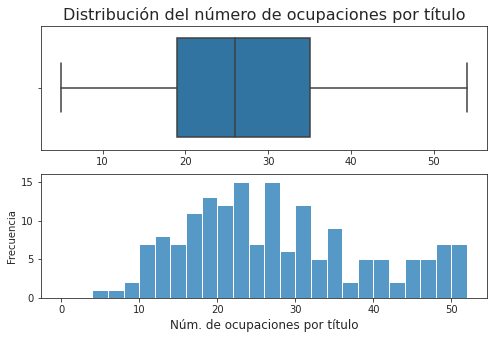

In [16]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(2, 1,figsize=(8,5))
font_titles=16
font_labels=12

sns.boxplot(ax=ax1,data=num_oc_por_titulo_encuesta,
            x='num categorias target para regresor')
ax1.set_title('Distribución del número de ocupaciones por título',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

max_num_oc=num_oc_por_titulo_encuesta['num categorias target para regresor'].max()

sns.histplot(ax=ax2,data=num_oc_por_titulo_encuesta,
             x='num categorias target para regresor',
             bins=np.arange(0,max_num_oc,2))

ax2.set_xlabel('Núm. de ocupaciones por título',fontsize=font_labels)
ax2.set_ylabel('Frecuencia',fontsize=font_labels-2)
ax2.set_ylim(0,16)

fig.subplots_adjust(hspace=.2)
plt.show()

### Observaciones: 

- La mitad de los títulos están asociados a un número de ocupaciones distintas comprendido entre 19 y 35. 
- El número máximo de ocupaciones distintas a asociadas a un título son 52 (de 62 ocupaciones observadas en el dataset)

## 2.2. Número de ocupaciones distintas por rama de conocimento

Exploración de la distribución del número de ocupaciones distintas para cada título para los títulos agregados por ramas de conocimiento.

In [17]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título:
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas.head()

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas
4007,Grado Educación social,Ciencias sociales y jurídicas


In [18]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')

# Auxiliar para orden de acuerdo con mediana y mínimo de núm. categorías target para regresor para boxplot:
aux_ordena=num_oc_por_titulo_ramas[['rama_ppal_','num categorias target para regresor']]\
                    .groupby('rama_ppal_').agg(['median','min'])
aux_ordena.columns=aux_ordena.columns.to_flat_index()
aux_ordena.rename(columns=({aux_ordena.columns[-2]:'mediana'}),inplace=True)
aux_ordena.rename(columns=({aux_ordena.columns[-1]:'min'}),inplace=True)

num_oc_por_titulo_ramas=num_oc_por_titulo_ramas.merge(aux_ordena,on='rama_ppal_',how='left')
num_oc_por_titulo_ramas.sort_values(by=['mediana','min'],inplace=True)
num_oc_por_titulo_ramas.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,rama_ppal_,mediana,min
0,Grado Odontología,243,5,Ciencias de la salud,19,5
1,Máster Odontología,73,6,Ciencias de la salud,19,5
5,Grado Medicina,1433,10,Ciencias de la salud,19,5
6,Máster Veterinaria,50,10,Ciencias de la salud,19,5
9,Máster Enfermería,155,11,Ciencias de la salud,19,5


In [19]:
# Se añade núm. de observaciones (encuestados) por rama de conocimiento: 
obs_por_rama=num_oc_por_titulo_ramas[['obs regresor','rama_ppal_']].groupby('rama_ppal_').sum()
obs_por_rama.rename(columns={'obs regresor':'obs por rama'},inplace=True)
obs_por_rama

,obs por rama
rama_ppal_,
Artes y humanidades,4777
Ciencias,4967
Ciencias de la salud,7903
Ciencias sociales y jurídicas,26015
Ingeniería y arquitectura,13313
Servicios,2869


In [20]:
# Se añade núm. de observaciones (encuestados) por rama de conocimiento (continuación): 
num_oc_por_titulo_ramas=num_oc_por_titulo_ramas.merge(obs_por_rama,on='rama_ppal_',how='left')
num_oc_por_titulo_ramas.sort_values(by=['mediana','min'],inplace=True)
num_oc_por_titulo_ramas.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,rama_ppal_,mediana,min,obs por rama
0,Grado Odontología,243,5,Ciencias de la salud,19,5,7903
1,Máster Odontología,73,6,Ciencias de la salud,19,5,7903
2,Grado Medicina,1433,10,Ciencias de la salud,19,5,7903
3,Máster Veterinaria,50,10,Ciencias de la salud,19,5,7903
4,Máster Enfermería,155,11,Ciencias de la salud,19,5,7903


In [21]:
# Info auxiliar para representar núm. de ocupaciones por ramas en boxplot: 
info_aux=list()
for i,rama in enumerate(num_oc_por_titulo_ramas['rama_ppal_'].unique()):
    mediana_rama=num_oc_por_titulo_ramas['mediana'][num_oc_por_titulo_ramas['rama_ppal_']==rama].unique()[0]
    obs_rama=num_oc_por_titulo_ramas['obs por rama'][num_oc_por_titulo_ramas['rama_ppal_']==rama].unique()[0]
    info_aux.append((i,mediana_rama,obs_rama))
info_aux

[(0, 19, 7903),
 (1, 22, 4777),
 (2, 23, 4967),
 (3, 25, 2869),
 (4, 26, 13313),
 (5, 31, 26015)]

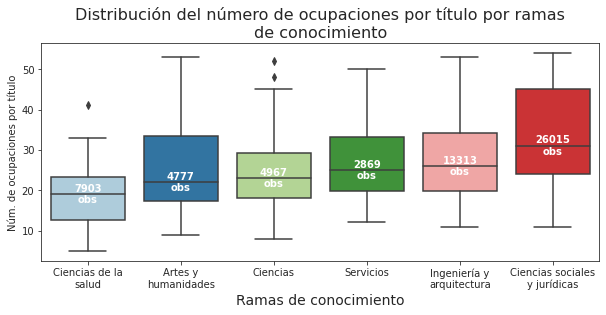

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(10,4))
font_titles=16
font_labels=14

ax = sns.boxplot(data=num_oc_por_titulo_ramas, 
                 x='rama_ppal_',
                 y='num categorias target para regresor',
                 palette='Paired')

titulo='Distribución del número de ocupaciones por título por ramas de conocimiento'
ax.set_title(textwrap.fill(titulo,60), fontsize=font_titles)
ax.set_xlabel('Ramas de conocimiento',fontsize=font_labels)
ax.set_ylabel('Núm. de ocupaciones por título')
ax.set_xticklabels(textwrap.fill(tick.get_text(),18) for tick in ax.get_xticklabels())
for rama in info_aux:
    ax.text(x=rama[0],y=rama[1],s=str(rama[2])+'\nobs',ha='center',va='center',color='w',weight='bold')

plt.show()

### Observaciones:
 
La rama de conocimiento con menor número de ocupaciones distintas es la de Ciencias de la Salud. En el extremo opuesto, los títulos que con más frecuencia están entre los que tienen más ocupaciones distintas con los de la rama de Ciencias sociales y jurídicas. 

## 2.3. Número de ocupaciones distintas por familia de estudios

Exploración del número de ocupaciones distintas por título para los títulos agregados por familias de estudios. 

In [23]:
# df auxiliar para añadir familias de estudios a la distribución de número de ocupaciones por título:
df_familias=df[['titulo_ppal_','familia_ppal_']].drop_duplicates()
df_familias.head()

,titulo_ppal_,familia_ppal_
0,Grado Pedagogía,Educación
568,Grado Educación infantil,Educación
1933,Grado Educación primaria,Educación
3840,Grado Otros maestros,Educación
4007,Grado Educación social,Educación


In [24]:
# df auxiliar para añadir familias de estudios a la distribución de número de ocupaciones por título:
num_oc_por_titulo_familias=num_oc_por_titulo_encuesta.merge(df_familias,on='titulo_ppal_',how='left')

# Auxiliar para orden de acuerdo con mediana de núm. categorías target para regresor en boxplot:
aux_ordena=num_oc_por_titulo_familias[['familia_ppal_','num categorias target para regresor']]\
                    .groupby('familia_ppal_').agg(['median'])
aux_ordena.columns=aux_ordena.columns.to_flat_index()
aux_ordena.rename(columns=({aux_ordena.columns[-1]:'mediana'}),inplace=True)

num_oc_por_titulo_familias=num_oc_por_titulo_familias.merge(aux_ordena,on='familia_ppal_',how='left')
num_oc_por_titulo_familias.sort_values(by='mediana',inplace=True)
num_oc_por_titulo_familias.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,familia_ppal_,mediana
162,Grado Informática,2189,50,Informática,16.0
31,Máster Diseño y administración de bases de datos y redes,60,16,Informática,16.0
32,Máster Tecnologías de la información y las comunicaciones (Otros estudios),126,16,Informática,16.0
11,Grado Desarrollo de software y de aplicaciones e Ingeniería multimedia,68,12,Informática,16.0
60,Máster Desarrollo y análisis de aplicaciones y de software,174,21,Informática,16.0


In [25]:
# Se añade núm. de observaciones (encuestados) por familia de estudios: 
obs_por_familia=num_oc_por_titulo_familias[['obs regresor','familia_ppal_']].groupby('familia_ppal_').sum()
obs_por_familia.rename(columns={'obs regresor':'obs por familia'},inplace=True)
obs_por_familia

,obs por familia
familia_ppal_,
"Agricultura, ganadería, silvicultura, pesca y veterinaria",2319
Artes y humanidades,5624
Ciencias,4927
"Ciencias sociales, periodismo y documentación",5761
Educación,8590
Informática,2617
"Ingeniería, industria y construcción",9142
"Negocios, administración y derecho",8846
Salud y servicios sociales,8648


In [26]:
# Se añade núm. de observaciones (encuestados) por familia de estudios (continuación): 
num_oc_por_titulo_familias=num_oc_por_titulo_familias.merge(obs_por_familia,on='familia_ppal_',how='left')
num_oc_por_titulo_familias.sort_values(by=['mediana'],inplace=True)
num_oc_por_titulo_familias.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,familia_ppal_,mediana,obs por familia
0,Grado Informática,2189,50,Informática,16.0,2617
1,Máster Diseño y administración de bases de datos y redes,60,16,Informática,16.0,2617
2,Máster Tecnologías de la información y las comunicaciones (Otros estudios),126,16,Informática,16.0,2617
3,Grado Desarrollo de software y de aplicaciones e Ingeniería multimedia,68,12,Informática,16.0,2617
4,Máster Desarrollo y análisis de aplicaciones y de software,174,21,Informática,16.0,2617


In [27]:
# Info auxiliar para representar núm. de ocupaciones por familias en boxplot: 
info_aux=list()
for i,familia in enumerate(num_oc_por_titulo_familias['familia_ppal_'].unique()):
    mediana_familia=num_oc_por_titulo_familias['mediana']\
                        [num_oc_por_titulo_familias['familia_ppal_']==familia].unique()[0]
    obs_familia=num_oc_por_titulo_familias['obs por familia']\
                        [num_oc_por_titulo_familias['familia_ppal_']==familia].unique()[0]
    info_aux.append((i,mediana_familia,obs_familia))
info_aux

[(0, 16.0, 2617),
 (1, 20.0, 8648),
 (2, 22.5, 5624),
 (3, 24.0, 4927),
 (4, 26.0, 9142),
 (5, 27.0, 8846),
 (6, 28.0, 3370),
 (7, 28.0, 2319),
 (8, 29.5, 5761),
 (9, 44.0, 8590)]

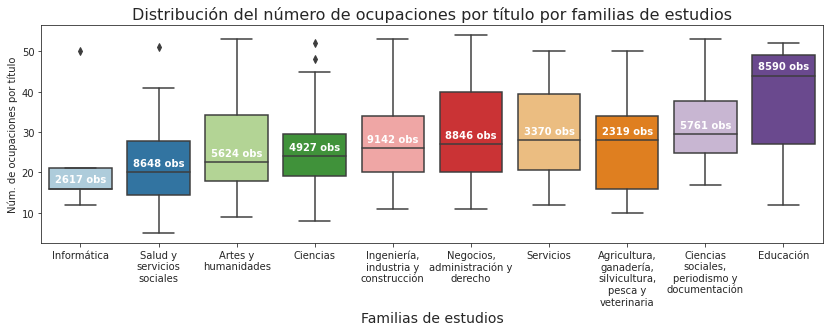

In [28]:
fig, ax = plt.subplots(1, 1,figsize=(14,4))
font_titles=16
font_labels=14

data=num_oc_por_titulo_familias
ax = sns.boxplot(data=data, 
                 x='familia_ppal_',\
                 y='num categorias target para regresor',
                 palette='Paired')

ax.set_title('Distribución del número de ocupaciones por título por familias de estudios',fontsize=font_titles)
ax.set_ylabel('Núm. de ocupaciones por título')
ax.set_xlabel('Familias de estudios',fontsize=font_labels)
ax.set_xticklabels(textwrap.fill(tick.get_text(),16) for tick in ax.get_xticklabels())
for familia in info_aux:
    ax.text(x=familia[0],y=familia[1]+1,s=str(familia[2])+' obs',ha='center',va='bottom',color='w',weight='bold')

plt.show()

### Observaciones: 

- De nuevo, los títulos de la familia de Salud y servicios sociales están entre los que con más frecuencia tienen un menor número de ocupaciones distintas por título.  


- En el otro extremo, la familia cuyos títulos tienen más ocupaciones distintas con mayor frecuencia es la de Educación (en concordancia con las conclusiones anteriores para la rama de conocimientos de Ciencias sociales y jurídicas).   


- El caso de la familia de estudios de Informática requiere un análisis más pormenorizado: en esta familia solo hay un título, el grado en Informática, con un número de ocupaciones distintas muy superior a su mediana, lo que lo situa como un valor atípico en el gráfico de cajas y bigotes de su familia de estudios. El grado en Informática es, también, el único título de su familia que tiene más de 500 encuestados, lo que sugiere que existe una relación entre el número de encuestados y el número de ocupaciones distintas que queda difuminada en los análisis agregados por ramas o familias.  

Los análisis agregados por ramas o familias no permiten concluir si existe relación entre el número de encuestados y el número de ocupaciones. Más adelante se explora esta relación con más detalle. 

## 2.2. Número de titulados y número de ocupaciones por título

In [29]:
# df auxiliar: se añaden columnas para la rama de conocimiento y para la familia de estudios de cada título: 
num_oc_por_titulo_encuesta=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_oc_por_titulo_encuesta=num_oc_por_titulo_encuesta.merge(df_familias,on=['titulo_ppal_'],how='left')
num_oc_por_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,rama_ppal_,familia_ppal_
0,Grado Odontología,243,5,Ciencias de la salud,Salud y servicios sociales
1,Máster Odontología,73,6,Ciencias de la salud,Salud y servicios sociales
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Ciencias,Ciencias
3,Máster Religión y teología,25,9,Artes y humanidades,Artes y humanidades
4,Máster Lenguas (Otros estudios),53,10,Artes y humanidades,Artes y humanidades


In [30]:
# Columna auxiliar para ordenar boxplot por mediana y mínimo del número de ocupaciones distintas: 
num_oc_por_titulo_encuesta.rename(columns={'num categorias target para regresor':'num cat'},inplace=True)
aux_mediana_cat=num_oc_por_titulo_encuesta[['rama_ppal_','num cat']].groupby('rama_ppal_').agg(['median'])
aux_mediana_cat.columns=aux_mediana_cat.columns.to_flat_index()
aux_mediana_cat.rename(columns={aux_mediana_cat.columns[-1]:'mediana cat'},inplace=True)
aux_mediana_cat.sort_values(by='mediana cat')

num_oc_por_titulo_encuesta=num_oc_por_titulo_encuesta.merge(aux_mediana_cat,on='rama_ppal_',how='left')

num_oc_por_titulo_encuesta.sort_values(by='mediana cat',inplace=True)
#num_titulados_encuesta

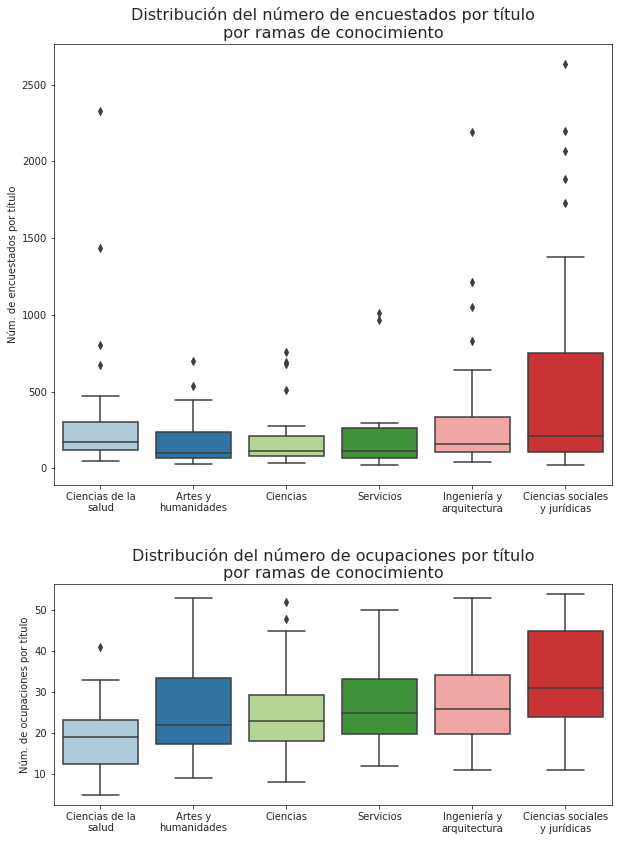

In [31]:
from matplotlib import gridspec

fig= plt.figure(figsize=(10, 14)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2]) 

cols=['obs regresor','num cat']

for i,col in enumerate(cols):

    ax=plt.subplot(gs[i])
    sns.boxplot(data=num_oc_por_titulo_encuesta, 
                     x='rama_ppal_',
                     y=col,
                     palette='Paired')

    titulos=['Distribución del número de encuestados por título por ramas de conocimiento',
             'Distribución del número de ocupaciones por título por ramas de conocimiento']
    y_labels=['Núm. de encuestados por título', 'Núm. de ocupaciones por título']
    ax.set_title(textwrap.fill(titulos[i],50), fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel(y_labels[i])
    ax.set_xticklabels(textwrap.fill(tick.get_text(),18) for tick in ax.get_xticklabels())

fig.subplots_adjust(hspace=0.3)
plt.show()

### Observación: 

El número de ocupaciones distintas observadas para cada título crece cuando aumenta el número de encuestados para ese título: cuando aumenta el número de personas consultadas, el número de respuestas distintas solo puede aumentar o mantenerse igual. Lo que hace interesante el análisis de esta relación es que no es lineal. Por un lado, aumentar el número de encuestados no aumenta proporcionalmente el número de respuestas diferentes. Es de esperar que el número de respuestas distintas crezca más despacio cuanto mayor sea el número acumulado de encuestados. Por otro lado, la proporción de ocupaciones distintas por numero de encuestados es diferente para distintos títulos. Los títulos para los que la variabilidad de ocupaciones crezca más despacio con el número de encuestados serán aquellos para los que resulte más probable hacer predicciones acertadas. 

En este análisis se estudia la intensidad de la relación entre encuestados y ocupaciones distintas por ramas de conocimiento. La relación en términos agregados es menos clara que título a título. El objetivo del análisis es identificar los grupos de títulos con mayor número de encuestados y los grupos con mayor variabilidad en sus ocupaciones asociadas. Esto permitirá adelantar para qué ramas de conocimiento será más y menos fácil acertar en las predicciones. 

Los gráficos de cajas y bigotes del número de titulados y el número de ocupaciones para cada título agrupados por ramas de conocimiento muestra la relación directa entre encuestados y ocupaciones observadas excepto para la rama de Ciencias de la salud. Para el resto de ramas se observa que la mediana del número de ocupaciones crece con la mediana del número de encuestados. También se aprecia que esta relación no tiene la misma intensidad para todas las ramas de conocimiento.  

Para explorar esta relación con más detalle, a continuación se representan gráficamente el número de encuestados y de ocupaciones para cada título. En la representación gráfica los resultados se agrupan los títulos por familias de estudios para facilitar la inspección visual. 

In [32]:
# Columnas auxiliares para plot por familias de estudios: 
aux_dumm_familias=pd.get_dummies(data=num_oc_por_titulo_encuesta,columns=['familia_ppal_'],
                                 prefix='Familia',prefix_sep=' ')
#aux_dumm_familias.head()

In [33]:
# Títulos abreviados:
D_titulos_abreviados={'Máster Formación de docentes de educación secundaria y formación profesional':
                     'Máster Formación docentes ES y FP'}
aux_dumm_familias['titulo_ppal_'].replace(D_titulos_abreviados,inplace=True)
#aux_dumm_familias

In [34]:
# Coordenadas de títulos con más de un número mínimo de encuestados min_obs: 
lista_familias=num_oc_por_titulo_encuesta['familia_ppal_'].unique().tolist()

min_obs=500 

puntos=list()
for familia in lista_familias:
    aux_tts=aux_dumm_familias[aux_dumm_familias['Familia '+familia]==1]
    aux_tts=aux_tts[aux_tts['obs regresor']>min_obs]
    puntos.append(list(zip(aux_tts['obs regresor'],aux_tts['num cat'],aux_tts['titulo_ppal_'])))  
#puntos

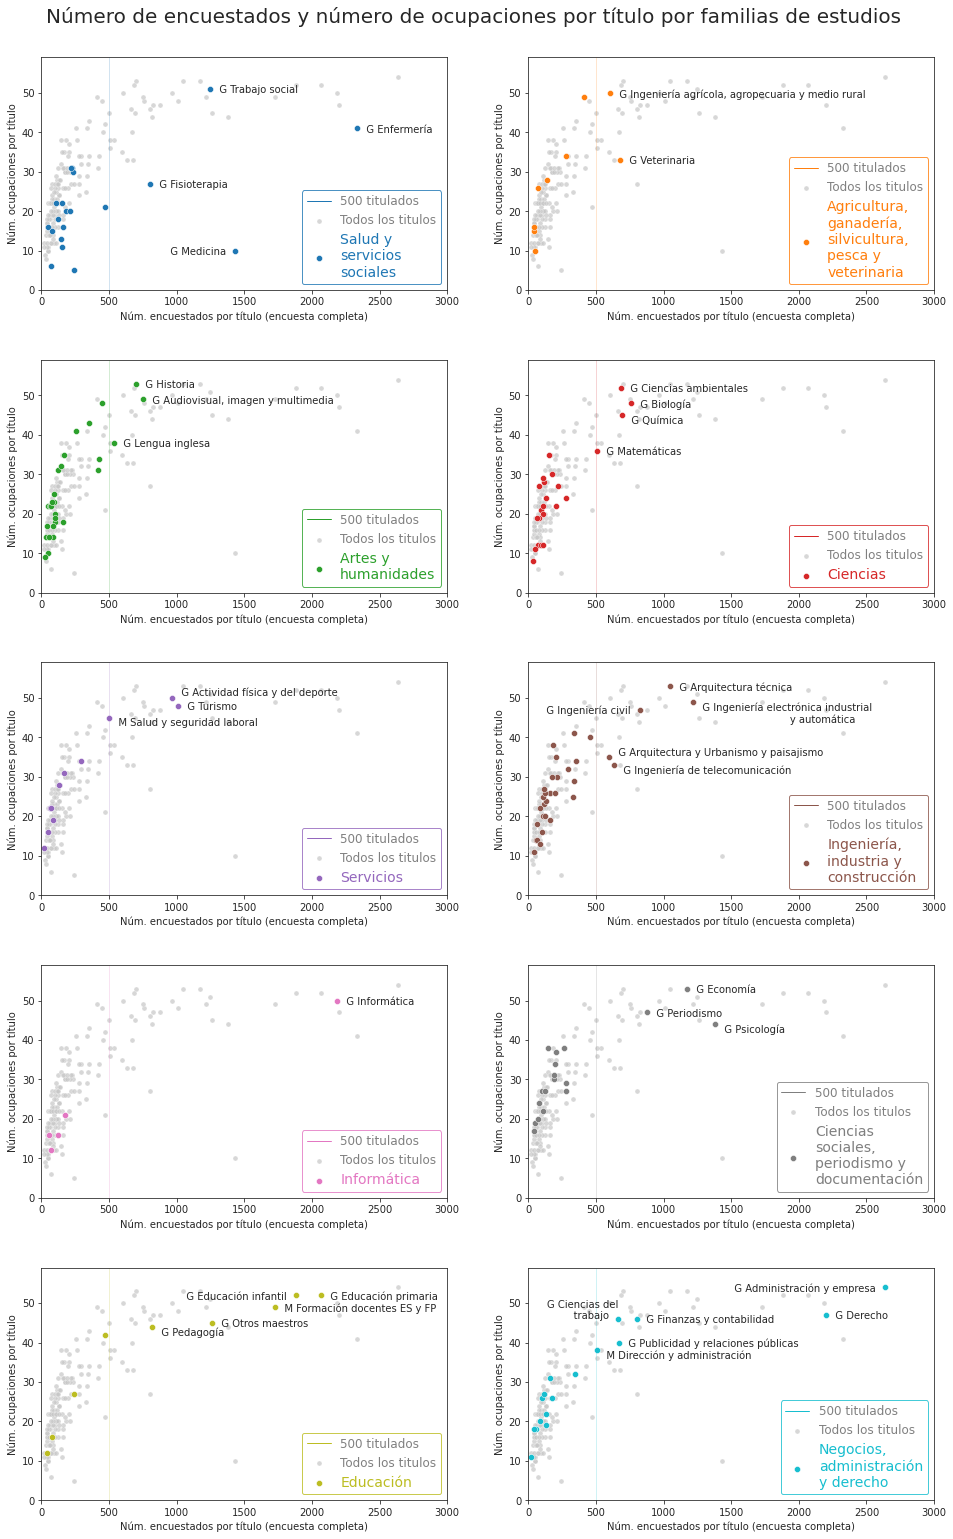

In [35]:
sns.set_style('ticks')

paleta=sns.color_palette('tab20')

criterio='familia_ppal_'

fig, axes = plt.subplots(5, 2,figsize=(16,24))
font_titles=20
font_labels=10

titulo_1='Número de encuestados y número de ocupaciones por título por familias de estudios'
fig.suptitle(titulo_1,fontsize=font_titles,va='baseline')

for i,clase in enumerate(num_oc_por_titulo_encuesta[criterio].unique()):
    
    dummy='Familia '+clase
    data=aux_dumm_familias[['obs regresor','num cat',dummy]]
    
    # Coordenadas de cada gráfico en axes: 
    a1=i//2 
    a2=i%2 

    sns.scatterplot(ax=axes[a1,a2],data=data,
                x='obs regresor',
                y='num cat',
                color=paleta.as_hex()[15],alpha=0.7,s=25) # todos los títulos
    
    sns.scatterplot(ax=axes[a1,a2],data=data[data[dummy]==1],
                x='obs regresor',
                y='num cat',
                color=paleta.as_hex()[i*2],s=37) # familia
    
    sns.lineplot(ax=axes[a1,a2],
                x=np.array([min_obs]*2),
                y=np.array([0,59]),
                color=paleta.as_hex()[i*2], linewidth=1) # recta x=min_obs
    
    # Titulos con más de 500 encuestados: 
    for tt in puntos[lista_familias.index(clase)]: 
        texto='   '+tt[2].split(' ',1)[0][0]+' '+tt[2].split(' ',1)[1]
        # Ajustes posición: 
        if tt[2] in ['Grado Medicina','Grado Administración y empresa','Grado Ingeniería civil',
                     'Grado Educación infantil'] :
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='center_baseline',ha='right')
        elif tt[2] in ['Grado Química','Grado Pedagogía','Máster Salud y seguridad laboral',
                      'Grado Ingeniería de telecomunicación','Grado Psicología',
                       'Máster Dirección y administración']:
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='top')    
        elif tt[2] in ['Grado Actividad física y del deporte','Grado Arquitectura y Urbanismo y paisajismo']:
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='bottom')
        elif tt[2]=='Grado Ingeniería electrónica industrial y automática':
            texto='   G Ingeniería electrónica industrial\n                               y automática'
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='top')
        elif tt[2]=='Grado Ciencias del trabajo':
            texto='G Ciencias del\n     trabajo   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,ha='right')
        else:
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='center_baseline')
    
    axes[a1,a2].set_xlabel('Núm. encuestados por título (encuesta completa)',fontsize=font_labels)
    axes[a1,a2].set_ylabel('Núm. ocupaciones por título',fontsize=font_labels)
    axes[a1,a2].set_xlim(0,3000)
    axes[a1,a2].set_ylim(0,59)
    
    leyenda=axes[a1,a2].legend([str(min_obs)+' titulados','Todos los titulos',textwrap.fill(clase,15)],
                               loc='lower right',fontsize='large',edgecolor=paleta.as_hex()[i*2])
    for color,text in zip(['grey','grey',paleta.as_hex()[i*2]],leyenda.get_texts()):
        text.set_color(color)
    for size,text in zip([12,12,14],leyenda.get_texts()):
        text.set_size(size)
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(top=0.96)
plt.show()

### Observaciones: 

- Se constata una **relación directa entre el número de encuestados (o titulados) y el número de ocupaciones distintas observadas para cada titulo**.  
    
    
- Esta relación es **más intensa cuanto menor es el número de encuestados**: para los títulos con solo unos pocos cientos de encuestados, el número de categorías observadas es casi proporcional al número de titulados consultados. Sin embargo, cuando el número de encuestados es suficientemente alto, el número de ocupaciones se estabiliza. En otras palabras, llega un momento en el que no por preguntar a más titulados se obtienen más respuestas diferentes sobre sus ocupaciones.   
  
  
- El análisis del **coeficiente de correlación lineal** del número de encuestados y el número de ocupaciones confirma esta conclusión: el coeficiente de correlación ronda el valor 0.7 cuando se calcula para toda la muestra, desciende hasta 0.24 cuando se excluyen las titulaciones con menos de 500 encuestados y se reduce hasta 0.1 cuando solo se tienen en cuenta los títulos con más de 1000 encuestados (véanse los resultados exactos a continuación).  
   
   
- El **grado en Medicina** es una excepción a esta regla: a pesar de tener un número de encuestados muy superior al tercer cuartil, el número de ocupaciones observadas para el título es muy inferior al primer cuartil de la distribución del número de ocupaciones distintas (véanse los valores exactos a continuación). 

In [36]:
# Correlación número de encuestados y núm. de ocupaciones: muestra completa
num_oc_por_titulo_encuesta[['obs regresor', 'num cat']].corr()

,obs regresor,num cat
obs regresor,1.000000,0.695259
num cat,0.695259,1.000000


In [37]:
# Correlación número de encuestados y núm. de ocupaciones: títulos con más de 500 encuestados: 
num_oc_por_titulo_encuesta[['obs regresor', 'num cat']][num_oc_por_titulo_encuesta['obs regresor']>500].corr()

,obs regresor,num cat
obs regresor,1.000000,0.239282
num cat,0.239282,1.000000


In [38]:
# Correlación número de encuestados y núm. de ocupaciones: títulos con más de 1000 encuestados
num_oc_por_titulo_encuesta[['obs regresor', 'num cat']][num_oc_por_titulo_encuesta['obs regresor']>1000].corr()

,obs regresor,num cat
obs regresor,1.000000,0.099846
num cat,0.099846,1.000000


In [39]:
# Exploración grado en Medicina: excepción a la relación directa entre núm. encuestados y núm. de ocupaciones
distribuciones_tt=encuestados_tt.merge(ocupaciones_tt,left_index=True,right_index=True)
medicina_encuestados=int(aux_dumm_familias[aux_dumm_familias['titulo_ppal_']=='Grado Medicina']['obs regresor'])
medicina_ocupaciones=int(aux_dumm_familias[aux_dumm_familias['titulo_ppal_']=='Grado Medicina']['num cat'])
distribuciones_tt.loc['Grado Medicina','Distribución núm. de encuestados por título']=medicina_encuestados
distribuciones_tt['Distribución núm. de ocupaciones distintas por título'].loc['Grado Medicina']\
                 =medicina_ocupaciones
distribuciones_tt

,Distribución núm. de encuestados por título,Distribución núm. de ocupaciones distintas por título
count,173.000000,173.000000
mean,345.919075,27.705202
std,477.144211,12.290563
min,23.000000,5.000000
25%,90.000000,19.000000
50%,154.000000,26.000000
75%,355.000000,35.000000
max,2637.000000,54.000000
Grado Medicina,1433.000000,10.000000


# 3. Número de profesionales por título y ocupación

El clasificador de ocupaciones a partir de los títulos universitarios selecciona como predicción para cada título las ocupaciones más frecuentes de sus titulados. 

A continuación se cuenta, para cada título, el número de profesionales de cada ocupación. Esto permite calcular la frecuencia relativa de cada ocupación para cada título y la frecuencia relativa acumulada asociada a una ordenación decreciente de las frecuencias relativas, también título a título. 

In [40]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    """Cuenta, para cada cagegoría del regresor, el número de observaciones, el número de categorías distintas
    del target y el número de observaciones de cada categoría del target. 
    """
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target para regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [41]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Profesionales sanitarios,237
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Profesionales de la enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1


In [42]:
prof_por_oc_y_titulo_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1


## 3.1. Proporción de profesionales sobre titulados por ocupación y título

Se calculan las frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título. Para calcular las frecuencias acumuladas se ordenan las ocupaciones observadas para cada título por frecuencia relativa en orden descendente. 

In [43]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    """Calcula la frecuencia relativa con la que se observa cada categoría del target asociada a cada categoría 
    del regresor como proporción del número de observaciones de cada combinación de categoría de regresor y de 
    target sobre el número de observaciones de la categoría del regresor. 
    Y calcula las frecuencias relativas acumuladas (o proporciones acumuladas) para las ocupaciones asociadas a 
    la misma categoría ordenadas de mayor a menor de acuerdo con su frecuencia relativa.
    """
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [44]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Profesionales sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Profesionales de la enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000


In [45]:
proporciones_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000


## 3.2. Ranking de ocupaciones por título

Se ordenan las ocupaciones asociadas a cada título en un ranking de más a menos frecuentes. En caso de empate se asigna a todas las ocupaciones con el mismo número de observaciones la posición en el ranking mínima del conjunto empatado. 

In [46]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    """Para cada categoría del regresor, identifica el ranking de ocupaciones ordenadas de más a menos frecuentes.
    Los empates se resuelven imputando a todas las categorías del target empatadas el valor mínimo de las 
    posiciones del grupo.
    """
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target para regresor','rank'],inplace=True)
    
    return out 

In [47]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Profesionales sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Profesionales de la enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0


In [48]:
ranking_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000,48.0


# 4. Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Se fija el **número de posiciones en el ranking de frecuencias relativas que se incluirán en la predicción** de ocupaciones para cada título. Este parámetro se denomina **max_rank**. 
 
El criterio elegido para resolver los empates implica que, cuando se estos se produzcan en posiciones inferiores al valor max_rank, todas las ocupaciones empatadas serán incluidas en la predicción. Esto puede causar que el número de ocupaciones predichas para algún título sea mayor que el parámetro max_rank. 

Se define también un **umbral mínimo de frecuencia relativa, min_prop**, para que una ocupación se incluya entre las predicciones para un título. 

Así, el número de predicciones para un título será inferior al parámetro max_rank cuando el número de ocupaciones distintas para ese título sea inferior a max_rank o cuando alguna de las ocupaciones en las primeras posiciones del ranking de frecuencias tenga una frecuencia relativa inferior al umbral min_prop. 

Se define la función **naive_fit**, equivalente al proceso de entrenamiento del modelo.

In [49]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    """Para cada categoría del regresor, selecciona las que ocupan una posición en el raking de frecuencias por 
    debajo del parámetro max_rank que, además, tengan una frecuencia relativa superior al parámetro min_prop.
    """
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target para regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [50]:
# Inspección de los resultados del entrenamiento en la encuesta completa: 
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
190,Máster Protección de la propiedad y las personas y enseñanza militar,88,19,Profesionales de la enseñanza,5,0.056818,0.625000,5.0
543,Grado Educación social,473,42,Profesionales de la enseñanza,42,0.088795,0.560254,3.0


In [51]:
# Inspección de los resultados del entrenamiento en la encuesta completa: 

#with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
#    display(naive_encuesta)

# 5. Entrenamiento, validación y test

Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

Se realiza un **muestreo estratificado** para garantizar que las proporciones de cada título en el **conjunto de entrenamiento** son las mismas que se observan en la encuesta (una vez descartadas las observaciones con ocupación no informada, es decir, la población desempleada o inactiva). Se procede así porque las proporciones de los títulos en la encuesta del INE son el resultado de un muestreo estratificado sobre la población universitaria española. Conservando estas proporciones garantizamos que el conjunto de entrenamiento también es una representación adecuada de la población universitaria.  

Los **conjuntos de validación y de test** se extraen del complementario del conjunto de entrenamiento con un **muestreo aleatorio no estratificado**. Se ha procedido así con la intención de evitar que la composición excesivamente similar de los tres conjuntos influya más de lo inevitable en las métricas de evaluación del modelo. Una alternativa distinta que no se ha explorado es extraer los conjuntos de validación y de test de un proceso de bootstraping sobre el complementario del conjunto de entrenamiento. 

Las proporciones de los tamaños de los conjuntos de entrenamiento, validación y test en relación con el tamaño de la encuesta son 0.6, 0.2 y 0.2. 

Nota: También es razonable un **enfoque alternativo** al de considerar solo las filas de la encuesta para las que la ocupación está informada que consiste en incluir a la **población no ocupada**, y tratar a los desocupados y a los inactivos como dos categorías ḿas del target. Se ha elegido no incluir a la población no ocupada porque este enfoque responde mejor a la pregunta en qué trabajan los que estudian eso. 

In [52]:
# Conjunto de entrenamiento y su complementario: 
df_train, df_train_c= train_test_split(df,test_size=0.4,random_state=23,stratify=df['titulo_ppal'])

In [53]:
# Inspección: 
df_train.shape[0]/df.shape[0]

0.5999933159548159

In [54]:
# Conjuntos de validación y de test: 
df_vld, df_test= train_test_split(df_train_c,test_size=0.5,random_state=23)

In [55]:
# Inspección: 
df_vld.shape[0]/df.shape[0], df_test.shape[0]/df.shape[0]

(0.20000334202259207, 0.20000334202259207)

In [56]:
# Entrenamiento del modelo en en conjunto de train, para los valores especificados de los parámetros: 
naive_5_05_train=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)

In [57]:
#Clasificador entrenado: 
naive_5_05_train.head()  

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Máster Odontología,44,3,Profesionales sanitarios,41,0.931818,0.931818,1.0
1,Grado Odontología,146,4,Profesionales sanitarios,143,0.979452,0.979452,1.0
2,Máster Religión y teología,15,5,Profesionales de la enseñanza,9,0.600000,0.600000,1.0
3,Máster Religión y teología,15,5,Profesionales de las ciencias sociales,3,0.200000,0.800000,2.0
4,Máster Religión y teología,15,5,Dependientes de comercio,1,0.066667,0.866667,3.0


In [58]:
naive_5_05_train.tail()

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
697,Grado Historia,418,50,Profesionales de la enseñanza,102,0.244019,0.244019,1.0
698,Grado Historia,418,50,Profesionales de la eduación especial y no reglada,27,0.064593,0.308612,2.0
699,Grado Historia,418,50,Dependientes de comercio,24,0.057416,0.366029,3.0
700,Grado Historia,418,50,Profesionales de las ciencias sociales,23,0.055024,0.421053,4.0
701,Grado Historia,418,50,Profesionales de la cultura y el espectáculo,21,0.050239,0.471292,5.0


# 6. Predicciones 

Se define una función que realiza predicciones individuales de ocupaciones a partir del clasificador entrenado y la denominación del título para el que se desea la predicción. 

La predicción individual para un título consiste en un conjunto de ocupaciones y las probabilidades con la que los egresados del título se dedican profesionalmente a ellas. 

Se define, además, una función de predicción instrumental que registra también información asociada al proceso de entrenamiento. Esta información es útil para el análisis descriptivo del rendimiento del modelo. Es la función de predicción a la que llaman las funciones de evaluación. 

In [59]:
def naive_predice_instrumental(clasificador,valor_regresor):
    """ Predicciones y probabilidades para el valor del regresor de acuerdo con el clasificador entrenado.
    Conserva el número de categorías del target y el número de observaciones en train para cada categoría del 
    regresor para usarlos en el análisis descriptivo de los resultados de la evaluación.
    """
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prediccion=modelo[[target,'prop','obs regresor','num categorias target para regresor']]
    prediccion.reset_index(drop=True,inplace=True)
    prediccion.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prediccion

In [60]:
def naive_predice(clasificador,valor_regresor):
    """ Predicción en el formato en el que se muestra al interesado: ocupaciones más probables y sus 
    probabilidades.
    """
    prediccion=naive_predice_instrumental(clasificador,valor_regresor)
    prediccion=prediccion[['prediccion','probabilidad']]

    return prediccion

In [61]:
# Inspección: 
naive_predice_instrumental(clasificador=naive_5_05_train,valor_regresor='Máster Odontología')

,prediccion,probabilidad,obs regresor,num categorias target para regresor
0,Profesionales sanitarios,0.931818,44,3


In [62]:
# Inspección: 
naive_predice(naive_5_05_train,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Empleados servicios financieros, contables y de apoyo",0.261364
1,"Expertos en gestión, finanzas, comercio, etc",0.115057
2,Profesionales de las ciencias sociales,0.095170
3,Empleados administrativos sin atención al público,0.073864
4,Otros empleados administrativos con atención al público,0.059659


In [63]:
# Inspección: 
naive_predice(naive_5_05_train,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Profesionales de la enseñanza,0.320261
1,"Profesionales de las ciencias, matemáticas e ingeniería",0.183007
2,Profesionales IT,0.107843
3,Técnicos TI,0.094771
4,Profesionales de la eduación especial y no reglada,0.068627


In [64]:
# Inspección: ilustra empate múltiple
naive_predice(naive_5_05_train,valor_regresor='Máster Servicios de transporte')

,prediccion,probabilidad
0,"Profesionales de las ciencias, matemáticas e ingeniería",0.205128
1,Técnicos ciencias e ingenierías,0.102564
2,Profesionales de apoyo a la gestión administrativa,0.076923
3,Directores Admón y comerciales,0.051282
4,Empleados administrativos sin atención al público,0.051282
5,"Empleados servicios financieros, contables y de apoyo",0.051282
6,"Expertos en gestión, finanzas, comercio, etc",0.051282
7,Representantes e intermediarios,0.051282
8,"Supervisores ingeniería, industria y construcción",0.051282
9,Trabajadores protección y seguridad,0.051282


# 7. Evaluación del clasificador

Se define la función **naive_evalua** para la evaluación desagregada de las métricas de accuray y recall. Esta evaluación se basa en los resultados obtenidos observación por observación, que se agrupan por títulos observados (para obtener las métricas de accuracy para cada título) y por ocupaciones observadas (para obtener las métricas de recall para cada ocupación). 

Los resultados desagregados se resumen más adelante en métricas sintéticas de accuracy y de recall. 

Las métricas de precisión requieren que los resultados se agregen por predicciones, por lo que el proceso debe realizarse por separado. Se realiza empleando la función **naive_evalua_rhs**, análoga a naive_evalua salvo porque el criterio de agregación son las ocupaciones predichas (y no las observadas). 

## Accuracy, recall y precisión ajustados

Las métricas clásicas de accuracy, recall y precisión están diseñadas para evaluar el rendimiento de modelos que ofrecen una predicción única. En nuestro caso, cada predicción consiste en varias ocupaciones con sus probabilidades asociadas. Por ello, se definen nuevas métricas de **accuracy, recall y precisión ajustados** que modifican el accuracy, el recall y la precisión respectivamente teniendo en cuenta la distinta probabilidad que se asigna a las distintas ocupaciones que conforman cada predicción:

- Las métricas de accuracy, recall y precisión computan la proporción de aciertos para cada título observado, para cada ocupación observada y para cada ocupación predicha respectivamente. En este cálculo todos los aciertos tienen el mismo peso, igual a uno.


- Las metricas de accuracy, recall y precisión ajustados asignan a **cada acierto un peso distinto** e igual al cociente entre la probabilidad asociada a la predicción acertada y la suma de todas la probabilidades que componen la predicción. Así: 

    - Los pesos ajustados de los aciertos disminuyen con el número de predicciónes ofrecidas: los pesos ajustados solo son iguales a los no ajustados cuando solo se ofrece una predicción. 
    - El peso ajustado de los aciertos es menor cuanto menor es la probabiidad asociada a la ocupación acertada. 
    
En resumen, **las métricas ajustadas concretan la intención de asignar menor peso a los aciertos obtenidos con un número mayor de intentos (varias ocupaciones predichas) y con predicciones más débiles (asociadas a probabilidades más bajas)**. Por tanto, las métricas ajustadas por las probabilidades de las predicciones serán menores que las no ajustadas. 

En el caso del accuracy y el recall, el ajuste de las métricas compensa, al menos parcialmente, la mayor probabilidad global de acierto debida al mayor número de intentos en cada predicción. 

En cuanto a la precisión, la métrica clasica de precisión de este clasificador es más baja que la de un modelo que ofrece una predicción única: la decisión de ofrecer varias predicciones por título aumenta el número global de predicciones y, por tanto, reduce la tasa de aciertos por ocupación predicha. El recall del clasificador naive será la peor de sus métricas. La precisión ajustada rebaja aun más las tasas de acierto al ponderarlas por las probabilidades asignadas a las predicciones acertadas. Es de esperar que la precisión ajustada tenga resultados muy pobres.  

## Agregados globales ponderados

Tanto las métricas ajustadas como las no ajustadas se agregarán globalmente ponderando los valores por grupo (de títulos o de ocupaciones) con el peso relativo de cada grupo: 
- Las métricas de accuracy por título se ponderan con el peso de cada título en el conjunto de evaluación. 
- Las métricas de recall por ocupación observada en validación se ponderan con el peso de cada ocupación en el conjunto de evaluación.
- Las métricas de precisión por ocupación predicha se ponderan con el peso de cada ocupación observada en el conjunto de evaluación.

## Análisis descriptivo del rendimiento del clasificador

En en análisis del rendimiento del clasificador se buscan relaciones entre las métricas de evaluación y algunas características del dataset observadas en el proceso de entrenamiento: número de observaciones de cada columna observadas en train, número de ocupaciones observadas para cada título, etc. 

El **objetivo** de este análisis es identificar los títulos y las ocupaciones para los que el rendimiento del modelo es mejor y para cuáles es peor. Esta información será util para **afinar el ajuste de los parámetros del modelo** y para conocer la causa de los errores de predicción que no es posible reducir, ya sea por escasez de datos para alguna categoría concreta o por la propia naturaleza del problema que se pretende estudiar.

Las funciones de evaluación sobre la que se construyen las demás, naive_predice y naive_predice_rhs, recuperan información del proceso de entrenamiento para el análisis descriptivo del rendimiento del modelo. Esta información procede de la función de predicción intrumental naive_predice_instrumental, que, además de facilitar las predicciones necesarias para la evaluación, transporta datos recopilados en train hasta la etapa de evaluación.  

## Niveles de agregación

Las funciones definidas y empleadas en el proceso de evaluación tienen distintos niveles y criterios de agregación: 

- La función **naive_evalua**, base para todos los demás cálculos de accuracy y recall, compara las ocupaciones predichas y las observadas **para cada observación en validación**:
    - Cuenta los aciertos por predicción: se tiene por **predicción acertada** aquella que incluye la ocupación observada, con independencia de la posicion que ocupe en la lista de ocupaciones predichas. 
    - Identifica la **probabilidad asociadada a la predicción acertada y la suma de las probabilidades de las predicciones** para cada título para calcular los **pesos** con los que se ponderan los aciertos en las medidas de **accuracy y recall ajustados**. 
    - Identifica la **posición de la predicción acertada** para el análisis descriptivo posterior.
    - Calcula los **pesos de los títulos y de las ocupaciones observados en evaluación** para establecer los pesos de unos y otras en las **medidas de accuracy y recall ponderadas** respectivamente. 
    - Recupera del proceso de entrenamiento la información relevante para el análisis descriptivo. 
    

- La función **naive_evalua_accuracy** agrega la información recopilada por naive_evalua título a título. Es la heramienta principal para el análisis descriptivo del accuracy y el accuracy ajustado desagregados por títulos observados en validación. 


- La función **naive_evalua_recall** agrega la información recopilada por naive_evalua ocupación a ocupación. Es la heramienta principal para el análisis descriptivo del recall y el recall ajustado desagregados por ocupaciones observadas en validación. 

    
- La función **naive_evalua_rhs**, base para todos los demás cálculos de la métrica de presición, compara las ocupaciones predichas y las observadas **para cada predicción realizada**. Es análoga a la función naive_evalua salvo por el criterio de desagregación y reagregación, que en este caso son las ocupaciones predichas. Esta es la razón por la que se requiere una función de evaluación separada para la precisión:
    - En la función naive_predice se emplean las predicciones para calcular el número de aciertos, la posición de la predicción acertada y las probabilidades asociadas a las predicciones para cada observación en validación. Una vez resueltos estos cálculos, se prescinde de las listas de ocupaciones predichas y sus probabilidades. 
    - La función naive_predice_rhs se centra en el lado de las predicciones (el segundo miembro o right hand side -rhs- del problema). En efecto, los resultados se desagregan predicción a predicción (creando un dataframe en el que cada fila es una predicción, y no una observación en evaluación) para agregarlos después por predicciones.
    
    
- La función **naive_evalua_precision** agrega por predicciones la información recopilada por naive_evalua_rhs. Es la heramienta principal para el análisis descriptivo de la precisión y la precisión ajustada desagregadas por ocupaciones predichas.


- Las funciones **naive_evalua_accuracy_descibe, naive_evalua_recall_describe y naive_evalua_precisión_describe** ofrecen un resumen estadístico (suma, media, mediana, mínimo, máximo, etc.) de las métricas de accuracy, recall y precisión, ajustadas y no ajustadas, ponderadas y no ponderadas, desagregadas por títulos, ocupaciones observadas y ocupaciones predichas respectivamente. 


- La función **naive_evalua_regresor** prescinde de la información recuperada del proceso de entrenamiento y ofrece información sintética del accuracy, ajustado y no ajustado, ponderado y no ponderado, para cada título observado en validación. 


- La función **naive_evalua_target** prescinde de la información recuperada del proceso de entrenamiento y ofrece información sintética de las métricas de recall y de precisión y del índice f1, ajustada y no ajustada, ponderada y no ponderada, para cada ocupación observada en validación. 


- La función **naive_evalua_resumen** ofrece las métricas de accuracy, recall, precisión y el índice f1, ajustados y no ajustados, agregados como medias ponderadas para el conjunto de validación. 

In [65]:
# Dataframe para pruebas de funciones de evaluación (instrumental para inspección y comprobación de resultados): 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [66]:
def naive_evalua(clasificador, data):
    
    """ Calcula los aciertos y los aciertos ajustados por probabilidad de las predicciones del clasificador 
    sobre econjunto de evaluación. 
    
    Agrupa los aciertos por categorías del regresor para obtener el accuracy y el accuracy ajustado desagregados 
    por categorías del regresor. Y calcula los pesos de cada categoría del regresor para obtener las métricas de 
    accuracy ponderadas que permitirán el cálculo del accuracy global. 
    
    Agrupa los aciertos por categorías del target para obtener el recall y el recall ajustado desagregados por 
    categorías del target. Y calcula los pesos de cada categoría del target para obtener las métricas de recall 
    ponderadas que permitirán el cálculo del recall global. 
    
    Recupera el número observaciones de cada categoría del regresor registradas en train y el número de categorias 
    del target obsevadas en train para cada categoría del regresor para el análisis descriptivo del rendimiento 
    del modelo. También calcula la posición de la predicción acertada con el mismo propósito. 
    """
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    # evalua: dataset con regresores y targets en el set de evaluación
    evalua=data[[regresor,target]]
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                .apply(lambda valor: naive_predice_instrumental(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                .apply(lambda valor: naive_predice_instrumental(clasificador,valor)['probabilidad'].tolist())
    
    # Núm predicciones:
    evalua['num pred por regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    
    # Núm. de categorías del target por regresor en el set de train (para análisis descriptivo):
    evalua['cat target por regresor (train)']=evalua[regresor]\
            .apply(lambda valor:\
            naive_predice_instrumental(clasificador,valor)['num categorias target para regresor'].unique()[0])
    
    # Núm. de observaciones por categoría del regresor en el set de train (para análisis descriptivo)
    evalua['obs regresor (train)']=evalua[regresor]\
            .apply(lambda valor:\
            naive_predice_instrumental(clasificador,valor)['obs regresor'].unique()[0])

    # Columna 'acierto' (binaria)
    evalua['acierto']=evalua.apply(lambda row: row[target] in row['prediccion'],axis=1).astype(int)
    
    # Posición de predicción acertada: 
    evalua['posicion acierto']=evalua[evalua['acierto']==1]\
                              .apply(lambda row: row['prediccion'].index(row[target])+1,axis=1)

    # Mediana de posición de predicción acertada por título: 
    mediana_posicion_acierto_regresor=evalua[[regresor,'posicion acierto']].groupby(regresor).agg(['median'])
    mediana_posicion_acierto_regresor.columns=mediana_posicion_acierto_regresor.columns.to_flat_index()
    mediana_posicion_acierto_regresor.rename(columns={mediana_posicion_acierto_regresor.columns[-1]:
                                             'mediana posicion acierto por cat regresor'},inplace=True)
    evalua=evalua.merge(mediana_posicion_acierto_regresor,on=regresor,how='left')
    
    # Columna 'probabilidad asociada la predicción acertada' (numerador de acierto ajustado por probabilidad):
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]\
                            .apply(lambda row: row['prediccion probs'][int(row['posicion acierto'])-1],axis=1)
    
    # Columna 'suma de probabilidades de predicciones' (denominador de acierto ajustado por probabilidad):
    evalua['suma prob prediccion']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob prediccion'])
    
    
    del evalua['prediccion probs']
    del evalua['prediccion']
    
    # Num. de observaciones para cada categoría del regresor:
    total_obs_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['count'])
    total_obs_por_cat_regresor.columns=total_obs_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs regresor'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del regresor: 
    aciertos_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['sum'])
    aciertos_por_cat_regresor.columns=aciertos_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat regresor'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del regresor: 
    acierto_ajustado_por_cat_regresor=evalua[[regresor,'acierto ajustado']].groupby(regresor).agg(['sum'])
    acierto_ajustado_por_cat_regresor.columns=acierto_ajustado_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat regresor'},inplace=True)
    
    # Accuracy y accuracy ajustado para cada categoría del regresor: 
    evalua['accuracy regresor']=evalua['num aciertos por cat regresor'].div(evalua['num obs regresor'])
    evalua['accuracy ajustado regresor']=evalua['aciertos ajustados por cat regresor']\
                                        .div(evalua['num obs regresor'])
    
    total_obs=evalua.shape[0]
    
    # Accuracy y accuracy ajustado poderados de cada categoría del regresor: 
    evalua['peso regresor']=evalua['num obs regresor']/total_obs
    evalua['accuracy ponderado regresor']=evalua['accuracy regresor']*evalua['peso regresor']
    evalua['accuracy ajustado ponderado regresor']=evalua['accuracy ajustado regresor']*evalua['peso regresor']
    
    # Num. de observaciones para cada categoría del target:
    total_obs_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['count'])
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs target'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del target: 
    aciertos_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['sum'])
    aciertos_por_cat_target.columns=aciertos_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat target'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del target: 
    acierto_ajustado_por_cat_target=evalua[[target,'acierto ajustado']].groupby(target).agg(['sum'])
    acierto_ajustado_por_cat_target.columns=acierto_ajustado_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat target'},inplace=True)
  
    # Recall y recall ajustado para cada categoría del target:
    evalua['recall target']=evalua['num aciertos por cat target'].div(evalua['num obs target'])
    evalua['recall ajustado target']=evalua['aciertos ajustados por cat target'].div(evalua['num obs target'])
    
    # Recall y recall ajustado ponderados para cada categoría del target: 
    evalua['peso target']=evalua['num obs target']/total_obs
    evalua['recall ponderado target']=evalua['recall target']*evalua['peso target']
    evalua['recall ajustado ponderado target']=evalua['recall ajustado target']*evalua['peso target']
    
    # Mediana de posición de predicción acertada por ocupación: 
    mediana_posicion_acierto_target=evalua[[target,'posicion acierto']].groupby(target).agg(['median'])
    mediana_posicion_acierto_target.columns=mediana_posicion_acierto_target.columns.to_flat_index()
    mediana_posicion_acierto_target.rename(columns={mediana_posicion_acierto_target.columns[-1]:
                                             'mediana posicion acierto por cat target'},inplace=True)
    evalua=evalua.merge(mediana_posicion_acierto_target,on=target,how='left')
    
    # Mediana de número de predicciones por ocupación: 
    mediana_num_pred_target=evalua[[target,'num pred por regresor']].groupby(target).agg(['median'])
    mediana_num_pred_target.columns=mediana_num_pred_target.columns.to_flat_index()
    mediana_num_pred_target.rename(columns={mediana_num_pred_target.columns[-1]:
                                             'mediana num pred por cat target'},inplace=True)
    evalua=evalua.merge(mediana_num_pred_target,on=target,how='left')
    
    # Formato:
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return evalua

In [67]:
prueba=naive_evalua(clasificador=naive_5_05_train, data=df_prueba)
#prueba

### Evaluación desagregada por observaciones (en train):

Se evalua la capacidad predictiva del modelo en el conjunto de train para comparar los resultados con la evaluación en validación (y más tarde en test) para comprobar que el modelo no sobreajusta. 

In [68]:
naive_5_05_evalua_train=naive_evalua(clasificador=naive_5_05_train, data=df_train)
naive_5_05_evalua_train.sample(2)

,regresor: titulo_ppal_,target: ocupacion_,num pred por regresor,cat target por regresor (train),obs regresor (train),acierto,posicion acierto,mediana posicion acierto por cat regresor,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target,mediana posicion acierto por cat target,mediana num pred por cat target
23820,Grado Información y documentación,Técnicos TI,5,26,112,0,NaN,2.0,NaN,0.5625,NaN,112,63,19.571429,0.5625,0.174745,0.003119,0.001755,0.000545,988,724,220.875050,0.732794,0.223558,0.027516,0.020164,0.006151,2.0,3.0
9185,Grado Información y documentación,Dependientes de comercio,5,26,112,0,NaN,2.0,NaN,0.5625,NaN,112,63,19.571429,0.5625,0.174745,0.003119,0.001755,0.000545,847,286,32.233308,0.337662,0.038056,0.023589,0.007965,0.000898,4.0,4.0


In [69]:
accuracy_global_train=naive_5_05_evalua_train['acierto'].sum()/naive_5_05_evalua_train['acierto'].count()
accuracy_global_train

0.6806940344232162

### Evaluación desagregada por observaciones (en validación):

Los resultados de la evaluación sobre el conjunto de validación se emplearán más adelante para estudiar el rendimiento del modelo en las distintas métricas y para los distintos títulos (accuracy desagregado) y ocupaciones (recall y precisióń desagregados). 

In [70]:
naive_5_05_evalua_vld=naive_evalua(clasificador=naive_5_05_train, data=df_vld)

In [71]:
naive_5_05_evalua_vld.sample()

,regresor: titulo_ppal_,target: ocupacion_,num pred por regresor,cat target por regresor (train),obs regresor (train),acierto,posicion acierto,mediana posicion acierto por cat regresor,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target,mediana posicion acierto por cat target,mediana num pred por cat target
5281,Grado Derecho,Empleados administrativos sin atención al público,4,45,1319,1,4.0,1.0,0.055345,0.661865,0.08362,457,301,135.786942,0.658643,0.297127,0.038182,0.025148,0.011345,330,148,20.412001,0.448485,0.061855,0.027571,0.012365,0.001705,3.0,5.0


In [72]:
accuracy_global_vld=naive_5_05_evalua_vld['acierto'].sum()/naive_5_05_evalua_vld['acierto'].count()
accuracy_global_vld

0.6699807836912023

### Observación: 

Las diferencias de accuracy global en las evaluaciones en los conjuntos de train y de test son razonables: no es necesario corrgir el modelo por overfitting. 

## Inspección de la mediana global de la posición de la predicción acertada 

Se calcula la **mediana global** de la posición de la predicción acertada sobre la variable 'posicion acierto'. Se interpreta como la posición mediana de las predicciones acertadas para todos los encuestados en el conjunto de validación. Para este cálculo solo computan las predicciones acertadas. Esto es, las que contienen la ocupación observada del encuestado en cualquiera de las posiciones posibles de la lista de ocupaciones predichas. 

In [73]:
posicion_acierto_por_obs=pd.DataFrame(naive_5_05_evalua_vld['posicion acierto'].value_counts(normalize=True))
posicion_acierto_por_obs.rename(columns={'posicion acierto':'proporción aciertos'},inplace=True)
posicion_acierto_por_obs.index.rename('posicición predicción acertada',inplace=True)
posicion_acierto_por_obs['proporción acumulada']=posicion_acierto_por_obs['proporción aciertos'].cumsum()
posicion_acierto_por_obs

,proporción aciertos,proporción acumulada
posicición predicción acertada,,
1.0,0.669784,0.669784
2.0,0.165981,0.835765
3.0,0.099514,0.935279
4.0,0.039781,0.975059
5.0,0.020701,0.995760
6.0,0.003616,0.999376
8.0,0.000374,0.999751
9.0,0.000125,0.999875
7.0,0.000125,1.000000


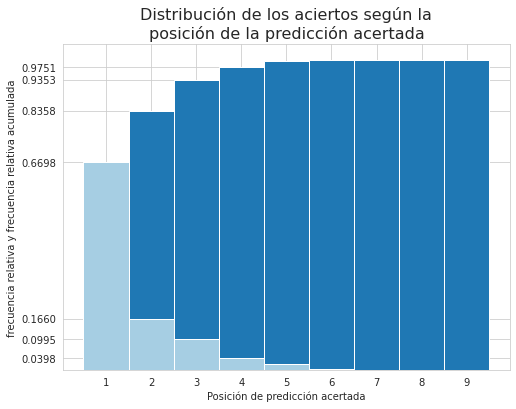

In [74]:
sns.set_style('whitegrid')

paleta=sns.color_palette('Paired')

fig,ax =plt.subplots(1, 1,figsize=(8,6))

data=naive_5_05_evalua_vld
bins=np.arange(1,11,1)

plt.hist(data=data,
             x='posicion acierto',
             bins=bins,density=True, cumulative=True, color=paleta.as_hex()[1])

plt.hist(data=data,
             x='posicion acierto',
             bins=bins,density=True, color=paleta.as_hex()[0])

titulo='Distribución de los aciertos según la posición de la predicción acertada'
ax.set_title(textwrap.fill(titulo,45),fontsize=16)
ax.set_xlabel('Posición de predicción acertada')
ax.set_ylabel('frecuencia relativa y frecuencia relativa acumulada')

x_ticks=np.arange(1,10,1)
ax.set_xticks(x_ticks+0.5)
ax.set_xticklabels(x_ticks)

y_ticks=posicion_acierto_por_obs['proporción acumulada'].unique()[:4].tolist()
y_ticks=y_ticks+posicion_acierto_por_obs['proporción aciertos'].unique()[1:4].tolist()
ax.set_yticks(y_ticks)

plt.show()

### Observación: 

Se observa que más del 65 % de los aciertos se dan en la primera predicción y más de un 80 % se dan en alguna de las dos primeras. Esto sugiere que el número de predicciones del clasificador es demasiado alto.

### Inspección de la mediana de la posición de la predicción acertada por título

La inspección del número de observaciones para cada valor observado de la mediana de la posición acertada por título en este punto (sobre el dataset con todas observaciones o encuestados en validación) tiene una interpretación intrincada: la cuenta de las observaciones para cada valor de la mediana por título indica el número de encuestados (no de títulos) asociado a cada mediana por título registrada. 

La presencia de valores decimales en el conjunto de medianas por título observadas indica que hay títulos para los que la posición mediana está empatada entre dos posiciones consecutivas. 

In [75]:
naive_5_05_evalua_vld['mediana posicion acierto por cat regresor'].value_counts()

1.0    7979
2.0    2948
3.0     539
1.5     277
2.5     208
4.0      18
Name: mediana posicion acierto por cat regresor, dtype: int64

# 7.1. Métricas de evaluación: accuracy

La función **naive_evalua_accuracy** filtra los resultados del proceso de evaluación relevantes para el cálculo del accuracy desagregado por títulos. Conserva también información adicional útil para estudiar el comportamiento del clasificador. 

In [76]:
def naive_evalua_accuracy(clasificador,data):
    
    """ Recupera la información de la evaluación relativa al accuracy desagregado por títulos y prescinde del 
    detalle observación a observación. 
    """
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_regresor=list(filter(lambda col: re.search('.*regresor.*',col),evalua.columns))
    lista_re_regresor=lista_re_regresor+['suma prob prediccion']
    
    # Elimina duplicados (obs con mismo título y ocupación). La info relevante ya está agregada: 
    evalua=evalua[lista_re_regresor].drop_duplicates() 
    evalua.set_index(evalua.columns[0],inplace=True)
    
    evalua.sort_values(by='accuracy regresor',ascending=False,inplace=True)

    return evalua

In [77]:
prueba=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_prueba)
#prueba

## Evaluación del accuracy en el conjunto de validación 

A continuación se exploran las métricas de accuracy y accuracy ajustado obtenidas para el dataset de validación:

- Distribución de las métricas de accuracy por título. 

- Análisis de la mediana de la posición acertada por título.

- Relación entre accuracy y accuracy ajustado. 

- Relación entre el número de predicciones y el número de encuestados por título en train.

- Relación entre las métricas de accuracy y: 
    - El número de encuestados por título en train.
    - El número de ocupaciones predichas para cada título y la posición más frecuente de la predicción acertada. 
    - El número de ocupaciones observadas para cada título en train. 
    
- Relación entre las métricas de accuracy ponderado y accuracy ajustado ponderado
    
El análisis descriptivo de la evaluación del modelo presta especial importancia al estudio de la **influencia del número de predicciones por título** porque este es el unico aspecto del clasificador que puede modificarse para mejorar su rendimiento. 

In [78]:
naive_5_05_evalua_accuracy_vld=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_vld)

In [79]:
naive_5_05_evalua_accuracy_vld.shape, df_vld['titulo_ppal_'].nunique() # Comprobación: 

((173, 13), 173)

In [80]:
naive_5_05_evalua_accuracy_vld.head()

,num pred por regresor,cat target por regresor (train),obs regresor (train),mediana posicion acierto por cat regresor,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
regresor: titulo_ppal_,,,,,,,,,,,,,
Grado Odontología,1,4,146,1.0,45,45,45.000000,1.000000,1.000000,0.003760,0.003760,0.003760,0.979452
Grado Literatura,5,12,35,1.0,10,10,4.607143,1.000000,0.460714,0.000835,0.000835,0.000385,0.800000
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",5,8,19,1.0,7,7,1.812500,1.000000,0.258929,0.000585,0.000585,0.000151,0.842105
Grado Medicina,1,8,860,1.0,293,289,289.000000,0.986348,0.986348,0.024480,0.024146,0.024146,0.983721
Máster Música y artes del espectáculo,3,11,54,1.0,23,22,10.822222,0.956522,0.470531,0.001922,0.001838,0.000904,0.833333


In [81]:
naive_5_05_evalua_accuracy_vld.tail()

,num pred por regresor,cat target por regresor (train),obs regresor (train),mediana posicion acierto por cat regresor,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
regresor: titulo_ppal_,,,,,,,,,,,,,
Grado Protocolo y eventos,7,7,14,2.0,3,1,0.214286,0.333333,0.071429,0.000251,0.000084,0.000018,1.000000
Grado Marketing,4,23,104,2.5,31,10,3.061538,0.322581,0.098759,0.002590,0.000835,0.000256,0.625000
"Máster Biblioteconomía, documentación y archivos",4,15,44,1.5,13,4,1.400000,0.307692,0.107692,0.001086,0.000334,0.000117,0.681818
Grado Relaciones internacionales,4,14,23,1.0,10,2,0.923077,0.200000,0.092308,0.000835,0.000167,0.000077,0.565217
Grado Geografía,4,34,88,2.0,27,5,1.243243,0.185185,0.046046,0.002256,0.000418,0.000104,0.420455


## Distribución de las métricas de accuracy por títulos

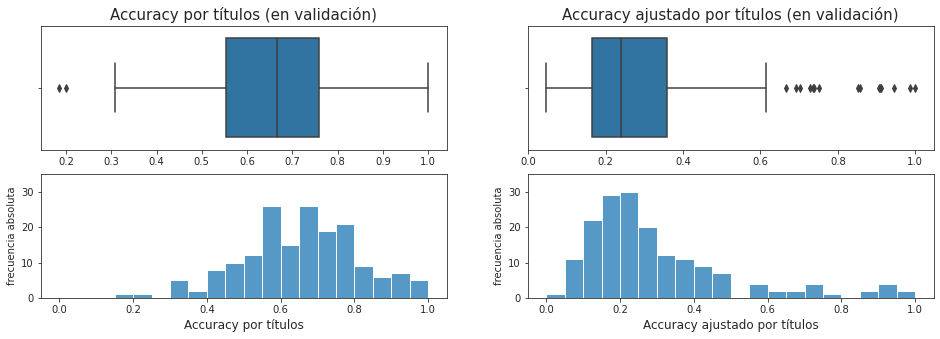

In [82]:
sns.set_style('ticks')

fig, ax = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):

    sns.boxplot(ax=ax[0,i],data=naive_5_05_evalua_accuracy_vld,
                x=col)
    ax[0,i].set_xlabel('',fontsize=font_labels)
    
    sns.histplot(ax=ax[1,i],data=naive_5_05_evalua_accuracy_vld,
                 x=col,
                 bins=np.arange(0,1.05,0.05))
    ax[1,i].set_ylim(0,35)
    ax[1,i].set_ylabel('frecuencia absoluta')
    
ax[0,0].set_title('Accuracy por títulos (en validación)',fontsize=font_titles)
ax[0,1].set_title('Accuracy ajustado por títulos (en validación)',fontsize=font_titles)

ax[1,0].set_xlabel('Accuracy por títulos',fontsize=font_labels)
ax[1,1].set_xlabel('Accuracy ajustado por títulos',fontsize=font_labels)

fig.subplots_adjust(hspace=.2)
plt.show()

## Top 20 de títulos con mejores métricas de accuracy

In [83]:
# Ranking top 20 de accuracy: 
rank_accuracy=naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor',
                'obs regresor (train)','num pred por regresor','mediana posicion acierto por cat regresor']]
rank_accuracy.rename(columns={'accuracy regresor':'accuracy',
                              'accuracy ajustado regresor':'accuracy ajustado',
                              'obs regresor (train)':'observaciones (train)',
                              'num pred por regresor':'núm. de predicciones',
                              'mediana posicion acierto por cat regresor':'mediana posición prediccion acertada'},
              inplace=True)
rank_accuracy.index.rename('titulo',inplace=True)
rank_accuracy['mediana posición prediccion acertada']=rank_accuracy['mediana posición prediccion acertada']\
                                                      .astype(int)
for col in ['accuracy','accuracy ajustado']:
    aux_rank=pd.DataFrame(rank_accuracy[col].rank(ascending=False, method='min'))
    aux_rank.rename(columns={col:'rank '+str(col)},inplace=True)
    rank_accuracy=rank_accuracy.merge(aux_rank,left_index=True,right_index=True)
    rank_accuracy['rank '+str(col)]=rank_accuracy['rank '+str(col)].astype(int)
rank_accuracy.sort_values(by='accuracy',ascending=False,inplace=True)
top_20_acc=rank_accuracy.head(20)
top_20_acc.index.rename('Títulos ordenados por accuracy: top 20',inplace=True)
top_20_acc

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado
Títulos ordenados por accuracy: top 20,,,,,,,
Grado Odontología,1.000000,1.000000,146,1,1,1,1
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",1.000000,0.258929,19,5,1,1,78
Grado Literatura,1.000000,0.460714,35,5,1,1,26
Grado Medicina,0.986348,0.986348,860,1,1,4,2
Máster Música y artes del espectáculo,0.956522,0.470531,54,3,1,5,24
Grado Fisioterapia,0.944444,0.944444,481,1,1,6,3
Máster Desarrollo y análisis de aplicaciones y de software,0.918919,0.254505,104,4,2,7,80
Grado Podología,0.911765,0.911765,94,1,1,8,4
Máster Odontología,0.909091,0.909091,44,1,1,9,5


In [84]:
# Distribución del número de predicciones en el top 20 de accuracy: 
top_20_acc['núm. de predicciones'].value_counts(normalize=True)

1    0.40
5    0.15
3    0.15
7    0.10
4    0.10
6    0.05
2    0.05
Name: núm. de predicciones, dtype: float64

In [85]:
# Distribución de la mediana de la posición de la predicción acertada en el top 20 de accuracy cuando hay ...
# ... varias predicciones: 
top_20_acc[top_20_acc['núm. de predicciones']>1][['núm. de predicciones','mediana posición prediccion acertada']]

,núm. de predicciones,mediana posición prediccion acertada
Títulos ordenados por accuracy: top 20,,
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",5,1
Grado Literatura,5,1
Máster Música y artes del espectáculo,3,1
Máster Desarrollo y análisis de aplicaciones y de software,4,2
Máster Aprendizaje de segundas lenguas,7,2
Máster Ventas al por mayor y al por menor,6,3
Grado Música y Artes escénicas,3,1
Máster Formación de docentes de enseñanza primaria,2,1
Máster Matemáticas,4,1


In [86]:
# Distribución de la mediana de la posición de la predicción acertada en el top 20 de accuracy cuando hay ...
# ... varias predicciones: 
top_20_acc[top_20_acc['núm. de predicciones']>1]['mediana posición prediccion acertada']\
                                                .value_counts(normalize=True)

1    0.666667
2    0.250000
3    0.083333
Name: mediana posición prediccion acertada, dtype: float64

In [87]:
# Ranking top 20 de accuracy ajustado: 
top_20_acc_ajtd=rank_accuracy.sort_values(by='accuracy ajustado',ascending=False)
top_20_acc_ajtd.index.rename('Títulos ordenados por accuracy ajustado: top 20',inplace=True)
top_20_acc_ajtd=top_20_acc_ajtd.head(20)
top_20_acc_ajtd

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado
Títulos ordenados por accuracy ajustado: top 20,,,,,,,
Grado Odontología,1.000000,1.000000,146,1,1,1,1
Grado Medicina,0.986348,0.986348,860,1,1,4,2
Grado Fisioterapia,0.944444,0.944444,481,1,1,6,3
Grado Podología,0.911765,0.911765,94,1,1,8,4
Máster Odontología,0.909091,0.909091,44,1,1,9,5
Grado Enfermería,0.907489,0.907489,1398,1,1,10,6
Grado Ingeniería aeronáutica,0.857143,0.857143,197,1,1,16,7
Máster Enfermería,0.852941,0.852941,93,1,1,17,8
Grado Arquitectura y Urbanismo y paisajismo,0.820513,0.752137,358,2,1,23,9


In [88]:
# Distribución del número de predicciones en el top 20 de accuracy ajustado: 
top_20_acc_ajtd['núm. de predicciones'].value_counts(normalize=True)

1    0.55
2    0.35
3    0.10
Name: núm. de predicciones, dtype: float64

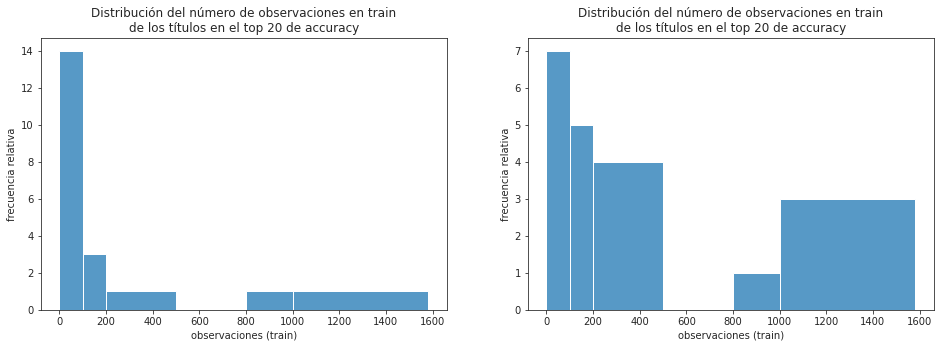

In [89]:
# Distribución del número de observaciones en train de los títulos en el top 20 de accuracy y accuracy ajustado:
fig, ax = plt.subplots(1, 2,figsize=(16,5))
bins=(0,100,200,500,800,1000,rank_accuracy['observaciones (train)'].max())

sns.histplot(ax=ax[0],x=top_20_acc['observaciones (train)'],bins=bins)
sns.histplot(ax=ax[1],x=top_20_acc_ajtd['observaciones (train)'],bins=bins)

title_0='Distribución del número de observaciones en train de los títulos en el top 20 de accuracy'
ax[0].set_title(textwrap.fill(title_0,50))
title_1='Distribución del número de observaciones en train de los títulos en el top 20 de accuracy ajustado'
ax[1].set_title(textwrap.fill(title_0,50))

for i in [0,1]:
    #ax[i].set_ylim(0,0.15)
    ax[i].set_ylabel('frecuencia relativa')

plt.show()

In [90]:
# Títulos en el top 20 en las dos métricas de accuracy:
top_acc=top_20_acc.index.tolist()
top_acc_ajtd=top_20_acc_ajtd.index.tolist()
top_top=[tt for tt in top_acc if tt in top_acc_ajtd]
top_accuracy=rank_accuracy[rank_accuracy.index.isin(top_top)]
top_accuracy.index.rename('Títulos en el top 20 de accuracy y de accuracy ajustado',inplace=True)
top_accuracy

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado
Títulos en el top 20 de accuracy y de accuracy ajustado,,,,,,,
Grado Odontología,1.000000,1.000000,146,1,1,1,1
Grado Medicina,0.986348,0.986348,860,1,1,4,2
Grado Fisioterapia,0.944444,0.944444,481,1,1,6,3
Grado Podología,0.911765,0.911765,94,1,1,8,4
Máster Odontología,0.909091,0.909091,44,1,1,9,5
Grado Enfermería,0.907489,0.907489,1398,1,1,10,6
Grado Música y Artes escénicas,0.882353,0.598529,94,3,1,13,18
Máster Formación de docentes de enseñanza primaria,0.875000,0.701923,49,2,1,14,13
Grado Ingeniería aeronáutica,0.857143,0.857143,197,1,1,16,7


In [91]:
# Inspección títulos habilitantes en el sector de la educación: 
rank_accuracy.loc['Grado Educación primaria']

accuracy                                   0.731884
accuracy ajustado                          0.614326
observaciones (train)                   1239.000000
núm. de predicciones                       2.000000
mediana posición prediccion acertada       1.000000
rank accuracy                             52.000000
rank accuracy ajustado                    16.000000
Name: Grado Educación primaria, dtype: float64

In [92]:
# Inspección títulos habilitantes en el sector de la educación: 
rank_accuracy.loc['Máster Formación de docentes de educación secundaria y formación profesional']

accuracy                                   0.693989
accuracy ajustado                          0.562358
observaciones (train)                   1038.000000
núm. de predicciones                       2.000000
mediana posición prediccion acertada       1.000000
rank accuracy                             71.000000
rank accuracy ajustado                    21.000000
Name: Máster Formación de docentes de educación secundaria y formación profesional, dtype: float64

In [93]:
# Inspección de otro título asociado a la educación: 
naive_predice(clasificador=naive_5_05_train,valor_regresor='Grado Música y Artes escénicas')

,prediccion,probabilidad
0,Profesionales de la enseñanza,0.702128
1,Profesionales de la cultura y el espectáculo,0.085106
2,Profesionales de la eduación especial y no reglada,0.063830


In [94]:
df[df['titulo_ppal_']=='Grado Música y Artes escénicas']['familia_ppal_'].unique()

array(['Artes y humanidades'], dtype=object)

### Observaciones: 

- El top 20 de títulos con mejor accuracy y el de títulos con mejor accuracy ajustado solo tienen 11 títulos en común: entre los de mejor accuracy se encuentran títulos con accuracy ajustado modesto o pequeño. Esto se debe a que, para estos títulos, las tasas altas de acierto en las predicciones se alcanzan gracias a que el clasificador ofrece muchas ocupaciones distintas como predicción, lo cual tiene una penalización fuerte en el accuracy ajustado. En efecto: 

    - En el top 20 de accuracy se registran títulos para los que se hacen entre una (40 %) y siete predicciones. Para dos tercios de los títulos en este top_20 que ofrecen más de una predicción, al menos la mitad de los aciertos se dan con la primera (la mediana de la posición de la predicción acertada es 1). En el resto de los casos, al menos la mitad de los aciertos se dan con las dos o las tres predicciones más probables, esto es, con la mitad o menos de la mitad de las predicciones que se ofrecen. 

    - Más de la mitad (55 %) de los títulos en el top 20 de accuracy ajustado tienen una predicción única. El número máximo de predicciones para los títulos de este ranking es tres. Cuando se ofrecen varias predicciones, al menos la mitad de los aciertos se dan en la primera predicción (la mediana de la posición de la predicción acertada es uno para todos los títulos). 


- 14 de los 20 títulos en el top 20 de accuracy tienen menos de 100 observaciones en train. Para la mayoría, el número de predicciones para el título también es alto. Sin embargo, en muchos casos la mediana de la predicción acertada es la primera. Esto sugiere que sus puntuaciones de accuracy ajustado mejorarían si se reduce el número de predicciones: la reducción en el número de aciertos se compensaría con una menor penalización por el número de intentos. 


- 7 de los 20 títulos en el top 20 de accuracy ajustado también tienen menos de 100 observaciones en train. Son 5 títulos de especialización de la rama de Ciencias de la salud, un título de la familia de Educación y uno de la familia de Artes y humanidades, el grado en Música y artes escénicas, para el que la ocupación más probable también es la enseñanza.  


- La presencia de títulos con pocas observaciones en train en los top 20 de las dos métricas de accuracy sugiere que el **tamaño de la muestra** no es determinante para explicar las diferencias de rendimiento del clasificador para distintos títulos. 
    
    
- Todos los títulos que alcanzan los valores más altos de accuracy con una **predicción única** son del **ámbito sanitario** excepto uno, el grado en Ingeniería aeronáutica. Esto será determinante para las métricas de recall de las ocupaciones asociadas. 


- Hay títulos de la **familia de Educación** entre los 20 con mejor accuracy o mejor accuracy ajustado, pero solo uno, el máster de Formación de docentes de enseñanza primaria, está entre los valores más altos de las dos métricas. Llama la atención que los mejores resultados se den para este máster, que no es habilitante, y no para otros que sí lo son, como el grado en Educación primaria (que solo destaca en accuracy ajustado) o el máster de Formación del profesorado de educación secundaria y formación profesional (en la posición 21 del ranking de accuracy ajustado). 


- Casi todos los **títulos para los que el clasificador ofrece una predicción única** pertenecen al top 20 de las dos métricas de accuracy (véase el detalle a continuación). Las excepciones son los grados en Óptica y optometria, en Veterinaria y en Farmacia. Estos títulos sí están en el top 20 de accuracy ajustado, pero no en el de accuracy no ajustado, en el que son adelantados por otros títulos con mayor tasa de aciertos gracias a un mayor número de predicciones. 

In [95]:
# Inspección de títulos con menor número de predicciones: 
inspecciona_num_pred=naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor',
                                                     'num pred por regresor']]
inspecciona_num_pred.sort_values(by='num pred por regresor',inplace=True)
inspecciona_num_pred.head(15)

,accuracy regresor,accuracy ajustado regresor,num pred por regresor
titulo,,,
Grado Odontología,1.000000,1.000000,1
Grado Óptica y optometría,0.692308,0.692308,1
Grado Medicina,0.986348,0.986348,1
Grado Fisioterapia,0.944444,0.944444,1
Grado Podología,0.911765,0.911765,1
Máster Odontología,0.909091,0.909091,1
Grado Enfermería,0.907489,0.907489,1
Grado Veterinaria,0.727273,0.727273,1
Grado Farmacia,0.736842,0.736842,1


In [96]:
# Títulos con una predicción única fuera de alguno los rankings top 20: 
tt_1_pred=inspecciona_num_pred[inspecciona_num_pred['num pred por regresor']==1].index
tt_1_pred_check_top_accuracy=[tt for tt in tt_1_pred if tt not in top_top]
tt_1_pred_check_top_accuracy

['Grado Óptica y optometría', 'Grado Veterinaria', 'Grado Farmacia']

In [97]:
# Títulos con una predicción única fuera del top 20 de accuracy (no ajustado): 
tt_1_pred_check_top_accuracy_no_ajustado=[tt for tt in tt_1_pred if tt not in top_acc]
tt_1_pred_check_top_accuracy_no_ajustado

['Grado Óptica y optometría', 'Grado Veterinaria', 'Grado Farmacia']

In [98]:
# Ningún título con predicción única fuera del top 20 de accuracy ajustado: 
tt_1_pred_check_top_accuracy_ajustado=[tt for tt in tt_1_pred if tt not in top_acc_ajtd]
tt_1_pred_check_top_accuracy_ajustado

[]

## Tail 20 de títulos con peores métricas de accuracy

In [99]:
# Los 20 títulos con peor accuracy: 
tail_20_acc=rank_accuracy.sort_values(by='accuracy').head(20)
tail_20_acc.index.rename('Títulos con peor accuracy: tail 20',inplace=True)
tail_20_acc

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado
Títulos con peor accuracy: tail 20,,,,,,,
Grado Geografía,0.185185,0.046046,88,4,2,173,173
Grado Relaciones internacionales,0.200000,0.092308,23,4,1,172,163
"Máster Biblioteconomía, documentación y archivos",0.307692,0.107692,44,4,1,171,160
Grado Marketing,0.322581,0.098759,104,4,2,170,162
Grado Diseño,0.333333,0.078125,49,5,3,168,167
Grado Protocolo y eventos,0.333333,0.071429,14,7,2,168,170
Grado Política y gestión pública,0.346154,0.114793,160,4,1,167,152
Grado Sociología e Igualdad de género,0.352941,0.112395,124,4,1,166,156
"Máster Industrias de otros materiales (madera, papel, plástico, vidrio,..)",0.363636,0.216301,35,3,1,165,97


In [100]:
# Los 20 títulos con peor accuracy ajustado:
tail_20_acc_ajtd=rank_accuracy.sort_values(by='accuracy ajustado').head(20)
tail_20_acc_ajtd.index.rename('Títulos con peor accuracy ajustado: tail 20',inplace=True)
tail_20_acc_ajtd

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado
Títulos con peor accuracy ajustado: tail 20,,,,,,,
Grado Geografía,0.185185,0.046046,88,4,2,173,173
Grado Servicios (otros estudios),0.466667,0.068362,100,6,3,152,172
Grado Protocolo y eventos,0.333333,0.071429,14,7,2,168,170
Máster Hostelería,0.600000,0.071429,14,8,4,109,170
Grado Comunicación,0.428571,0.075188,29,6,3,161,169
Máster Economía,0.550000,0.075556,62,8,3,134,168
Grado Diseño,0.333333,0.078125,49,5,3,168,167
Grado Historia del arte,0.422535,0.078262,213,6,2,162,166
Grado Bellas artes,0.431818,0.087003,268,5,3,160,165


In [101]:
# Los títulos en el tail 20 de accuracy y de accuracy ajustado: 
tail_acc=tail_20_acc.index.to_list()
tail_acc_ajtd=tail_20_acc_ajtd.index.to_list()
tail_tail=[tt for tt in tail_acc if tt in tail_acc_ajtd]
tail_accuracy=rank_accuracy[rank_accuracy.index.isin(tail_tail)].sort_values(by='accuracy')
tail_accuracy.index.rename('Títulos en el tail 20 de accuracy y de accuracy ajustado',inplace=True)
tail_accuracy

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado
Títulos en el tail 20 de accuracy y de accuracy ajustado,,,,,,,
Grado Geografía,0.185185,0.046046,88,4,2,173,173
Grado Relaciones internacionales,0.200000,0.092308,23,4,1,172,163
"Máster Biblioteconomía, documentación y archivos",0.307692,0.107692,44,4,1,171,160
Grado Marketing,0.322581,0.098759,104,4,2,170,162
Grado Diseño,0.333333,0.078125,49,5,3,168,167
Grado Protocolo y eventos,0.333333,0.071429,14,7,2,168,170
Grado Sociología e Igualdad de género,0.352941,0.112395,124,4,1,166,156
Grado Historia del arte,0.422535,0.078262,213,6,2,162,166
Grado Comunicación,0.428571,0.075188,29,6,3,161,169


In [102]:
# Inspección del 'otro' grado en Geografía: 
rank_accuracy.loc['Grado Geografía y ordenación del territorio']

accuracy                                  0.437500
accuracy ajustado                         0.137019
observaciones (train)                    49.000000
núm. de predicciones                      6.000000
mediana posición prediccion acertada      1.000000
rank accuracy                           159.000000
rank accuracy ajustado                  146.000000
Name: Grado Geografía y ordenación del territorio, dtype: float64

### Observaciones: 

- Solo 9 titulos tienen un accuracy inferior a 0.4. Todos con un número de predicciones igual o mayor que 3. Sin embargo, la mediana de la posición de la predicción acertada está entre 1 y 3 para todos ellos. 


- Todos los títulos en la cola de accuracy y accuracy ajustado tienen un número de observaciones en train inferior a 300 (7 de los 11 por debajo de 100) y un número de predicciones mayor o igual a 4. Esto último indica que las ocupaciones observadas de sus titulados son muy variadas. A continuación se explora la posibilidad de que ello esté relacionado con las tasas de desempleo de las distintas titulaciones. 


- El título con peor rendimiento en las dos métricas de accuracy es el grado en Geografía. La encuesta registra otro título con una denominación similar, el grado en Geografía y ordenación del territorio, cuyas métricas son ambas muy superiores a pesar de tener un tamaño de muestra mucho menor. La inspección de la oferta académica de las universidad españolas permite deducir que Geografía y ordenación del territorio es una de las especialidades del antiguo grado en Geografía o en Geografía e Historia, al que está sustituyendo progresivamente en los catálogos de titulaciones. 

## Métricas de accuracy y tasa de desempleo

In [103]:
# Tasas de ocupación, paro e inactividad en la muestra: 
df_completo['sit_lab_'].value_counts(normalize=True)

Trabajando      0.814645
En desempleo    0.120700
Inactivo        0.064655
Name: sit_lab_, dtype: float64

In [104]:
# Se añade la tasa de paro para cada título al dataset para el análisis de las métricas de accuracy: 
desempleados_tt=df_completo[['titulo_ppal_','sit_lab']][df_completo['sit_lab']==2].groupby('titulo_ppal_')\
                                                                                  .agg(['count'])
desempleados_tt.columns=desempleados_tt.columns.to_flat_index()
desempleados_tt.rename(columns={desempleados_tt.columns[-1]:'desempleados'},inplace=True)
titulados_tt=df_completo[['titulo_ppal_','sit_lab']].groupby('titulo_ppal_').agg(['count'])
titulados_tt.columns=titulados_tt.columns.to_flat_index()
titulados_tt.rename(columns={titulados_tt.columns[-1]:'titulados'},inplace=True)
paro_tt=desempleados_tt.merge(titulados_tt,left_index=True,right_index=True)
paro_tt['tasa paro']=paro_tt['desempleados'].div(paro_tt['titulados'])
paro_tt=paro_tt['tasa paro']
rank_accuracy=rank_accuracy.merge(paro_tt,left_index=True, right_index=True)
rank_accuracy.head()

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado,tasa paro
Grado Odontología,1.000000,1.000000,146,1,1,1,1,0.060377
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",1.000000,0.258929,19,5,1,1,78,0.058824
Grado Literatura,1.000000,0.460714,35,5,1,1,26,0.208791
Grado Medicina,0.986348,0.986348,860,1,1,4,2,0.013514
Máster Música y artes del espectáculo,0.956522,0.470531,54,3,1,5,24,0.086538


In [105]:
# Tasas de paro para los títulos con peores métricas de accuracy: 
rank_accuracy[rank_accuracy.index.isin(tail_tail)].sort_values(by='accuracy')

,accuracy,accuracy ajustado,observaciones (train),núm. de predicciones,mediana posición prediccion acertada,rank accuracy,rank accuracy ajustado,tasa paro
Grado Geografía,0.185185,0.046046,88,4,2,173,173,0.207921
Grado Relaciones internacionales,0.200000,0.092308,23,4,1,172,163,0.083333
"Máster Biblioteconomía, documentación y archivos",0.307692,0.107692,44,4,1,171,160,0.113636
Grado Marketing,0.322581,0.098759,104,4,2,170,162,0.075000
Grado Diseño,0.333333,0.078125,49,5,3,168,167,0.090909
Grado Protocolo y eventos,0.333333,0.071429,14,7,2,168,170,0.066667
Grado Sociología e Igualdad de género,0.352941,0.112395,124,4,1,166,156,0.153025
Grado Historia del arte,0.422535,0.078262,213,6,2,162,166,0.220848
Grado Comunicación,0.428571,0.075188,29,6,3,161,169,0.133333
Grado Bellas artes,0.431818,0.087003,268,5,3,160,165,0.245416


In [106]:
# Auxiliar para hue en plot: 
rank_accuracy['tail']=0
rank_accuracy['tail'].mask(rank_accuracy.index.isin(tail_tail),1,inplace=True)
rank_accuracy['tail'].value_counts() # comprobación

0    161
1     11
Name: tail, dtype: int64

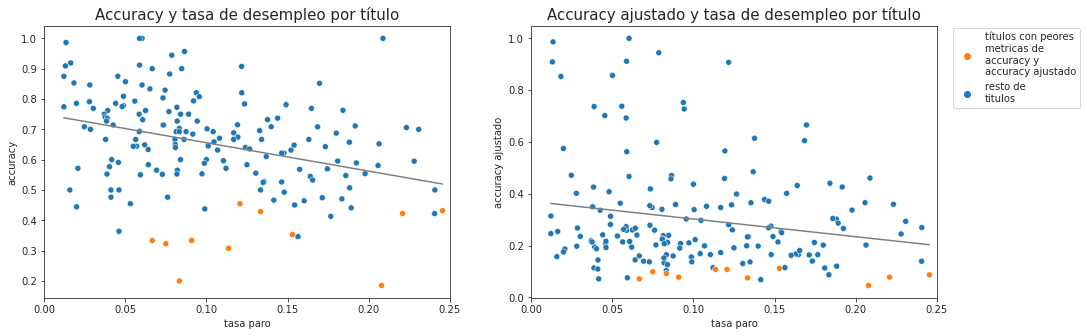

In [107]:
fig, ax = plt.subplots(1, 2,figsize=(16,5))

leyenda=[False,True]

for i, col in enumerate(['accuracy', 'accuracy ajustado']):
    
    sns.scatterplot(ax=ax[i],data=rank_accuracy,
                    x='tasa paro',
                    y=col,
                    hue='tail',legend=leyenda[i])
    sns.regplot(ax=ax[i],data=rank_accuracy,
                    x='tasa paro',
                    y=col,ci=False,scatter=False,line_kws={'linewidth':1.5},color='gray')
    ax[i].set_xlim(0,0.25)
    
handles,labels=ax[1].get_legend_handles_labels()
handles=[handles[1],handles[0]]
labels=['títulos con peores\nmetricas de\naccuracy y\naccuracy ajustado','resto de\ntitulos']
ax[1].legend(handles=handles,labels=labels,loc=(1.04,0.7))
ax[0].set_title('Accuracy y tasa de desempleo por título',fontsize=font_titles)
ax[1].set_title('Accuracy ajustado y tasa de desempleo por título',fontsize=font_titles)

plt.show()

In [108]:
rank_accuracy[['accuracy','accuracy ajustado','tasa paro']].corr()

,accuracy,accuracy ajustado,tasa paro
accuracy,1.000000,0.609417,-0.342192
accuracy ajustado,0.609417,1.000000,-0.192743
tasa paro,-0.342192,-0.192743,1.000000


### Observación: 
- Se observa una relación inversa entre las tasas de desempleo y las métricas de accuracy, más intensa para el accuracy no ajustado. Esto contribuye solo muy parcialmente a explicar los malos resultados de predicción para los títulos con peores valores de accuracy y accuracy ajustado. 

## Métricas de accuracy por ramas de conocimiento

In [109]:
# Se incorpora la columna de ramas de conocimiento: 
df_ramas.set_index('titulo_ppal_',inplace=True)
rank_accuracy=rank_accuracy.merge(df_ramas,left_index=True,right_index=True)
rank_accuracy.index.rename('titulo',inplace=True)

In [110]:
# Medianas de accuracy por ramas de conocimiento para ordenación: 
for col in ['accuracy','accuracy ajustado']:
    mediana_ramas=rank_accuracy[['rama_ppal_',col]].groupby('rama_ppal_').agg(['median'])
    mediana_ramas.columns=mediana_ramas.columns.to_flat_index()
    mediana_ramas.rename(columns={mediana_ramas.columns[-1]:'mediana '+str(col)+' rama'},inplace=True)
    rank_accuracy=rank_accuracy.reset_index().merge(mediana_ramas,on='rama_ppal_').set_index('titulo')
    rank_accuracy.index.rename('titulo',inplace=True)
#rank_accuracy.head()

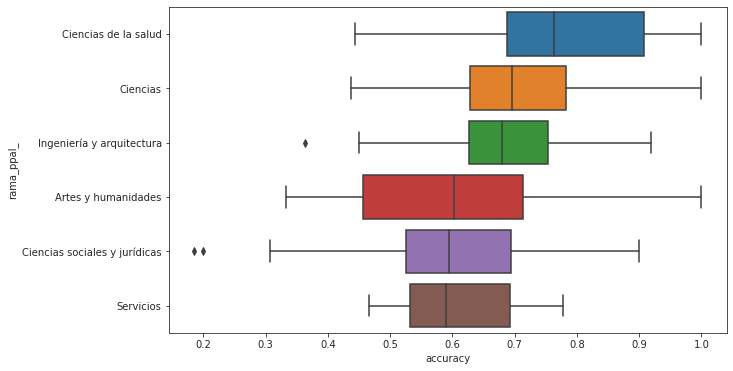

In [111]:
fig, ax = plt.subplots(1, 1,figsize=(10,6))
data=rank_accuracy[['accuracy','accuracy ajustado','rama_ppal_','mediana accuracy rama']]\
    .sort_values(by='mediana accuracy rama',ascending=False)

sns.boxplot(data=data,x='accuracy',y='rama_ppal_',)

plt.show()

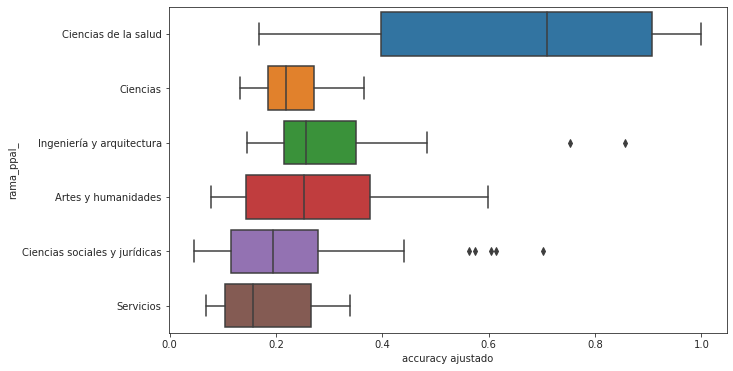

In [199]:
fig, ax = plt.subplots(1, 1,figsize=(10,6))
data=rank_accuracy[['accuracy','accuracy ajustado','rama_ppal_','mediana accuracy rama']]\
    .sort_values(by='mediana accuracy rama',ascending=False)

sns.boxplot(data=data,x='accuracy ajustado',y='rama_ppal_',)

plt.show()

## Métricas de accuracy por familias de estudios

In [112]:
# Se incorpora la columna de familias de estudios: 
df_familias.set_index('titulo_ppal_',inplace=True)
rank_accuracy=rank_accuracy.merge(df_familias,left_index=True,right_index=True)
rank_accuracy.index.rename('titulo',inplace=True)

In [113]:
# Medianas de accuracy por familias de estudios para ordenación: 
for col in ['accuracy','accuracy ajustado']:
    mediana_familias=rank_accuracy[['familia_ppal_',col]].groupby('familia_ppal_').agg(['median'])
    mediana_familias.columns=mediana_familias.columns.to_flat_index()
    mediana_familias.rename(columns={mediana_familias.columns[-1]:'mediana '+str(col)+' familia'},inplace=True)
    rank_accuracy=rank_accuracy.merge(mediana_familias,on='familia_ppal_')
#rank_accuracy.head()

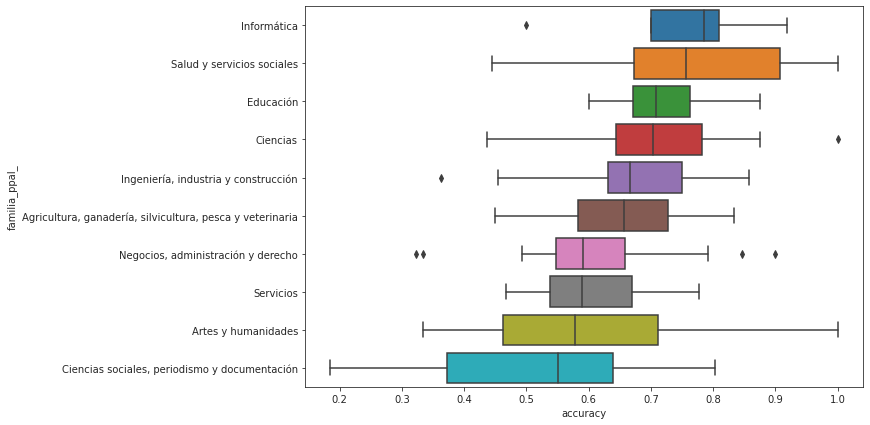

In [114]:
fig, ax = plt.subplots(1, 1,figsize=(10,7))
data=rank_accuracy[['accuracy','accuracy ajustado','familia_ppal_','mediana accuracy familia']]\
    .sort_values(by='mediana accuracy familia',ascending=False)

sns.boxplot(data=data,x='accuracy',y='familia_ppal_',)
plt.show()

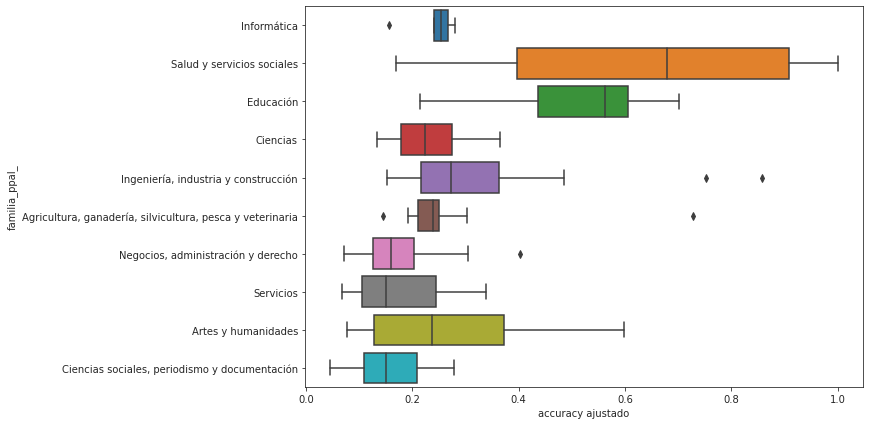

In [200]:
fig, ax = plt.subplots(1, 1,figsize=(10,7))
data=rank_accuracy[['accuracy','accuracy ajustado','familia_ppal_','mediana accuracy familia']]\
    .sort_values(by='mediana accuracy familia',ascending=False)

sns.boxplot(data=data,x='accuracy ajustado',y='familia_ppal_',)
plt.show()

## Inspección de la mediana de la posición de la predicción acertada por título

In [115]:
mediana_posicion_acierto=pd.DataFrame(naive_5_05_evalua_accuracy_vld['mediana posicion acierto por cat regresor']
                                      .value_counts())
mediana_posicion_acierto.rename(columns={'mediana posicion acierto por cat regresor':
                                         'num. de títulos'},inplace=True)
mediana_posicion_acierto['proporción']=naive_5_05_evalua_accuracy_vld['mediana posicion acierto por cat regresor']\
                                      .value_counts(normalize=True)
mediana_posicion_acierto.index.rename('mediana de posición de predicción acertada por título',inplace=True)
mediana_posicion_acierto.sort_values(by='mediana de posición de predicción acertada por título',inplace=True)
mediana_posicion_acierto['proporción acumulada']=mediana_posicion_acierto['proporción'].cumsum()
mediana_posicion_acierto

,num. de títulos,proporción,proporción acumulada
mediana de posición de predicción acertada por título,,,
1.0,97,0.560694,0.560694
1.5,12,0.069364,0.630058
2.0,41,0.236994,0.867052
2.5,5,0.028902,0.895954
3.0,16,0.092486,0.988439
4.0,2,0.011561,1.000000


### Observaciones: 

- Para el 56 % de los **títulos** la posición más frecuente de la predicción acertada es la primera. 

- Para más del del 85 % de los **títulos**, la posición más frecuente de la predicción acertada está es la primera o la segunda. 

De nuevo, los resultados indican que el número de predicciones es excesivo. Conviene ajustar los parámetros del modelo para que ofrezca menos predicciones para cada título. 

## Relación entre accuracy y accuracy ajustado

In [116]:
# df auxiliar: evita que la leyenda de los hue a continuación sea arbitraria (con 'int') o desordenada:
aux_plot=naive_5_05_evalua_accuracy_vld[['obs regresor (train)','accuracy regresor',
                                         'accuracy ajustado regresor','num pred por regresor',
                                         'mediana posicion acierto por cat regresor']]

dicc_orden=dict(zip(np.arange(1,10,1),map(lambda num:'0'+str(num),np.arange(1,10,1))))
dicc_orden[10]='10'
aux_plot['num pred por regresor'].replace(dicc_orden,inplace=True)
aux_plot.sort_values(by='num pred por regresor',inplace=True)
lista_ceros=[x for x in dicc_orden.values() if x!='10']
dicc_reverse=dict(zip(lista_ceros,map(lambda x:x[1],lista_ceros)))
aux_plot['num pred por regresor'].replace(dicc_reverse,inplace=True)
aux_plot['num pred por regresor'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '10'], dtype=object)

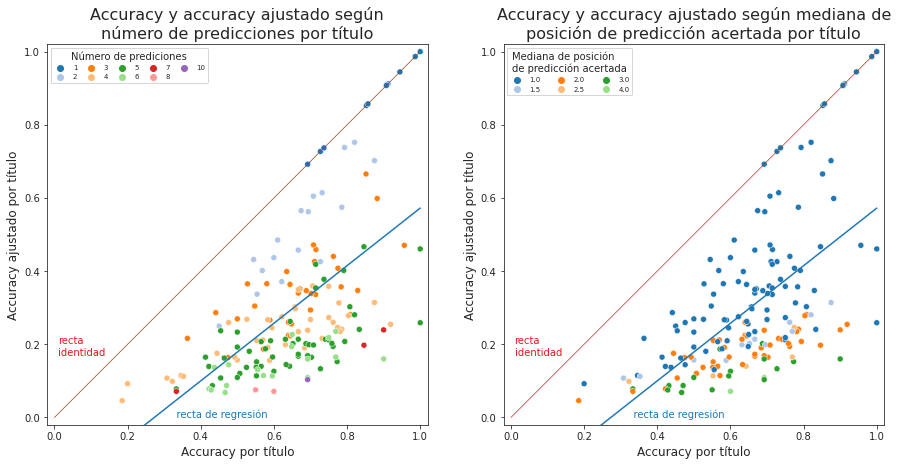

In [117]:
colores=sns.color_palette('Paired')
colores.as_hex()

sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(15,7))
font_titles=16
font_labels=12

x=np.arange(0,1,0.001)

for i,criterio in enumerate(['num pred por regresor','mediana posicion acierto por cat regresor']):

    ax[i].plot(x,x,color=colores.as_hex()[5],linewidth=0.7) # recta identidad

    sns.regplot(ax=ax[i],data=aux_plot,
                x='accuracy regresor', 
                y='accuracy ajustado regresor',
                ci=None,scatter=False,line_kws={'linewidth':1.5},color=colores.as_hex()[1]) # recta de regresión
    
    sns.scatterplot(ax=ax[i],data=aux_plot,
                    x='accuracy regresor', 
                    y='accuracy ajustado regresor',
                    hue=criterio,
                    palette='tab20',legend=True)
    
    ax[i].set_xlabel('Accuracy por título',fontsize=font_labels)
    ax[i].set_xlim(-0.02,1.02)
    ax[i].set_ylabel('Accuracy ajustado por título',fontsize=font_labels)
    ax[i].set_ylim(-0.02,1.02)
  
    ax[i].text(x=0.3,y=0,s='    recta de regresión',color=colores.as_hex()[1])
    ax[i].text(x=0.01,y=0.17,s='recta\nidentidad',color=colores.as_hex()[5])
    
titulo_0='Accuracy y accuracy ajustado según número de predicciones por título'
ax[0].set_title(textwrap.fill(titulo_0,40),fontsize=font_titles) 
titulo_1='Accuracy y accuracy ajustado según mediana de posición de predicción acertada por título'
ax[1].set_title(textwrap.fill(titulo_1,45),fontsize=font_titles)

ax[0].legend(title='Número de prediciones',ncol=5,fontsize='x-small',title_fontsize='medium',columnspacing=1)
ax[1].legend(title='Mediana de posición\nde predicción acertada',ncol=3,fontsize='x-small',title_fontsize='medium')

plt.show()

### Observaciones: 

- El accuracy y el accuracy ajustado son iguales para los títulos para los que la preedicción consiste en una única ocupación. 


- El accuracy ajustado es tanto menor que el accuracy cuanto mayor es el número de ocupaciones que se ofrecen como predicción para un título. 


- Más de la mitad de los títulos para los que se ofrecen varias ocupaciones como predicción aciertan más de la mitad de las veces con la primera ocupación predicha. Esto indica que **el número de ocupaciones que el clasificador ofrece como predicción para estos títulos es excesivo**. 

In [118]:
# Coeficiente de correlación lineal de Pearson de accuracy y accuracy ajustado: 
r_acc_accajustado=naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor']].corr()
r_acc_accajustado

,accuracy regresor,accuracy ajustado regresor
accuracy regresor,1.000000,0.606395
accuracy ajustado regresor,0.606395,1.000000


In [119]:
# R cuadrado de accuracy y accuracy ajustado (con regresor único, R² =r²): 
R_sq=r_acc_accajustado['accuracy ajustado regresor'].loc['accuracy regresor']**2
R_sq
# El accuracy explica algo menos del 40 % del accuracy ajustado

0.36771442541369104

## Relación entre número de predicciones y número de encuestados en train

Se analiza la relación entre el número de titulados encuestados en train para cada título y el número de ocupaciones que se predicen para el mismo. 

En las representaciones gráficas **se destacan algunos títulos** que ilustran bien el efecto que tiene el ajuste definido para la métrica de accuracy. Son los siguientes: 

 - **Grados en Medicina, en Fisioterapia y en Enfermería**, por ser los únicos con un accuracy por encima de 0.9 y más de 400 titulados encuestados en train. Para estos títulos el clasificador ofrece una única predicción, por que su accuracy es igual a su accuracy ajustado. Ilustran que el ajuste de la métrica de accuracy no tiene efecto cuando las ocupaciones observadas para un título tienen poca variabilidad.
 
 
 - **Grados en Derecho, en Administración y empresa y en Informática**. Lo excepciónal de estos títulos es que tienen los números más altos de encuestados en train y, sin embargo, el clasificador les ofrece entre 3 y 5 predicciones de ocupaciones diferentes. Esto indica que las ocupaciones para estos titulados son muy variadas incluso cuando se analizan muestras grandes. Como consecuencia, su accuracy ajustado es muy inferior a su accuracy no ajustado. Ilustran el efecto intenso del ajuste en la métrica de accuracy cuando se ofrecen muchas predicciones. 

In [120]:
# Títulos con accuracy por encima de 0.9:
columnas=['num pred por regresor','obs regresor (train)','num obs regresor',
          'accuracy regresor','accuracy ajustado regresor']
naive_5_05_evalua_accuracy_vld[naive_5_05_evalua_accuracy_vld['accuracy regresor']>0.9][columnas]

,num pred por regresor,obs regresor (train),num obs regresor,accuracy regresor,accuracy ajustado regresor
titulo,,,,,
Grado Odontología,1,146,45,1.000000,1.000000
Grado Literatura,5,35,10,1.000000,0.460714
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",5,19,7,1.000000,0.258929
Grado Medicina,1,860,293,0.986348,0.986348
Máster Música y artes del espectáculo,3,54,23,0.956522,0.470531
Grado Fisioterapia,1,481,162,0.944444,0.944444
Máster Desarrollo y análisis de aplicaciones y de software,4,104,37,0.918919,0.254505
Grado Podología,1,94,34,0.911765,0.911765
Máster Odontología,1,44,11,0.909091,0.909091


In [121]:
# Títulos con más de 1300 titulados encuestados en train: 
naive_5_05_evalua_accuracy_vld[naive_5_05_evalua_accuracy_vld['obs regresor (train)']>1300][columnas]

,num pred por regresor,obs regresor (train),num obs regresor,accuracy regresor,accuracy ajustado regresor
titulo,,,,,
Grado Enfermería,1,1398,454,0.907489,0.907489
Grado Informática,3,1313,450,0.808889,0.281318
Grado Derecho,4,1319,457,0.658643,0.297127
Grado Administración y empresa,5,1582,541,0.552680,0.152062


In [122]:
# Lista de títulos a destacar para ilustrar las conclusiones: 

destaca_titulos=['Grado Derecho','Grado Informática','Grado Administración y empresa',
                      'Grado Medicina','Grado Enfermería','Grado Fisioterapia']

In [123]:
# Auxiliar para plot: premite identificar los títulos en las representaciones gráficas. 
tts=list()

aux_tt_plot=naive_5_05_evalua_accuracy_vld
aux_tt_plot=aux_tt_plot[aux_tt_plot.index.isin(destaca_titulos)]

for tt in aux_tt_plot.index:
    titulo=tt.split(' ',1)[0][0]+' '+tt.split(' ',1)[1]+'  '
    x=aux_tt_plot['obs regresor (train)'].loc[tt]
    y=aux_tt_plot['num pred por regresor'].loc[tt]
    tts.append((x,y,titulo))
#tts

In [124]:
# Títulos que se destacan especialmente por su comportamiento atípico en cuanto a la relación entre el número ...
# ... de predicciones y de observaciones en train: 

tt_prediccion_atipica=['Grado Derecho','Grado Informática','Grado Administración y empresa']

aux_plot_1=naive_5_05_evalua_accuracy_vld[['obs regresor (train)','num pred por regresor']]
aux_plot_1['atipicos']=0
aux_plot_1['atipicos'].mask(aux_plot_1.index.isin(tt_prediccion_atipica),1,inplace=True)

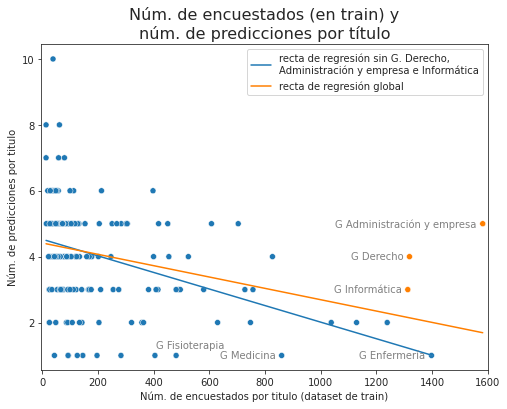

In [125]:
paleta=sns.color_palette('Paired')
color_0=paleta.as_hex()[1]
color_1=paleta.as_hex()[7]
fig, ax = plt.subplots(1, 1,figsize=(8,6))

sns.scatterplot(data=aux_plot_1,
                x='obs regresor (train)',
                y='num pred por regresor',
                hue='atipicos',
                palette=[color_0,color_1],legend=False)

# regresión sin tt atípicos: 
sns.regplot(data=aux_plot_1[aux_plot_1['atipicos']==0],
            x='obs regresor (train)',
            y='num pred por regresor',
            ci=False,scatter=False,color=color_0,line_kws={'linewidth':1.5})

# regresíon global: 
sns.regplot(data=aux_plot_1,
            x='obs regresor (train)',
            y='num pred por regresor',
            ci=False,scatter=False,color=color_1,line_kws={'linewidth':1.5})

titulo='Núm. de encuestados (en train) y núm. de predicciones por título'
ax.set_title(textwrap.fill(titulo,35),fontsize=16)
ax.set_xlabel('Núm. de encuestados por titulo (dataset de train)')
ax.set_ylabel('Núm. de predicciones por titulo')
ax.set_xlim(-3,1600)

for tt in tts:
    if tt[2]=='G Fisioterapia  ':
        ax.text(x=tt[0]+60,y=tt[1]+0.3,s=tt[2],va='center',ha='center',color='grey')
    else:
        ax.text(x=tt[0],y=tt[1],s=tt[2],va='center',ha='right',color='grey')
    
label_0='recta de regresión sin G. Derecho,\nAdministración y empresa e Informática'
label_1='recta de regresión global'
    
ax.legend(labels=[label_0,label_1])

plt.show()

### Observaciones: 

- El número de predicciones por título tiene una relación inversa con el número de titulados encuestados en train. Esto de debe a que cuando aumenta el número de encuestados de una titulación, disminuye el peso individual de las ocupaciones más infrecuentes. Esto hace que las predicciones para el título sean menos (en número) y más sólidas (asociadas a probabilidades más altas).  


- La relación inversa entre titulados encuestados y número de predicciones es más intensa cuando se exluyen los tres títulos que destacan por estar entre los cuatro con mayor número de titulados y, sin embargo, mantener una alta variabilidad en las ocupaciones representativas de sus egresados: **Grado en Derecho, Grado en Administración y empresa y Grado en Informática**. Son, en efecto, titulaciones muy versátiles relacionadas con un buen número de profesiones y sectores económicos diferentes, por lo que será especialmente difícil hacer predicciones de ocupaciones acertadas para ellos. Además, por su fuerte peso en cuanto a número de titulados, tendrán mucha influencia en las métricas globales de accuracy. 

(Véanse los coeficientes de regresión a continuación para el detalle sobre la intensidad de la relación entre el número de titulados encuestados y el número de predicciones). 

In [126]:
# Correlación entre el número de observaciones en train y el número de predicciones: 
aux_plot_1[['obs regresor (train)','num pred por regresor']].corr()

,obs regresor (train),num pred por regresor
obs regresor (train),1.000000,-0.317988
num pred por regresor,-0.317988,1.000000


In [127]:
# Correlación entre el número de observaciones en train y el número de predicciones excluyendo los grados en ...
# ... Derecho, Administración y empresa e Informática: 
aux_plot_1[aux_plot_1['atipicos']==0][['obs regresor (train)','num pred por regresor']].corr()

,obs regresor (train),num pred por regresor
obs regresor (train),1.000000,-0.385721
num pred por regresor,-0.385721,1.000000


## Relación entre métricas de accuracy y número de encuestados por título



In [128]:
# Auxiliar para plot: títulos a destacar por su comportamiento dispar en cuanto a accuracy y accuracy ajustado
tt_acc=list()
tt_acc_ajtd=list()

aux_acc=naive_5_05_evalua_accuracy_vld
aux_acc=aux_acc[aux_acc.index.isin(destaca_titulos)]

for tt in aux_acc.index:
    titulo=tt.split(' ',1)[0][0]+' '+tt.split(' ',1)[1]+'  '
    x=aux_acc['obs regresor (train)'].loc[tt]
    y_acc=aux_acc['accuracy regresor'].loc[tt]
    y_acc_ajtd=aux_acc['accuracy ajustado regresor'].loc[tt]
    tt_acc.append((x,y_acc,titulo))
    tt_acc_ajtd.append((x,y_acc_ajtd,titulo))
#tt_acc, tt_acc_ajtd

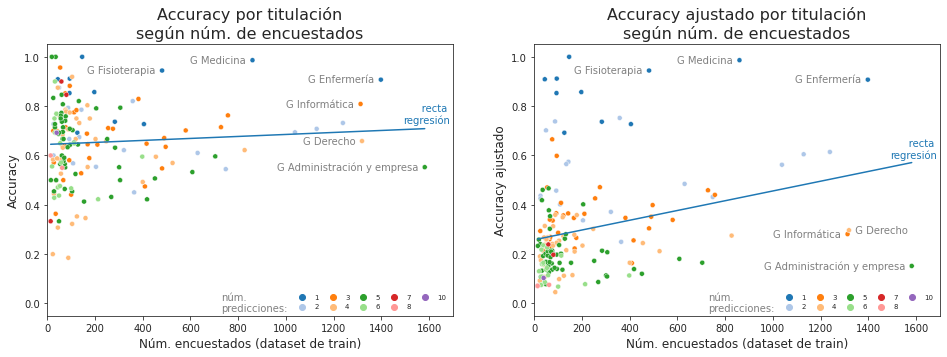

In [129]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    
    sns.regplot(ax=ax[i],data=aux_plot,
                    x='obs regresor (train)',
                    y=col,
                    ci=False,scatter=False,line_kws={'linewidth':1.5},color=colores.as_hex()[1])

    sns.scatterplot(ax=ax[i],data=aux_plot,
                    x='obs regresor (train)',
                    y=col,
                    hue='num pred por regresor',palette='tab20',s=25)
    
    ax[i].set_xlabel('Núm. encuestados (dataset de train)',fontsize=font_labels)
    ax[i].set_xlim(-1,1700)
    ax[i].set_ylim(-0.05,1.052)
    
    
    ax[i].legend(ncol=5,title=None,fontsize='x-small',title_fontsize='small',frameon=False,loc='lower right',
                columnspacing=1)
    ax[i].text(x=730,y=0.01,s='núm.\npredicciones:',color='gray',fontsize=10,va='center_baseline')
    
    yy=[0.73,0.59]
    ax[i].text(x=1490,y=yy[i],s='      recta\nregresión',color=colores.as_hex()[1])
    
titulo_0='Accuracy por titulación según núm. de encuestados'
ax[0].set_title(textwrap.fill(titulo_0,25),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)

titulo_1='Accuracy ajustado por titulación según núm. de encuestados'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)

for tt in tt_acc:
    ax[0].text(x=tt[0],y=tt[1],s=tt[2],va='center',ha='right',color='gray')

for tt in tt_acc_ajtd:
    if tt[2]=='G Derecho  ':
        ax[1].text(x=tt[0],y=tt[1],s='  '+tt[2],va='center',ha='left',color='gray')
    else: 
        ax[1].text(x=tt[0],y=tt[1],s=tt[2],va='center',ha='right',color='gray')

fig.subplots_adjust(hspace=.5)
plt.show()

### Observaciones: 

- Se observa de nuevo que hay una **relación inversa entre el número de titulados encuestados y el número de predicciones para cada título**: los títulos con mayor número de prediciones se concentran en la región izquierda del gráfico. 


- Las dos métricas de accuracy son crecientes con el número de encuestados (véanse los valores exactos de la correlación a continuación). Esta relación directa es débil para el accuracy y algo más intensa para el accuracy ajustado, que penaliza el exceso de predicciones, lo que ocurre con más frecuencia para títulos con menor número de encuestados. 


- Al ajustar a métrica de accuracy disminuyen las puntuaciones de todos los títulos excepto aquellos para los que se ofrece una predicción única. Esto se aprecia en la representación gráfica observando que el descenso de las puntuaciones de los titulos al ajustar el accuracy es más notable cuanto más alejados están en la escala de colores del azul oscuro que representa las predicciones únicas. En  particular, se aprecia el contraste en su comportamiento ante al ajuste de los títulos en Fisioterapia, Medicina y Enfermería, para los que se hace una única predicción, frente a los grados de Derecho, Administración y empresa e Informática, para los que se ofrecen entre 3 y 5 predicciones. 

En resumen, las predicciones para los títulos con mayor número de titulados encuestados son, en promedio, menos en número, más sólidas (mayores probabilidades asociadas) y más acertadas. La clave es que esto se debe a que una parte de la variabilidad en las **ocupaciones representativas** observadas en train disminuye cuando aumenta el tamaño de la muestra. Por tanto, es el número de ocupaciones representativas (esto es, el **número de ocupaciones escogidas como predicción**), y no el número de encuestados, lo que influye significativamente sobre la tasa de aciertos para cada título. 

Para mejorar el rendimiento del clasificador sería útil disponer de más datos sobre los títulos menos representados en la encuesta. El error de predicción asociado a los grados en Derecho, Administración y empresa e Informática es debido a la versatilidad profesional de los títulos y se puede considerar irreductible. 

In [130]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor']].corr()

,num obs regresor,accuracy regresor
num obs regresor,1.000000,0.076986
accuracy regresor,0.076986,1.000000


In [131]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy ajustado regresor']].corr()

,num obs regresor,accuracy ajustado regresor
num obs regresor,1.000000,0.274887
accuracy ajustado regresor,0.274887,1.000000


## Relación entre métricas de accuracy y número de predicciones por título

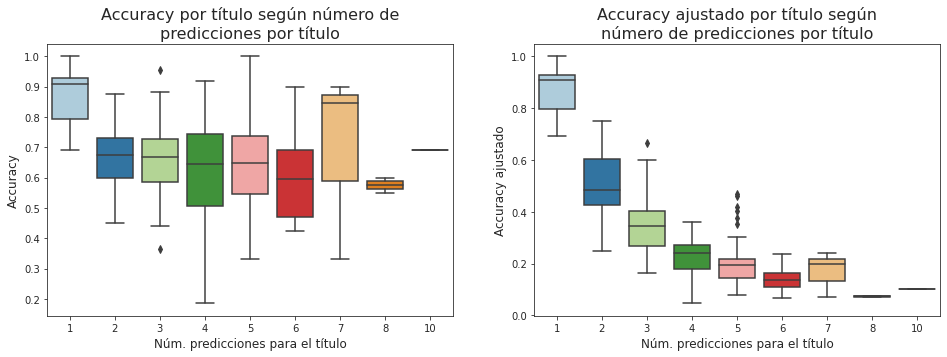

In [132]:
sns.set_style('ticks')

fig, ax= plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    
    sns.boxplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                    x='num pred por regresor',
                    y=col,
                    palette='Paired')
    
    ax[i].set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
    ax[i].set_xticklabels(tick for tick in ax[i].get_xticklabels())
    
    
titulo_0='Accuracy por título según número de predicciones por título'
ax[0].set_title(textwrap.fill(titulo_0,35),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)

titulo_1='Accuracy ajustado por título según número de predicciones por título'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

### Observaciones: 

Aumentar el número de predicciones es equivalente a disponer de más intentos para hacer una predicción acertada. Esto aumenta la probabilidad de acertar en alguno de los intentos sin disminuir la tasa de aciertos (accuracy), ya que una predicción se tiene por acertada cuando contiene un elemento acertado, sin que el resto de títulos predichos cuenten como desaciertos.  

Sin embargo, se observa que el accuracy y el accuracy ajustado por título son menores para las titulaciones con mayor número de predicciones (a menos hasta la sexta predicción). Esto se debe a dos causas:    
   
  - Por un lado, el mayor número de predicciones para un título está asociado a un mayor número de ocupaciones relevantes observadas para sus titulados. Esto indica que son títulos para los que la ocupación es más variable, ya sea porque lo es en la población (y no solo en la muestra de entrenamiento) o porque el título está  poco representado en la muestra, en cuyo caso las ocupaciones infrecuentes individuales están sobrerepresentadas. Esto hace que tanto el accuracy como el accuracy ajustado sean menores para estos títulos. 
  
- Por otro lado, el mayor número de predicciones hace que los aciertos ajustados por la probabilidad tengan menos peso: las probabilidades de las predicciones para el título son menores y los pesos en el accuracy ajustado están mas repartidos (recuérdese que estos pesos suman uno). Esto hace que el accuracy ajustado disminuya más deprisa que el accuracy con el número de predicciones. 

En resumen, aunque hacer más predicciones aumenta la tasa global de aciertos (el accuracy global es mayor que el de una regresión logística con una predicción única por título), la tasa de aciertos para los títulos con dos predicciones es menor que para los títulos con una única predicción porque las predicciones únicas corresponden a títulos con ocupaciones más concentradas (más fáciles de predecir correctamente). En otras palabras, los títulos con dos predicciones aportan menos al accuracy global que los títulos con predicción única.  Esto sigue siendo cierto cuando seguimos aumentando el número de predicciones hasta el punto en el que se ofrecen tantas predicciónes (en nuestro caso, 7) que la tasa de aciertos vuelve a incrementarse porque llegan a representar a casi el total de las ocupaciones observadas en train. 

El efecto es más acusado en el accuracy ajustado porque el mayor número de predicciones se penaliza con puntuaciones o pesos más bajos. Tanto es así que el accuracy ajustado (a diferencia del no ajustado) apenas repunta cuando el número de predicciones es excesivo y se acierta por abuso de intentos. 

## Relación entre métricas de accuracy y número de predicciones por título: inspección de la mediana de la posición de la predicción acertada

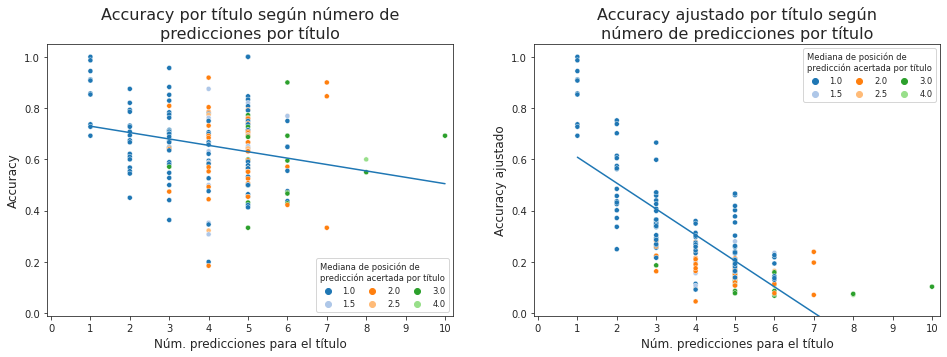

In [133]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    
    sns.regplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y=col,
                ci=False,scatter=False,line_kws={'linewidth':1.5})
    
    sns.scatterplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y=col,hue='mediana posicion acierto por cat regresor',
                palette='tab20',s=25)
    
    ax[i].set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
    ax[i].set_xlim(-0.1,10.2)
    ax[i].set_ylim(-0.01,1.05)
    ax[i].set_xticks(np.arange(0,11,1))

titulo_0='Accuracy por título según número de predicciones por título'
ax[0].set_title(textwrap.fill(titulo_0,35),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)
ax[0].legend(title='Mediana de posición de\npredicción acertada por título',
                 ncol=3,fontsize='small',title_fontsize='small',loc='lower right',columnspacing=1)

titulo_1='Accuracy ajustado por título según número de predicciones por título'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax[1].legend(title='Mediana de posición de\npredicción acertada por título',
             ncol=3,fontsize='small',title_fontsize='small',loc='upper right',columnspacing=1)

fig.subplots_adjust(hspace=.5)
plt.show()

### Observaciones: 

- Las métricas de accuracy para un título disminuyen cuando aumenta el número de ocupaciones predichas para el mismo. Esta relación es más intensa para el accuracy ajustado que para el no ajustado (véanse los valores de los coeficientes de correlación a continuación). 


- La posición de la prediccion acertada más frecuente es la primera. 


- La posición más frecuente de la predicción acertada según el número de predicciones sigue siendo la primera cuando se hacen 2, 3, 4 o 5 predicciones (véase la tabla de medianas de la posición de la predicción acertada según el número de predicciones a continuación). 

Esto sugiere que **es conveniente reducir el número de predicciones por título del clasificador**. Esto tendrá dos efectos claros: 

- Reducirá el accuracy global (in menor número de intentos implica una menor tasa de aciertos porque las predicciones que acompañan a una predicción acertada no computan como desaciertos). 


- Aumentará la precisión (menor número de predicciones desacertadas). 

El efecto sobre el accuracy ajustado global es incierto. Por un lado, se perderán aciertos, lo que reduce el accuracy ajustado, aunque en menor medida que el no ajustado porque los aciertos que se pierden tenían menos peso. Por otro lado, aumentarán los pesos de las predicciones que se conserven, por lo que, cuando sean acertadas, contribuirán a aumentar el accuracy ajustado. 

#### Mediana de posición de la predicción acertada según el número de predicciones:

In [134]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','mediana posicion acierto por cat regresor']]\
            .groupby('num pred por regresor').agg(['value_counts'])

mediana posicion acierto por cat regresor
                                                                                             value_counts
num pred por regresor mediana posicion acierto por cat regresor                                          
1                     1.0                                                                              11
2                     1.0                                                                              17
3                     1.0                                                                              26
                      2.0                                                                               5
                      3.0                                                                               1
4                     1.0                                                                              16
                      2.0                                                                              13
                      1.5                                                                               7
                      2.5                                                                               2
5                     1.0                                                                              21
                      2.0                                                                              18
                      3.0                                                                               7
                      1.5                                                                               4
                      2.5                                                                               2
6                     1.0                                                                               6
                      3.0                                                                               6
                      2.0                                                                               2
                      1.5                                                                               1
                      2.5                                                                               1
                      4.0                                                                               1
7                     2.0                                                                               3
8                     3.0                                                                               1
                      4.0                                                                               1
10                    3.0                                                                               1

#### Correlación negativa entre métricas de accuracy y número de predicciones por título:

In [135]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy regresor']].corr()

,num pred por regresor,accuracy regresor
num pred por regresor,1.000000,-0.245921
accuracy regresor,-0.245921,1.000000


In [136]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy ajustado regresor']].corr()

,num pred por regresor,accuracy ajustado regresor
num pred por regresor,1.000000,-0.768478
accuracy ajustado regresor,-0.768478,1.000000


## Relación entre métricas de accuracy número de ocupaciones observadas por título en train

Se analiza la relación entre el accuracy y el accuracy ajustado por título con la variabilidad de las ocupaciones observadas para el título en el proceso de entrenamiento.

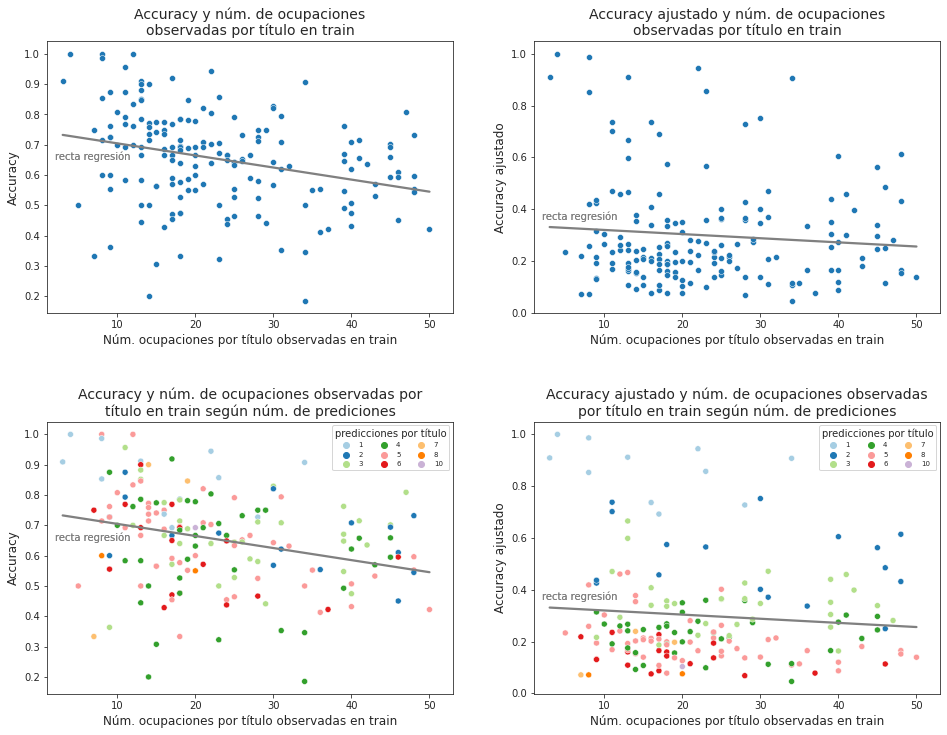

In [137]:
sns.set_style('ticks')

fig, ax = plt.subplots(2, 2,figsize=(16,12))

font_titles=14
font_labels=12
reg_color='gray'

for j,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    for i in [0,1]:
    
        sns.regplot(ax=ax[i,j],data=naive_5_05_evalua_accuracy_vld,
                        x='cat target por regresor (train)',
                        y=col,ci=False, scatter=False,color=reg_color)
        
        ax[i,j].set_xlabel('Núm. ocupaciones por título observadas en train',fontsize=font_labels)
        ax[i,j].set_xlim(1,53)
        ax[i,0].set_ylabel('Accuracy',fontsize=font_labels)
        ax[i,1].set_ylabel('Accuracy ajustado',fontsize=font_labels)
        ax[i,0].text(x=2,y=0.65,s='recta regresión',color=reg_color) 
        ax[i,1].text(x=2,y=0.36,s='recta regresión',color=reg_color)
        
    sns.scatterplot(ax=ax[0,j],data=naive_5_05_evalua_accuracy_vld,
                    x='cat target por regresor (train)',
                    y=col)
        
    sns.scatterplot(ax=ax[1,j],data=naive_5_05_evalua_accuracy_vld,
                    x='cat target por regresor (train)',
                    y=col,
                    hue='num pred por regresor',palette='Paired')
    
    ax[1,j].legend(title='predicciones por título',ncol=3,fontsize='x-small',title_fontsize='medium')
    
     

titulo_00='Accuracy y núm. de ocupaciones observadas por título en train'
ax[0,0].set_title(textwrap.fill(titulo_00,40),fontsize=font_titles) 
        
titulo_01='Accuracy ajustado y núm. de ocupaciones observadas por título en train'
ax[0,1].set_title(textwrap.fill(titulo_01,40),fontsize=font_titles) 

titulo_10='Accuracy y núm. de ocupaciones observadas por título en train según núm. de prediciones'
ax[1,0].set_title(textwrap.fill(titulo_10,50),fontsize=font_titles) 
        
titulo_11='Accuracy ajustado y núm. de ocupaciones observadas por título en train según núm. de prediciones'
ax[1,1].set_title(textwrap.fill(titulo_11,50),fontsize=font_titles)
    

fig.subplots_adjust(hspace=.4)
plt.show()

## Observaciones: 

La relación entre el número de ocupaciones distintas observadas para un título en el proceso de entrenamiento es inversa y de poca intensidad. Es especialmente debil para el accuracy ajustado: 

- Los gráficos que enfrentan las métricas de accuracy con el número de ocupaciones observadas en train por título muestran nubes de puntos dispersas y sin tendencia aparente. 

    - Los gráficos en la primera fila en la figura anterior solo sugieren una relación debil de signo negativo entre el número de ocupaciones observadas en train y las métricas de accuracy. 
    
    - Cuando **distinguimos por número de predicciones para cada título** (los gráficos en la segunda fila de la figura anterior) se observa de nuevo que los títulos para los que se ofrece un menor número de predicciones también son los que tienen puntuaciones de accuracy más altas con mayor frecuencia: la mayoría de los títulos con una o dos predicciones están por encima de las rectas de regresión, mientras que la mayor parte de los que tienen más de cuatro prediciones se situan por debajo. Esto es especialmente claro en el caso del accuracy ajustado. Esto permite concluir que la variable determinante para explicar el accuracy es el número de predicciones, y no el número de ocupaciones observadas en train. 


- Los coeficientes de correlación entre las métricas de accuracy y el número de ocupaciones observadas en train son, en valor absoluto, inferiores a 0.3 y, para el accuracy ajustado, inferior a 0.1 (véanse los valores exactos a continuación). Por tanto, los R² de las regresiones del accuracy y el accuracy ajustado sobre el número de ocupaciones observadas en train son inferiores a 0.09 y 0.01 respectivamente. Esto es, el número de ocupaciones observadas en train explican menos del 10 % del accuracy y menos del 1 % del accuracy ajustado. 







In [138]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy regresor']].corr()

,cat target por regresor (train),accuracy regresor
cat target por regresor (train),1.000000,-0.291412
accuracy regresor,-0.291412,1.000000


In [139]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy ajustado regresor']].corr()

,cat target por regresor (train),accuracy ajustado regresor
cat target por regresor (train),1.000000,-0.090103
accuracy ajustado regresor,-0.090103,1.000000


### Relación entre en el número de predicciones por título y el número de ocupaciones observadas en train: 

A continuación se analiza la relación entre el número de ocupaciones observadas en train para cada título y el número del predicciones para el mismo. Se comprueba que la relación es poco intensa y de signo negativo. 

De nuevo se observa que la relación entre el número de predicciones por título y las métricas de accuracy es más significativa que la que existe entre estas últimas y el número de ocupaciones observadas en el proceso de entrenamiento. 

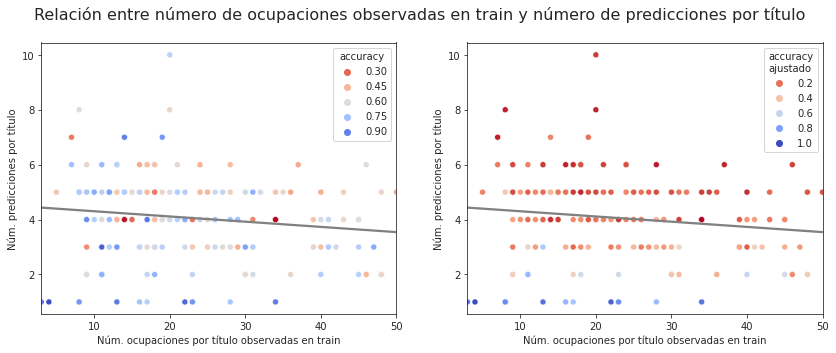

In [140]:
fig, ax = plt.subplots(1, 2,figsize=(14,5))

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):

    sns.regplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='num pred por regresor',
                ci=False,scatter=False, color='grey')

    sns.scatterplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                    x='cat target por regresor (train)',
                    y='num pred por regresor',
                    hue=col,
                    palette=sns.color_palette('coolwarm', as_cmap=True).reversed())
    ax[i].set_xlabel('Núm. ocupaciones por título observadas en train')
    ax[i].set_ylabel('Núm. predicciones por título')

titulo='Relación entre número de ocupaciones observadas en train y número de predicciones por título'
plt.suptitle(textwrap.fill(titulo,100),fontsize=16)

ax[0].legend(title='accuracy')
ax[1].legend(title='accuracy\najustado')

plt.show()

In [141]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','num pred por regresor']].corr()

,cat target por regresor (train),num pred por regresor
cat target por regresor (train),1.000000,-0.140763
num pred por regresor,-0.140763,1.000000


## Métricas de accuracy ponderadas por el peso de las titulaciones

Para la agregación global de las metricas de accuracy, los valores por título se ponderan de acuerdo con el peso de cada título en el conjunto de validación.

In [142]:
# Auxiliar para plot: títulos para ilustrar efecto ajuste en accuracy ponderado
tt_acc=list()

aux_acc=naive_5_05_evalua_accuracy_vld
aux_acc=aux_acc[aux_acc.index.isin(destaca_titulos)]

for i, tt in enumerate(aux_acc.index):
    titulo=aux_acc.index[i]
    titulo=titulo.split(' ',1)[0][0]+' '+titulo.split(' ',1)[1]
    x=aux_acc['num obs regresor'].iloc[i]
    y=aux_acc['accuracy ponderado regresor'].iloc[i]
    tt_acc.append((x,y,titulo))
#tt_acc

In [143]:
# Auxiliar para plot: títulos destacados para ilustrar el efecto del ajuste en accuracy ponderado
tt_acc_ajustado=list() 

for tt in aux_acc.index:
    titulo=tt.split(' ',1)[0][0]+' '+tt.split(' ',1)[1]
    x=aux_acc['num obs regresor'].loc[tt]
    y=aux_acc['accuracy ajustado ponderado regresor'].loc[tt]
    tt_acc_ajustado.append((x,y,titulo))
#tt_acc_ajustado

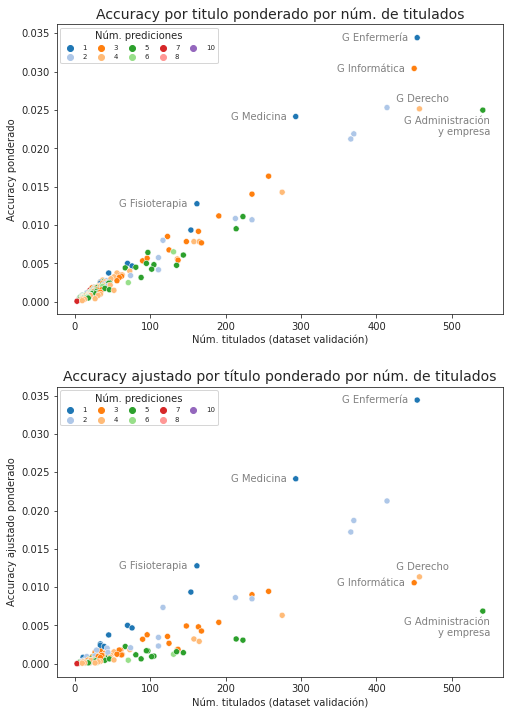

In [144]:
sns.set_style('ticks')

fig, ax = plt.subplots(2, 1,figsize=(8,12))
font_titles=14
font_labels=10


for i, col in enumerate(['accuracy ponderado regresor','accuracy ajustado ponderado regresor']):

    sns.scatterplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                    x='num obs regresor',
                    y=col,
                    hue='num pred por regresor',palette='tab20')
    ax[i].set_xlabel('Núm. titulados (dataset validación)',fontsize=font_labels)
    ax[i].legend(title='Núm. prediciones',ncol=5,fontsize='x-small',title_fontsize='medium',columnspacing=1)
    
titulo_0='Accuracy por titulo ponderado por núm. de titulados'
ax[0].set_title(textwrap.fill(titulo_0,60),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy ponderado',fontsize=font_labels)
    
titulo_1='Accuracy ajustado por título ponderado por núm. de titulados'
ax[1].set_title(textwrap.fill(titulo_1,60),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado ponderado',fontsize=font_labels)
    
for tt in tt_acc:
    if tt[2]=='G Administración y empresa':
        texto=tt[2].split(' ',2)[0]+' '+tt[2].split(' ',2)[1]+'\n'+tt[2].split(' ',2)[2]
        ax[0].text(x=tt[0]+10,y=tt[1]-0.0007,s=texto,va='top',ha='right',color='grey')
    elif tt[2]=='G Derecho':
        ax[0].text(x=tt[0],y=tt[1]+0.0007,s='  '+tt[2],va='bottom',ha='center',color='grey')   
    else: 
        ax[0].text(x=tt[0],y=tt[1],s=tt[2]+'   ',ha='right',va='center',color='grey')

for tt in tt_acc_ajustado:
    if tt[2]=='G Administración y empresa':
        texto=tt[2].split(' ',2)[0]+' '+tt[2].split(' ',2)[1]+'\n'+tt[2].split(' ',2)[2]
        ax[1].text(x=tt[0]+10,y=tt[1]-0.0007,s=texto,va='top',ha='right',color='grey')
    elif tt[2]=='G Derecho':
        ax[1].text(x=tt[0],y=tt[1]+0.0007,s='  '+tt[2],va='bottom',ha='center',color='grey') 
    else: 
        ax[1].text(x=tt[0],y=tt[1],s=tt[2]+'   ',ha='right',va='center',color='grey')

fig.subplots_adjust(hspace=.25)
plt.show()

### Observaciones: 

El efecto de las ponderaciones es más intenso en el accuracy no ajustado que en el ajustado:

- El accuracy ponderado de los títulos está muy determinado por el peso de sus titulados en el conjunto de validación. 


- En el accuracy ajustado ponderado se aprecia que algunas de las titulaciones con más peso por número de titulados también tienen mucha variabilidad en las ocupaciones observadas. Es el caso de los **grados en Derecho, en Administración y empresa o en Informática**. Su tasa de acierto se explica por la multiplicidad de predicciones para el título (hasta 5). El accuracy ajustado penaliza el exceso de predicciones. Esto compensa el peso de estos títulos por número de titulados. 

# Métricas de accuracy: conclusiones

In [145]:
columnas=['obs regresor (train)','num obs regresor','peso regresor','cat target por regresor (train)',
          'num pred por regresor']
acc_corr=naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor']+columnas]
acc_corr.rename(columns={'accuracy regresor':'Accuracy',
                         'accuracy ajustado regresor':'Accuracy ajustado',
                         'obs regresor (train)':'Núm. encuestados por tt (train)',
                         'num obs regresor':'Núm. obs. por tt (validación',
                         'peso regresor':'Peso tt (validación)',
                         'cat target por regresor (train)':'Núm ocupaciones por tt (train)',
                         'num pred por regresor':'Núm. predicciones por tt'},inplace=True)
correlaciones_accuracy=acc_corr.corr()
correlaciones_accuracy

,Accuracy,Accuracy ajustado,Núm. encuestados por tt (train),Núm. obs. por tt (validación,Peso tt (validación),Núm ocupaciones por tt (train),Núm. predicciones por tt
Accuracy,1.000000,0.606395,0.073580,0.076986,0.076986,-0.291412,-0.245921
Accuracy ajustado,0.606395,1.000000,0.277654,0.274887,0.274887,-0.090103,-0.768478
Núm. encuestados por tt (train),0.073580,0.277654,1.000000,0.998328,0.998328,0.716649,-0.317988
Núm. obs. por tt (validación,0.076986,0.274887,0.998328,1.000000,1.000000,0.707941,-0.313632
Peso tt (validación),0.076986,0.274887,0.998328,1.000000,1.000000,0.707941,-0.313632
Núm ocupaciones por tt (train),-0.291412,-0.090103,0.716649,0.707941,0.707941,1.000000,-0.140763
Núm. predicciones por tt,-0.245921,-0.768478,-0.317988,-0.313632,-0.313632,-0.140763,1.000000


La tabla de coeficientes de correlación entre las métricas de accuracy y accuracy ajustado resume las principales conclusiones del análisis descriptivo del rendimiento del clasificador en cuanto a sus tasas de acierto por título: 

- El **número de titulados encuestados** en train, el de observaciones en validación y los pesos por número de titulados tienen una relación debil y positiva en las medidas de accuracy. La intensidad de esta relación es algo mayor para el accuracy ajustado. 
     
    - La baja correlación del número o la proporción de titulados con el accuracy no ajustado indica que el número de titulados de cada titulo influye poco en la tasa de aciertos de las predicciones que se ofrecen para el mismo: cuando la variabilidad en las ocupaciones representativas observadas es alta debido a que la muestra es pequeña, el clasificador ofrece un mayor número de predicciones. Gracias a ello consigue una tasa de aciertos similar al promedio incluso con muestras pequeñas. 
    - La correlación es más intensa para el accuracy ajustado porque este penaliza el exceso de predicciones, más frecuente cuando el número de encuestados es pequeño: mientras que la tasa de aciertos para muestras pequeñas se mantiene similar al promedio gracias al aumento del número de predicciones, la tasa ajustada por probabilidades desciende debido a la penalización por el mayor número de predicciones.  
    - La correlación entre los números de titulados en train y en test es casi uno porque las proporciones en las que están representados los títulos en los dos conjuntos son muy similares. La correlación exacta entre el número de titulados en validación y los pesos de los títulos se debe a que los pesos son iguales a las proporciones relativas en validación. 


- El **número de ocupaciones distintas para cada título observadas en train** tiene una relación inversa con las métricas de accuracy, más intensa en el caso del accuracy no ajustado. El número de ocupaciones distintas observadas en train ofrece una medida imperfecta de la variabilidad de las ocupaciones profesionales asociadas a cada título. Es imperfecta porque recoge todas las ocupaciones registradas con independencia de su frecuencia, por lo que crece indefectiblemente con el número de titulados encuestados. Por ello, no es un buen indicador del número de ocupaciones representativas (*). 


- El **número de predicciones por título** es una medida de la variabilidad de las ocupaciones asociadas al título más afinada que el número de ocupaciones distintas: para que una ocupación observada se convierta en predicción debe estar en una posición suficientemente alta en el ranking de frecuencias y superar un umbral de frecuencia mínima. El número de predicciones por título se puede interpretar, por tanto, como el **número de ocupaciones representativas distintas**. Tiene una relación inversa con las dos métricas de accuracy. Esta relación es especialmente intensa en el caso del accuracy ajustado (cercana a 0.8 en valor absoluto). Es, por tanto, la variable más significativa para explicar la tasa ajustada de aciertos del clasificador. 
    - La correlación negativa entre el número de predicciones y el accuracy no ajustado indica que los títulos para los que se ofrecen más predicciones son también los títulos con las ocupaciones representativas más variadas, esto es, los títulos para los que es más difícil hacer predicciones acertadas. 
    - La correlación entre el número de predicciones y el accuracy es más intensa para el accuracy ajustado porque a la dificultad de acierto asociada a la multiplicidad de predicciones se suma que el accuracy ajustado asigna puntuaciones más bajas a los aciertos alcanzados con un mayor número de predicciones. 
    - La correlación negativa y poco intensa entre el número de ocupaciones observadas y el número de predicciones indica que, en promedio, los títulos con muchas ocupaciones observadas distintas tienen menos ocupaciones representativas que aquellos con menos variabilidad en las ocupaciones. Esta relación se produce a través del número de encuestados: a mayor número de observaciones, mayor número de ocupaciones distintas registradas y, también, menor peso individual de las ocupaciones más infrecuentes. Así, a mayor número de observaciones, mayor número de ocupaciones distintas y menor número de observaciones representativas distintas.  
    
(*) Los grados en Medicina, en Enfermería y en Derecho ilustran bien la escasa capacidad del número de ocupaciones distintas en train para explicar la tasa de aciertos: el grado en Enfermería tiene un número de titulados y de ocupaciones distintas en train similar al grado en Derecho, muy superiores a los registrados para el grado en Medicina. Sin embargo, con una única ocupación predicha para Enfermería y para Medicina, las tasas de acierto en ambos casos son similares y superiores a 0.9. Esto indica que todas las ocupaciones registradas en train para el grado en Enfermería son poco relevantes salvo la de 'Profesionales sanitarios'. En el otro extremo, el clasificador ofrece 4 ocupaciones como predicción para el grado en Derecho, con unos resultados de accuracy y, sobre todo, de accuracy ajustado muy inferiores. 

# 7.2. Métricas de evaluación: recall

In [146]:
def naive_evalua_recall(clasificador,data):
    
    """ Recupera la información de la evaluación relativa al recall desagregado por ocupaciones observadas en 
    validación y prescinde del detalle observación a observación. 
    """
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_target=list(filter(lambda col: re.search('.*target.*',col),evalua.columns))
    lista_re_target=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_target))
    
    evalua=evalua[lista_re_target].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='recall target',ascending=False,inplace=True)

    return evalua

In [147]:
naive_5_05_evalua_recall_vld=naive_evalua_recall(clasificador=naive_5_05_train,data=df_vld)

In [148]:
naive_5_05_evalua_recall_vld.shape, df_vld['ocupacion_'].nunique() # Comprobación

((62, 10), 62)

In [149]:
naive_5_05_evalua_recall_vld.head()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target,mediana posicion acierto por cat target,mediana num pred por cat target
target: ocupacion_,,,,,,,,,,
Profesionales sanitarios,1494,1398,1294.262592,0.935743,0.866307,0.124822,0.116802,0.108135,1.0,1.0
"Profesionales de las ciencias, matemáticas e ingeniería",1540,1438,908.192595,0.933766,0.589735,0.128666,0.120144,0.075879,1.0,3.0
Profesionales de la enseñanza,1953,1799,1197.750864,0.921147,0.613288,0.163172,0.150305,0.100071,1.0,3.0
Profesionales del derecho,303,259,152.403482,0.854785,0.502982,0.025315,0.021639,0.012733,1.0,4.0
Técnicos ciencias e ingenierías,443,361,89.127050,0.814898,0.201190,0.037012,0.030161,0.007446,2.0,3.0


In [150]:
naive_5_05_evalua_recall_vld.tail()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target,mediana posicion acierto por cat target,mediana num pred por cat target
target: ocupacion_,,,,,,,,,,
Gerentes en servicios excepto hostelería y comercio,34,0,0.0,0.0,0.0,0.002841,0.0,0.0,NaN,4.0
"Peones de transporte, descargadores y reponedores",28,0,0.0,0.0,0.0,0.002339,0.0,0.0,NaN,3.0
Trabajadores servicios de cuidados no de salud,58,0,0.0,0.0,0.0,0.004846,0.0,0.0,NaN,2.5
"Soldadores, chapistas, montadores de estructuras",4,0,0.0,0.0,0.0,0.000334,0.0,0.0,NaN,3.0
"Mecánicos de precisión, artesanos y artes gráficas",6,0,0.0,0.0,0.0,0.000501,0.0,0.0,NaN,5.0


In [151]:
#with pd.option_context('display.max_rows', naive_5_05_evalua_recall_vld.shape[0]):
#    display(naive_5_05_evalua_recall_vld)

## Distribución de las métricas de recall por títulos

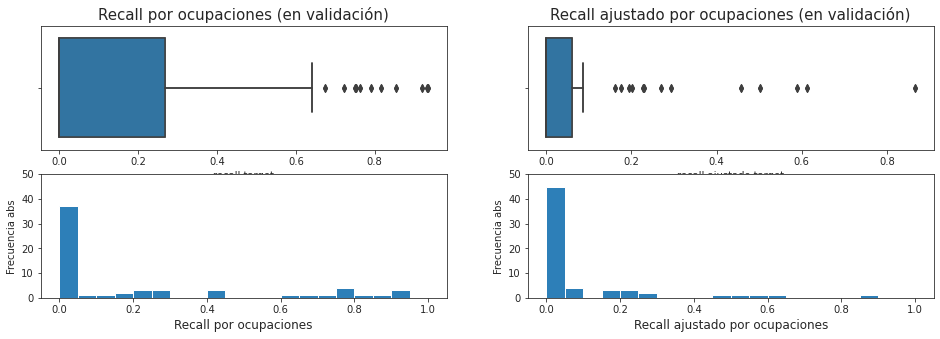

In [152]:
sns.set_style('ticks')

fig, ax = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

data=naive_5_05_evalua_recall_vld

for j,col in enumerate(['recall target','recall ajustado target']):
    for i in [0,1]:

        sns.boxplot(ax=ax[0,j],data=data,x=col)
        ax[0,0].set_title('Recall por ocupaciones (en validación)',fontsize=font_titles)
        ax[0,1].set_title('Recall ajustado por ocupaciones (en validación)',fontsize=font_titles)
        ax[i,j].set_xlabel('')

        sns.histplot(ax=ax[1,j],data=data,x=col,bins=np.arange(0,1.05,0.05))
        ax[1,0].set_xlabel('Recall por ocupaciones',fontsize=font_labels)
        ax[1,1].set_xlabel('Recall ajustado por ocupaciones',fontsize=font_labels)
        ax[1,j].set_ylim(0,50)
        ax[1,j].set_ylabel('Frecuencia abs')

fig.subplots_adjust(hspace=.2)
plt.show()

## Las 10 ocupaciones con mejor recall

In [153]:
top_10_r=naive_5_05_evalua_recall_vld[['recall target','recall ajustado target','mediana num pred por cat target']]
top_10_r.rename(columns={'recall target':'recall','recall ajustado target':'recall ajustado',
                      'mediana num pred por cat target':'mediana núm. predicciones'},inplace=True)
for col in ['recall','recall ajustado']:
    aux_rank=pd.DataFrame(top_10_r[col].rank(ascending=False, method='min'))
    aux_rank.rename(columns={col:'rank '+str(col)},inplace=True)
    top_10_r=top_10_r.merge(aux_rank,left_index=True,right_index=True)
    top_10_r['rank '+str(col)]=top_10_r['rank '+str(col)].astype(int)
top_10_rcll=top_10_r.sort_values(by='recall',ascending=False).head(10)
top_10_rcll.index.rename('Ocupaciones ordenadas por recall: top 10',inplace=True)
top_10_rcll

,recall,recall ajustado,mediana núm. predicciones,rank recall,rank recall ajustado
Ocupaciones ordenadas por recall: top 10,,,,,
Profesionales sanitarios,0.935743,0.866307,1.0,1,1
"Profesionales de las ciencias, matemáticas e ingeniería",0.933766,0.589735,3.0,2,3
Profesionales de la enseñanza,0.921147,0.613288,3.0,3,2
Profesionales del derecho,0.854785,0.502982,4.0,4,4
Técnicos ciencias e ingenierías,0.814898,0.201190,3.0,5,10
Profesionales de las ciencias sociales,0.790646,0.457241,4.0,6,5
"Empleados servicios financieros, contables y de apoyo",0.762089,0.291828,5.0,7,6
Técnicos TI,0.752239,0.227983,3.0,8,9
Profesionales IT,0.750000,0.230032,3.0,9,8


In [154]:
top_10_r_ajtd=top_10_r.sort_values(by='recall ajustado',ascending=False).head(10)
top_10_r_ajtd.index.rename('Ocupaciones ordenadas por recall ajustado: top 10',inplace=True)
top_10_r_ajtd

,recall,recall ajustado,mediana núm. predicciones,rank recall,rank recall ajustado
Ocupaciones ordenadas por recall ajustado: top 10,,,,,
Profesionales sanitarios,0.935743,0.866307,1.0,1,1
Profesionales de la enseñanza,0.921147,0.613288,3.0,3,2
"Profesionales de las ciencias, matemáticas e ingeniería",0.933766,0.589735,3.0,2,3
Profesionales del derecho,0.854785,0.502982,4.0,4,4
Profesionales de las ciencias sociales,0.790646,0.457241,4.0,6,5
"Empleados servicios financieros, contables y de apoyo",0.762089,0.291828,5.0,7,6
Profesionales de la cultura y el espectáculo,0.723214,0.268557,4.0,10,7
Profesionales IT,0.750000,0.230032,3.0,9,8
Técnicos TI,0.752239,0.227983,3.0,8,9


### Observaciones: 

- Las 10 ocupaciones con mayor recall son también las 10 ocupaciones con mejor recall ajustado. Las diferencias enre una relación y otra son solo de posiciones de las oupaciones en los dos rankings. 

- Solo una ocupación, la de **profesionales sanitarios**, entre las de mejores métricas de recall con una mediana de precicciones igual a uno. Esto indica que, al menos para la mitad de las observaciones para las que se predice la ocupación de profesionales sanitarios, esta se ofrece como predicción única. A pesar de ello, la de profesionales sanitarios es la predicción con el mayor recall que alcanza el clasificador. Esta ocupación es, de hecho, la única para la que la mediana del número de predicciones es uno. 

## El número de observaciones en train y la mediana del número de predicciones por ocupación

La **mediana del número de predicciones para una ocupación** representa el valor mediano del número de predicciones que se ofrecen a los titulados que tienen esta ocupación como profesión. Este número de predicciones está determinado por tu titulación, y no por su ocupación. 

Así, la mediana del número de predicciones unitaria para los profesionales sanitarios indica que al menos la mitad de los titulados para los que se predice una profesión sanitaria reciben una predicción única, en este caso, con una tasa de aciertos muy elevada. Son profesiones para las que la formación es muy específica para las funciones para las que cualifica. 

En el otro extremo, el máximo valor de la mediana del número de predicciones por ocupación es 5. Corresponde a profesiones a las que es posible acceder con varias titulaciones diferentes, lo que dificulta la predicción.  

Se observan algunas profesiones (registradas en validación) con una mediana del número de prediciones pequeña (entre 2.5 y 3) para los que la tasa de aciertos es nula. Son profesiones para los que el número de profesionales observados en train también es pequeña (inferior a 200). Es decir, son profesiones poco representadas en el conjunto de entrenamiento, por lo que es probable que no se ofrezcan como predicción para ningún título, lo que explica sus métricas de recall nulas. Esto se analiza con más rigor en el estudio descriptivo del rendimiento del clasificador en cuanto a las métricas de precisión, para el que se recopila información sobre la frecuencia con la que se predice cada ocupación.  

In [155]:
# Se añaden a los resultados de evaluación de recall el número de observaciones en train para cada ocupación: 
obs_target=pd.DataFrame(df_train['ocupacion_'].value_counts())
obs_target.rename(columns={'ocupacion_':'num obs (train)'},inplace=True)
naive_5_05_evalua_recall_vld=naive_5_05_evalua_recall_vld.merge(obs_target,right_index=True,left_index=True)
naive_5_05_evalua_recall_vld.sample()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target,mediana posicion acierto por cat target,mediana num pred por cat target,num obs (train)
Vendedores excepto comercio,33,0,0.0,0.0,0.0,0.002757,0.0,0.0,NaN,5.0,112


In [156]:
# Inspección de la mediana del número de predicciones por ocupaciones predichas: 
inspecciona_mediana_pred=naive_5_05_evalua_recall_vld[['recall target','recall ajustado target',
                                                       'mediana num pred por cat target','num obs (train)']]
inspecciona_mediana_pred.sort_values(by=['mediana num pred por cat target','num obs (train)'],inplace=True)
inspecciona_mediana_pred.head(30)

,recall target,recall ajustado target,mediana num pred por cat target,num obs (train)
Profesionales sanitarios,0.935743,0.866307,1.0,4569
Trabajadores cualificados ganadería,0.000000,0.000000,2.0,17
Trabajadores servicios de cuidados de salud,0.000000,0.000000,2.0,181
Peones de construcción y minería,0.000000,0.000000,2.5,20
Trabajadores servicios de cuidados no de salud,0.000000,0.000000,2.5,200
Empleados domésticos,0.000000,0.000000,3.0,7
"Trabajadores cualif act forestales, pesqueras, cinegéticas",0.000000,0.000000,3.0,12
Montadores y ensambladores en fábricas,0.000000,0.000000,3.0,14
"Soldadores, chapistas, montadores de estructuras",0.000000,0.000000,3.0,19
"Trabajadores madera, textil, confección, piel y cuero",0.000000,0.000000,3.0,20


### Observación

- Las profesiones sanitarias son las únicas que, con una mediana del número de predicciones inferior a 3, tienen un número de observaciones en train representativo. El valor mínimo del número de predicciones se debe a que las profesiones sanitarias solo se ofrecen como predicción a los titulados con una formación, la relacionada con la salud, que es muy especializada, imprescindible para las ocupaciones que le son propias y poco versátil para acceder a puestos de trabajo fuera de ese campo. 


- Para el resto de ocupaciones con una mediana del número de predicciones inferior a 3 se registra un número de observaciones en train menor o igual a 200 y unas tasas de recall nulas. Son profesiones poco representadas en la muestra debido a que la formación necesaria para ejercerlas no es universitaria. Esto sugiere que el título universitario de los encuestados con estas profesiones no proporciona información útil para predecirlas. 

In [157]:
# Ocupaciones con más observaciones en train (auxiliar para plot): 
oc_observaciones=naive_5_05_evalua_recall_vld[naive_5_05_evalua_recall_vld['num obs (train)']>4000].index

list_oc_obs=list()
for oc in oc_observaciones:
    x=naive_5_05_evalua_recall_vld['num obs (train)'].loc[oc]
    y=naive_5_05_evalua_recall_vld['mediana num pred por cat target'].loc[oc]
    oc=oc.replace(' de las','\n')
    oc=oc.replace(' de la','\n')
    oc=oc.replace(' e ','\ne ')
    list_oc_obs.append((x,y,oc))
list_oc_obs

[(4569, 1.0, 'Profesionales sanitarios'),
 (4669, 3.0, 'Profesionales\n ciencias, matemáticas\ne ingeniería'),
 (5867, 3.0, 'Profesionales\n enseñanza')]

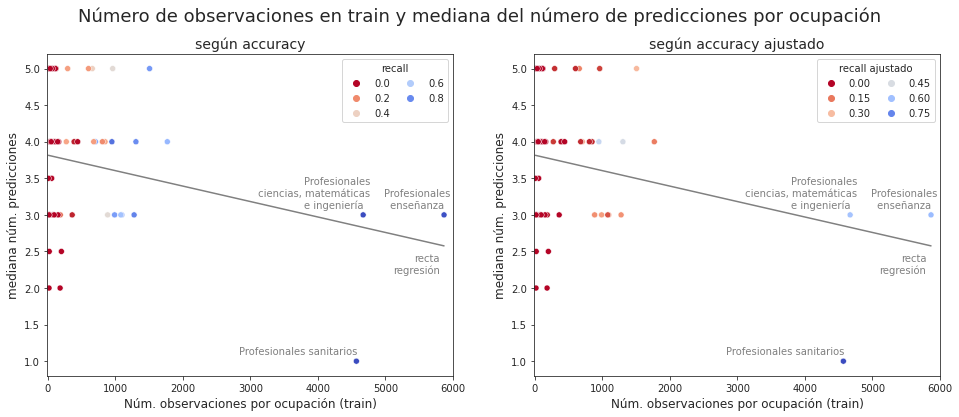

In [158]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,6))
font_titles=14
font_labels=12

data=naive_5_05_evalua_recall_vld[['recall target','recall ajustado target','num obs (train)',
                                  'mediana num pred por cat target']]
data.rename(columns={'recall target':'recall','recall ajustado target':'recall ajustado'},inplace=True)

for i,col in enumerate(['recall','recall ajustado']):

    sns.scatterplot(ax=ax[i],data=data,
                    x='num obs (train)',
                    y='mediana num pred por cat target', 
                    hue=col,palette=sns.color_palette('coolwarm', as_cmap=True).reversed())
    
    sns.regplot(ax=ax[i],data=data,
                x='num obs (train)',
                y='mediana num pred por cat target',
                ci=False, scatter=False,color='gray',line_kws={'linewidth':1.5})
    
    ax[i].set_xlabel('Núm. observaciones por ocupación (train)',fontsize=font_labels)
    ax[i].set_xlim(-10,6000)
    ax[i].text(x=5800,y=2.2,s='recta\nregresión',color='gray',ha='right')
    ax[i].set_ylabel('mediana núm. predicciones',fontsize=font_labels)
    ax[0].set_title('según accuracy',fontsize=font_titles)
    ax[1].set_title('según accuracy ajustado',fontsize=font_titles)
    ax[i].legend(title=str(col),ncol=2,columnspacing=1)    
    for oc in list_oc_obs:
        ax[i].text(x=oc[0]+100, y=oc[1]+0.09, s=oc[2]+'  ', ha='right',color='gray')
    
fig.suptitle('Número de observaciones en train y mediana del número de predicciones por ocupación',fontsize=18)

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(top=0.87)
    
plt.show()

### Observaciones: 

- Se aprecia una relación inversa y poco intensa entre el número de observaciones en train y la mediana del número de predicciones para cada ocupación (véase el coeficiente de correlación a continuación). 


- Se aprecia también una relación directa entre el número de observaciones en train y las métricas de recall. Los coeficientes de correlación indican que esta relación es más intensa para el recall ajustado que para el no ajustado (véanse los valores exactos a continuación). 


- Se observa una relación inversa entre las métricas de recall y la mediana del número de predicciones. Es más intensa para el recall ajustado que para el no ajustado (véanse las correlaciones exactas a continuación). 

In [159]:
naive_5_05_evalua_recall_vld[['recall target','recall ajustado target','num obs (train)',
                              'mediana num pred por cat target']].corr()

,recall target,recall ajustado target,num obs (train),mediana num pred por cat target
recall target,1.000000,0.873850,0.780257,-0.123312
recall ajustado target,0.873850,1.000000,0.881591,-0.259733
num obs (train),0.780257,0.881591,1.000000,-0.258640
mediana num pred por cat target,-0.123312,-0.259733,-0.258640,1.000000


## Recall, número de profesionales en validación, número de predicciones y posición de la predicción acertada

In [160]:
# Ocupaciones con recall superior a 0.5 (aux para destacar ocupaciones en plot):

oc_recall=list()
oc_recall_ajtd=list()

mayor_recall=naive_5_05_evalua_recall_vld[naive_5_05_evalua_recall_vld['recall target']>0.5]
ocupaciones=mayor_recall.index

for occ in ocupaciones:
    ocupacion=occ+'  '
    x=mayor_recall['num obs target'].loc[occ]
    y_recall=mayor_recall['recall target'].loc[occ]
    oc_recall.append((x,y_recall,ocupacion))
    y_recall_ajtd=mayor_recall['recall ajustado target'].loc[occ]
    oc_recall_ajtd.append((x,y_recall_ajtd,ocupacion))
    
#oc_recall, oc_recall_ajtd

In [161]:
# Diccionario para size según posición mediana del acierto en plot: 

medianas_posicion=naive_5_05_evalua_recall_vld['mediana posicion acierto por cat target'].unique()
sizes_num={1:70,2:35}
sizes=dict(zip(medianas_posicion,[10]*len(medianas_posicion)))

sizes.update(sizes_num)
sizes

{1.0: 70, 2.0: 35, 3.0: 10, 4.0: 10, 6.0: 10, 3.5: 10, nan: 10}

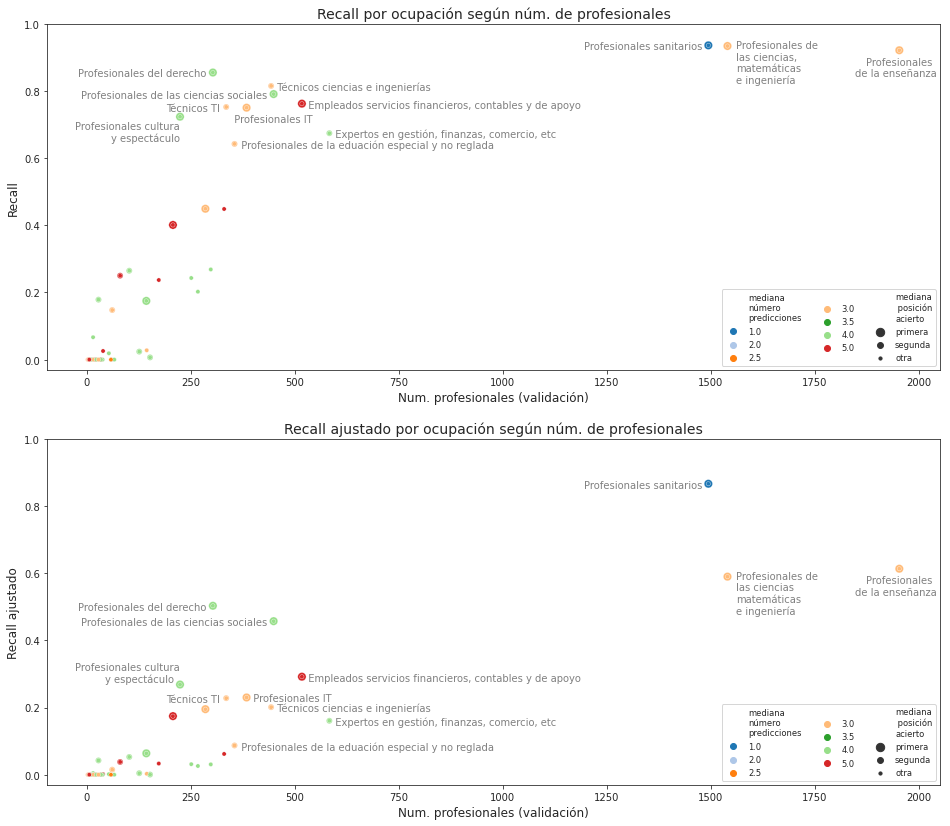

In [162]:
sns.set_style('ticks')

fig, ax = plt.subplots(2, 1,figsize=(16,14))
font_titles=14
font_labels=12

data=naive_5_05_evalua_recall_vld


for i,col in enumerate(['recall target','recall ajustado target']):
    
    sns.scatterplot(ax=ax[i],data=data,
                    x='num obs target',
                    y=col,
                    hue='mediana num pred por cat target',palette='tab20',
                    size='mediana posicion acierto por cat target',sizes=sizes)

    # Scatter completo (con size variable (anterior) la concentración en torno al origen queda difuminada)
    sns.scatterplot(ax=ax[i],data=data,
                    x='num obs target',
                    y=col,
                    hue='mediana num pred por cat target',palette='tab20',
                    size=10,legend=False)
    
    ax[i].set_xlabel('Num. profesionales (validación)',fontsize=font_labels)
    ax[i].set_ylim(-0.03,1)
    
    # Edición de leyenda: 
    handles=ax[i].get_legend_handles_labels()[0]
    labels=ax[i].get_legend_handles_labels()[1]
    
    new_handles=handles[0:12]
    new_labels=['mediana\nnúmero\npredicciones']+labels[1:8]\
                +['mediana\n posición\nacierto','primera','segunda','otra']
    
    ax[i].legend(ncol=3,loc='lower right',fontsize='small',handles=new_handles, labels=new_labels)
    
ax[0].set_title('Recall por ocupación según núm. de profesionales',fontsize=font_titles)
ax[0].set_ylabel('Recall',fontsize=font_labels)

ax[1].set_title('Recall ajustado por ocupación según núm. de profesionales',fontsize=font_titles)
ax[1].set_ylabel('Recall ajustado',fontsize=font_labels)

# Ocupaciones con recall superior a 0.5:
for occ in oc_recall: 
    if occ[2]=='Profesionales de las ciencias, matemáticas e ingeniería  ':
        texto='Profesionales de\nlas ciencias,\nmatemáticas\ne ingeniería'
        ax[0].text(x=occ[0]+20,y=occ[1]-0.05,s=texto,ha='left',va='center',color='grey')
    elif occ[2] in ['Técnicos ciencias e ingenierías  ',
                    'Empleados servicios financieros, contables y de apoyo  ',
                    'Profesionales de la eduación especial y no reglada  ',
                    'Expertos en gestión, finanzas, comercio, etc  ']:
        ax[0].text(x=occ[0],y=occ[1],s='  '+occ[2],ha='left',va='center_baseline',color='grey')
    elif occ[2] in ['Profesionales de la enseñanza  ']:
        texto=occ[2].split(' ',1)[0]+'\n'+occ[2].split(' ',1)[1]
        ax[0].text(x=occ[0],y=occ[1]-0.02,s=texto,ha='center',va='top',color='grey')
    elif occ[2] in ['Profesionales IT  ']:
        ax[0].text(x=occ[0]-45,y=occ[1]-0.03,s='  '+occ[2],ha='left',va='center_baseline',color='grey')
    elif occ[2] in ['Profesionales de la cultura y el espectáculo  ']:
        texto='Profesionales cultura\ny espectáculo'
        ax[0].text(x=occ[0],y=occ[1]-0.04,s=texto,ha='right',va='center_baseline',color='grey')
    else: 
        ax[0].text(x=occ[0],y=occ[1],s=occ[2],ha='right',va='center_baseline',color='grey')
for occ in oc_recall_ajtd: 
    if occ[2]=='Profesionales de las ciencias, matemáticas e ingeniería  ':
        texto='Profesionales de\nlas ciencias\nmatemáticas\ne ingeniería'
        ax[1].text(x=occ[0]+20,y=occ[1]-0.05,s=texto,ha='left',va='center',color='grey')
    elif occ[2] in ['Técnicos ciencias e ingenierías  ',
                    'Empleados servicios financieros, contables y de apoyo  ',
                    'Profesionales de la eduación especial y no reglada  ',
                    'Profesionales IT  ',
                    'Expertos en gestión, finanzas, comercio, etc  ']:
        ax[1].text(x=occ[0],y=occ[1],s='  '+occ[2],ha='left',va='center_baseline',color='grey')
    elif occ[2] in ['Profesionales de la enseñanza  ']:
        texto=occ[2].split(' ',1)[0]+'\n'+occ[2].split(' ',1)[1]
        ax[1].text(x=occ[0],y=occ[1]-0.02,s=texto,ha='center',va='top',color='grey')
    elif occ[2] in ['Profesionales de la cultura y el espectáculo  ']:
        texto='Profesionales cultura\ny espectáculo  '
        ax[1].text(x=occ[0],y=occ[1]+0.04,s=texto,ha='right',va='center_baseline',color='grey')
    else: 
        ax[1].text(x=occ[0],y=occ[1],s=occ[2],ha='right',va='center_baseline',color='grey')

fig.subplots_adjust(hspace=.2)

plt.show()

In [163]:
naive_5_05_evalua_recall_vld[['recall target','recall ajustado target','num obs (train)','num obs target']].corr()

,recall target,recall ajustado target,num obs (train),num obs target
recall target,1.000000,0.873850,0.780257,0.782584
recall ajustado target,0.873850,1.000000,0.881591,0.879380
num obs (train),0.780257,0.881591,1.000000,0.999586
num obs target,0.782584,0.879380,0.999586,1.000000


### Observaciones: 

- Se constata de nuevo la relación directa entre el número de observaciones, en este caso en validación, y las métricas de recall. Todas las ocupaciones con recall inferior a 0.5 tienen menos de 500 observaciones en validación. 


- Para todas las ocupaciones con recall superior a 0.5 la mediana de la posición de la predicción acertada es la primera o la segunda. De nuevo, esto es una invitación a reducir el número de predicciones que ofrece el clasificador. 


- Cuanto mayor es el número de predicciones y cuanto más alejada de la primera es la posición de la predicción acertada, mayor es la penalización registrada en el accuracy ajustado respecto al no ajustado. 


- Se observan muchas ocupaciones con recal nulo o casi nulo. Esto requirere un análisis específico. 

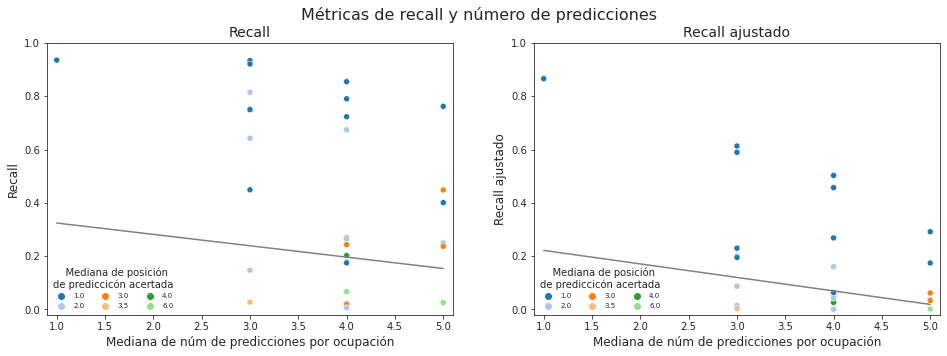

In [164]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

data=naive_5_05_evalua_recall_vld

for i,col in enumerate(['recall target','recall ajustado target']):

    sns.scatterplot(ax=ax[i],data=data,
                    x='mediana num pred por cat target',
                    y=col,
                    hue='mediana posicion acierto por cat target',palette='tab20')
    sns.regplot(ax=ax[i],data=data,
                    x='mediana num pred por cat target',
                    y=col,
                    ci=False, scatter=False, color='gray',line_kws={'linewidth':1.5})
    
    ax[i].set_xlabel('Mediana de núm de predicciones por ocupación',fontsize=font_labels)
    ax[i].set_xlim(0.9,5.1)
    ax[i].set_ylim(-0.02,1)
    ax[i].legend(title='    Mediana de posición\nde prediccicón acertada',ncol=3,loc='lower left',
                fontsize='x-small',title_fontsize='medium',frameon=False)

titulo_0='Recall'
ax[0].set_title(textwrap.fill(titulo_0,45),fontsize=font_titles)
ax[0].set_ylabel('Recall',fontsize=font_labels)

titulo_1='Recall ajustado'
ax[1].set_title(textwrap.fill(titulo_1,45),fontsize=font_titles)
ax[1].set_ylabel('Recall ajustado',fontsize=font_labels)

fig.suptitle('Métricas de recall y número de predicciones', fontsize=16)
fig.subplots_adjust(hspace=.2)
plt.show()

### Observación: 

En el gráfico de métricas de recall frente a la mediana del número de predicciones no se reflejan las ocupaciones con accuracy nulo porque no tienen predicciones acertadas sobre las que calcular la mediana de sus posiciones. 

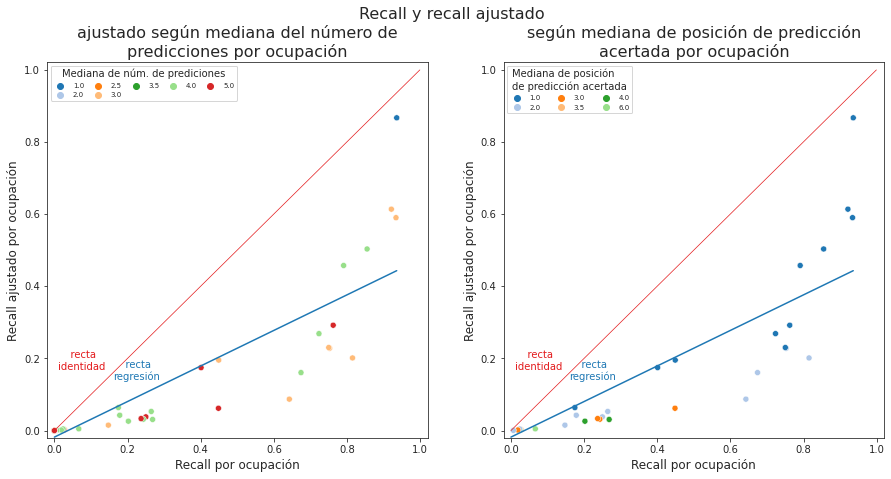

In [165]:
colores=sns.color_palette('Paired')
colores.as_hex()

sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(15,7))
font_titles=16
font_labels=12

x=np.arange(0,1,0.001)

for i,criterio in enumerate(['mediana num pred por cat target','mediana posicion acierto por cat target']):

    ax[i].plot(x,x,color=colores.as_hex()[5],linewidth=0.7) # recta identidad

    sns.regplot(ax=ax[i],data=naive_5_05_evalua_recall_vld,
                x='recall target', 
                y='recall ajustado target',
                ci=None,scatter=False,line_kws={'linewidth':1.5},color=colores.as_hex()[1]) # recta de regresión
    
    sns.scatterplot(ax=ax[i],data=naive_5_05_evalua_recall_vld,
                    x='recall target', 
                    y='recall ajustado target',
                    hue=criterio,
                    palette='tab20',legend=True)
    
    ax[i].set_xlabel('Recall por ocupación',fontsize=font_labels)
    ax[i].set_xlim(-0.02,1.02)
    ax[i].set_ylabel('Recall ajustado por ocupación',fontsize=font_labels)
    ax[i].set_ylim(-0.02,1.02)
  
    ax[i].text(x=0.16,y=0.14,s='    recta\nregresión',color=colores.as_hex()[1])
    ax[i].text(x=0.01,y=0.17,s='    recta\nidentidad',color=colores.as_hex()[5])
    
titulo_0='ajustado según mediana del número de predicciones por ocupación'
ax[0].set_title(textwrap.fill(titulo_0,40),fontsize=font_titles) 
titulo_1='según mediana de posición de predicción acertada por ocupación'
ax[1].set_title(textwrap.fill(titulo_1,45),fontsize=font_titles)

ax[0].legend(title='Mediana de núm. de prediciones',ncol=5,fontsize='x-small',
             title_fontsize='medium',columnspacing=1)
ax[1].legend(title='Mediana de posición\nde predicción acertada',ncol=3,fontsize='x-small',title_fontsize='medium')

fig.suptitle('Recall y recall ajustado',fontsize=16)

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(top=0.87)

plt.show()

### Observaciones: 
 
- El gráfico anterior muestra con claridad que, para los títulos con un recall superior a 0.5, la predicción que con más frecuencia es la acertada es la primera, esto es, la que se ofrece como la más probable. En estos casos, la diferencia entre el recall y el recall ajustado se debe solo al exceso de predicciones. 

 
- A diferencia de las métricas de accuracy, el recall y el recall ajustado de las profesiones sanitarias (las únicas con mediana del número de predicciones unitaria) no son iguales. Esto refleja que, aunque más de la mitad de los títulos para los que se predicen profesiones sanitarias reciben una predicción única, no todos tienen esta característica.  


- Los únicos títulos con recall y recall ajustados iguales (sobre la recta identidad) son aquellos para los que ambas métricas son nulas.

# Metricas de recall: conclusiones

1. El rendimiento desagregado por títulos (accuracy) es superior en promedio al evaluado por ocupaciones (recall)   

- No hay títulos para los que el accuracy sea nulo. Sin embargo, si hay ocupaciones con recall nulo o casi nulo.


- El dataset es una **encuesta sobre titulados universitarios**: el muestreo está diseñado para garantizar una presencia representativa de los títulos universitarios, no de las ocupaciones profesionales. Los puestos de trabajo que no requieren formación universitaria están infrarepresentados respecto a su peso en la población general.  

2. El recall desagregado por ocupaciones tiene una relación fuerte y directa con el **número de profesionales encuestados**, principal variable explicativa de las métricas de accuracy. 


- El peor rendimiento se da, sobre todo, en **ocupaciones que no requieren titulación universitaria**: las ocupaciones con **recall nulo** son profesiones no cualificadas u ocupaciones cuya formación especializada es no universitaria, con las excepciones de los profesionales en política y dirección de la Administración Pública y los profesionales de apoyo en finanzas y matemáticas. 


- Las ocupaciones con recall nulo son, también, las más infrarepresentadas en la encuesta. 
 
 
- El efecto del tamaño de la muestra es más intenso que el del número de predicciones. Esto limita la eficacia de los ajustes en los parámetros del clasificador para mejorar las métricas de recall. 

# 7.3. Metricas de evaluación: precisión

In [166]:
def naive_evalua_rhs(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    evalua=data[[regresor,target]]
    
    total_obs=evalua.shape[0]
    
    # Num. de observaciones para cada categoría del target (numerador pesos de precisiones ponderadas):
    total_obs_por_cat_target=evalua.groupby(target).agg(['count']) # cuenta sobre target observado
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer') 
    evalua.rename(columns={evalua.columns[-1]:'num obs cat target'},inplace=True)
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                         .apply(lambda valor: naive_predice(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                         .apply(lambda valor: naive_predice(clasificador,valor)['probabilidad'].tolist())
    
    # Columna 'suma de prob. de pred. por regresor' (denominador de acierto ajustado por probabilidad):
    # Se hace aquí para eleminar listas del dataframe (interfieren en comparaciones de filas)
    evalua['suma prob pred por regresor']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Núm predicciones:
    evalua['num pred para regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    max_rank=evalua['num pred para regresor'].max()
    
    for i in range(max_rank):
        # Se sacan las predicciones de la lista y se convierten en columnas:  
        evalua['pred'+str(i)]=evalua['prediccion'][evalua['num pred para regresor']>=i+1]\
                             .apply(lambda lista:lista[i])
        # Se sacan las probabilidades de las predicciones de la lista y se convierten en columnas: 
        evalua['p'+str(i)]=evalua['prediccion probs'][evalua['num pred para regresor']>=i+1]\
                          .apply(lambda lista:lista[i])   

    del evalua['prediccion'], evalua['prediccion probs'] # listas interfieren en comparaciones de filas
    
    # Se odenan todas la predicciones para una observacion (previamente en cols) en filas:
    # Para cada obs., una fila por predicción: filas dénticas salvo por el valor de la predicción y su prob. 
    # Las obs. dejan de corresponderse con filas (varias pred. para una obs.)
    # Las predicciones ordenadas en 2 columnas: predicciones del target y prob. de las predicciones
    
    evalua.rename(columns={'pred0':'predicciones target','p0':'predicciones prob'},inplace=True)
    
    for i in range(1,max_rank):
        aux=evalua[evalua.columns.drop(['predicciones target','predicciones prob'])]
        aux.rename(columns={'pred'+str(i):'predicciones target','p'+str(i):'predicciones prob'},inplace=True)     
        # Prescinde de filas con nan por titulaciones con menos predicciones que otras: 
        aux=aux[aux['predicciones target'].notna()]
        del evalua['pred'+str(i)], evalua['p'+str(i)]
        # Merge conservando índices para identificar observaciones distintas (no se corresponden con filas):
        for df in [evalua,aux]:
            df.reset_index(inplace=True)
        evalua=evalua.merge(aux,how='outer')
        evalua.drop_duplicates(inplace=True)
        evalua.set_index('index',inplace=True)
    
    # Para desligar por índice y asignar valores distintos en col. nuevas para misma obs.: 
    evalua.reset_index(drop=False,inplace=True) 
    evalua.sort_values(by='index',inplace=True)
    
    # Aciertos (binaria):
    evalua['acierto']=0
    evalua['acierto'].mask(evalua['predicciones target']==evalua[target],1,inplace=True)
   
    # Probabilidades de las predicciones acertadas:
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]['predicciones prob']
    
    # Núm. de aciertos (binaria) para cada predicción: 
    aciertos_por_prediccion=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['sum'])
    aciertos_por_prediccion.columns=aciertos_por_prediccion.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_prediccion,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred acertadas'},inplace=True)
    
    # Núm. de repeticiones de cada predicción: 
    repeticiones_pred=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['count'])
    repeticiones_pred.columns=repeticiones_pred.columns.to_flat_index()
    evalua=evalua.merge(repeticiones_pred,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred'},inplace=True)

    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob pred por regresor'])

    # Suma aciertos ajustados para cada predicción: 
    suma_aciertos_ajustados=evalua[['predicciones target','acierto ajustado']]\
                                           .groupby('predicciones target').agg(['sum'])
    suma_aciertos_ajustados.columns=suma_aciertos_ajustados.columns.to_flat_index()
    evalua=evalua.merge(suma_aciertos_ajustados,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por pred'},inplace=True)
    
    # Precisión y precisión ajustada por predicción: 
    evalua['precision pred']=evalua['num pred acertadas'].div(evalua['num pred'])
    evalua['precision ajustada pred']=evalua['aciertos ajustados por pred']\
                                          .div(evalua['num pred'])
   
    # Pesos de predicciones = num. obs. de target predicho entre total obs.: 
    pesos_pred=evalua[[target,'num obs cat target']]
    pesos_pred['peso pred']=pesos_pred['num obs cat target']/total_obs
    pesos_pred=pesos_pred[[target,'peso pred']]
    pesos_pred.rename(columns={target:'predicciones target'},inplace=True)
    pesos_pred.drop_duplicates(inplace=True)
    evalua=evalua.merge(pesos_pred,on='predicciones target',how='left')
    evalua['peso pred'].fillna(0,inplace=True) # para predicciones no observadas
    
    # Precisión y precisión ajustada ponderada para cada predicción:    
    evalua['precision ponderada pred']=evalua['precision pred']*evalua['peso pred']
    evalua['precision ajustada ponderada pred']=evalua['precision ajustada pred']*evalua['peso pred']
    
    # Formato:
    evalua.set_index('index',inplace=True)
    evalua.sort_index(inplace=True)
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)

    return evalua

In [167]:
prueba=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_prueba)
#prueba

### Evaluación desagregada (en validación) 

In [168]:
naive_5_05_evalua_rhs_vld=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_vld)

In [169]:
naive_5_05_evalua_rhs_vld.head()

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,"Empleados servicios financieros, contables y de apoyo",0.231985,0,NaN,394,2134,NaN,150.875184,0.184630,0.070701,0.043195,0.007975,0.003054
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,Profesionales del derecho,0.058786,0,NaN,259,1231,NaN,152.403482,0.210398,0.123805,0.025315,0.005326,0.003134
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,Representantes e intermediarios,0.063211,0,NaN,54,1078,NaN,6.945083,0.050093,0.006443,0.022308,0.001117,0.000144
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,"Expertos en gestión, finanzas, comercio, etc",0.158028,0,NaN,393,3643,NaN,93.652880,0.107878,0.025708,0.048709,0.005255,0.001252
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,Empleados administrativos sin atención al público,0.099874,0,NaN,148,2011,NaN,20.412001,0.073595,0.010150,0.027571,0.002029,0.000280


In [170]:
naive_5_05_evalua_rhs_vld['target: ocupacion_'].nunique()
# Núm. de ocupaciones distintas observadas: 

62

## Precisión agregada por predicciones

In [171]:
def naive_evalua_precision(clasificador,data):
    
    """
    
    """
    
    evalua=naive_evalua_rhs(clasificador=clasificador,data=data)
    
    import re
    lista_re_pred=list(filter(lambda col: re.search('.*pred.*',col),evalua.columns))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_pred))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*prob.*)',col),lista_re_pred))
    lista_re_pred=[lista_re_pred[0]]+[lista_re_pred[2]]+[lista_re_pred[1]]+lista_re_pred[3:]
    
    evalua=evalua[lista_re_pred].drop_duplicates()
    
    evalua.set_index('predicciones target',inplace=True)
    evalua.sort_values(by='precision pred',ascending=False,inplace=True)

    return evalua

In [172]:
naive_5_05_precision_vld=naive_evalua_precision(clasificador=naive_5_05_train,data=df_vld)

In [173]:
naive_5_05_precision_vld.shape[0], df_vld['ocupacion_'].nunique() # Comprobación: 
# El núm de ocupaciones predichas es la cuarta parte del núm. de ocupaciones observadas en validación

(35, 62)

In [174]:
naive_5_05_precision_vld

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
predicciones target,,,,,,,,
Profesionales sanitarios,2526,1398,1294.262592,0.553444,0.512376,0.124822,0.069082,0.063956
"Profesionales de las ciencias, matemáticas e ingeniería",4353,1438,908.192595,0.330347,0.208636,0.128666,0.042504,0.026844
Profesionales de la enseñanza,6346,1799,1197.750864,0.283486,0.188741,0.163172,0.046257,0.030797
Profesionales de las ciencias sociales,1661,355,205.301230,0.213727,0.123601,0.037514,0.008018,0.004637
Profesionales del derecho,1231,259,152.403482,0.210398,0.123805,0.025315,0.005326,0.003134
Gerentes hostelería y comercio,5,1,0.071429,0.200000,0.014286,0.003258,0.000652,0.000047
Técnicos TI,1275,252,76.374469,0.197647,0.059902,0.027989,0.005532,0.001677
"Empleados servicios financieros, contables y de apoyo",2134,394,150.875184,0.184630,0.070701,0.043195,0.007975,0.003054
Profesionales IT,1687,288,88.332429,0.170717,0.052361,0.032083,0.005477,0.001680


# 8. Resúmenes de métricas de evaluación 

In [175]:
def naive_evalua_criterio_describe(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de resumen de la evaluación de acuerdo con un 'criterio' 
    que se concretará como accuracy, como recall o como precision.
    """
    if criterio=='accuracy':
        evalua=naive_evalua_accuracy(clasificador=clasificador,data=data)
    if criterio=='recall':
        evalua=naive_evalua_recall(clasificador=clasificador,data=data)
    if criterio=='precision':
        evalua=naive_evalua_precision(clasificador=clasificador,data=data)
    
    evalua_resumen=evalua.agg(['sum','mean','median','min','argmin','max','argmax'])
    
    # Ajustes argmin y argmax: 
    for col in evalua.columns: 
        for arg in ['argmin','argmax']:
            indice=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua.index[indice]

    return evalua_resumen

In [176]:
def naive_evalua_accuracy_describe(clasificador,data):
    
    evalua=naive_evalua_criterio_describe(clasificador=clasificador,data=data,criterio='accuracy')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','accuracy regresor']=''
    evalua.loc['sum','accuracy ajustado regresor']=''
    
    return evalua

In [177]:
def naive_evalua_recall_describe(clasificador,data):
    
    evalua=naive_evalua_criterio_describe(clasificador=clasificador,data=data,criterio='recall')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','recall target']=''
    evalua.loc['sum','recall ajustado target']=''
    
    return evalua

In [178]:
def naive_evalua_precision_describe(clasificador,data):
    
    evalua=naive_evalua_criterio_describe(clasificador=clasificador,data=data,criterio='precision')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','precision pred']=''
    evalua.loc['sum','precision ajustada pred']=''
    
    return evalua

In [179]:
naive_5_05_evalua_accuracy_describe_vld=naive_evalua_accuracy_describe(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_describe_vld

,num pred por regresor,cat target por regresor (train),obs regresor (train),mediana posicion acierto por cat regresor,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
sum,702,3967,35906,265.5,11969,8019,4510.24,,,1,0.669981,0.376826,121.369
mean,4.0578,22.9306,207.549,1.53468,69.185,46.3526,26.0707,0.653276,0.299402,0.00578035,0.00387272,0.00217819,0.701555
median,4,20,92,1,30,21,7.63158,0.666667,0.238462,0.00250648,0.00175453,0.000637612,0.696203
min,1,3,14,1,3,1,0.214286,0.185185,0.046046,0.000250648,8.35492e-05,1.79034e-05,0.40625
argmin,Grado Odontología,Máster Odontología,Máster Hostelería,Grado Odontología,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Geografía,Grado Geografía,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Política y gestión pública
max,10,50,1582,4,541,412,412,1,1,0.0452001,0.0344223,0.0344223,1
argmax,Máster Servicios de transporte,Grado Historia,Grado Administración y empresa,Grado Servicio de transporte terrestre y Servicio de transporte aéreo,Grado Administración y empresa,Grado Enfermería,Grado Enfermería,Grado Odontología,Grado Odontología,Grado Administración y empresa,Grado Enfermería,Grado Enfermería,Máster Religión y teología


In [180]:
naive_5_05_evalua_recall_describe_vld=naive_evalua_recall_describe(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_describe_vld

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target,mediana posicion acierto por cat target,mediana num pred por cat target
sum,11969,8019,4510.24,,,1,0.669981,0.376826,66.5,229
mean,193.048,129.339,72.7457,0.209503,0.0851357,0.016129,0.0108061,0.00607785,2.21667,3.69355
median,38.5,0,0,0,0,0.00321664,0,0,2,4
min,2,0,0,0,0,0.000167098,0,0,1,1
argmin,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,Profesionales sanitarios,Profesionales sanitarios
max,1953,1799,1294.26,0.935743,0.866307,0.163172,0.150305,0.108135,6,5
argmax,Profesionales de la enseñanza,Profesionales de la enseñanza,Profesionales sanitarios,Profesionales sanitarios,Profesionales sanitarios,Profesionales de la enseñanza,Profesionales de la enseñanza,Profesionales sanitarios,"Trabajadores ind alimentación, bebidas y tabaco","Empleados servicios financieros, contables y de apoyo"


In [181]:
naive_5_05_evalua_precision_describe_vld=naive_evalua_precision_describe(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_precision_describe_vld
# suma pesos pred != 1 : pesos de predicciones imputados por pesos observaciones

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
sum,40529,8019,4510.24,,,0.962152,0.223981,0.144467
mean,1157.97,229.114,128.864,0.115935,0.0511079,0.0274901,0.00639947,0.00412762
median,582,54,7.89235,0.0817791,0.0110874,0.0172947,0.00126304,0.000176449
min,3,0,0,0,0,0.000167098,0,0
argmin,Política y dirección Admón Pública,"Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas"
max,6346,1799,1294.26,0.553444,0.512376,0.163172,0.0690823,0.0639561
argmax,Profesionales de la enseñanza,Profesionales de la enseñanza,Profesionales sanitarios,Profesionales sanitarios,Profesionales sanitarios,Profesionales de la enseñanza,Profesionales sanitarios,Profesionales sanitarios


# 8. Evaluación: agregados 

In [182]:
def naive_evalua_regresor(clasificador,data):
    
    """Resume las métricas relacionadas con el accuracy para cada categoría del regresor a partir del clasificador
    entrenado y el set de datos de evaluación. 
    """
    
    import re
    
    resumen=naive_evalua_accuracy(clasificador=clasificador,data=data)
    lista_re_accuracy_1=list(filter(lambda col: re.search('.*accuracy.*',col),resumen.columns))
    lista_re_accuracy_2=list(filter(lambda col: re.search('.*peso.*',col),resumen.columns))
    resumen=resumen[lista_re_accuracy_1+lista_re_accuracy_2]
    resumen.index.rename('regresor',inplace=True)

    # Formato: 
    columnas=[resumen.columns[-1]]+resumen.columns[:-1].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by='accuracy',ascending=False,inplace=True)

    return resumen

In [183]:
naive_5_05_regresor=naive_evalua_regresor(clasificador=naive_5_05_train,data=df_vld)

In [184]:
naive_5_05_regresor.sum()

peso                             1.000000
accuracy                       113.016677
accuracy ajustado               51.796596
accuracy ponderado               0.669981
accuracy ajustado ponderado      0.376826
dtype: float64

In [185]:
naive_5_05_regresor.head()

,peso,accuracy,accuracy ajustado,accuracy ponderado,accuracy ajustado ponderado
regresor,,,,,
Grado Odontología,0.003760,1.000000,1.000000,0.003760,0.003760
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",0.000585,1.000000,0.258929,0.000585,0.000151
Grado Literatura,0.000835,1.000000,0.460714,0.000835,0.000385
Grado Medicina,0.024480,0.986348,0.986348,0.024146,0.024146
Máster Música y artes del espectáculo,0.001922,0.956522,0.470531,0.001838,0.000904


In [186]:
def naive_evalua_target(clasificador,data):
    
    """Resume las métricas relacionadas con la precisión y el recall para cada categoría del target a partir 
    del clasificador entrenado y el set de datos de evaluación. 
    """
    
    import re
    
    resumen_precision=naive_evalua_precision(clasificador=clasificador,data=data)
    lista_re_precision=list(filter(lambda col: re.search('.*precision.*',col),resumen_precision.columns))
    resumen_precision=resumen_precision[lista_re_precision]
    resumen_precision.index.rename('target',inplace=True)
    
    resumen_recall=naive_evalua_recall(clasificador=clasificador,data=data)
    lista_re_recall_1=list(filter(lambda col: re.search('.*recall.*',col),resumen_recall.columns))
    lista_re_recall_2=list(filter(lambda col: re.search('.*num.*',col),resumen_recall.columns)) 
    lista_re_recall_3=list(filter(lambda col: re.search('.*peso.*',col),resumen_recall.columns))
    resumen_recall=resumen_recall[lista_re_recall_1+lista_re_recall_2+lista_re_recall_3]
    resumen_recall.index.rename('target',inplace=True)
    
    resumen=resumen_precision.merge(resumen_recall,left_index=True,right_index=True,how='outer')

    # Formato: 
    columnas=resumen.columns[-3:].tolist()+resumen.columns[:-3].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    dicc_col=dict(zip(dicc_col.keys(),list(map(lambda col: col.split('por')[0],dicc_col.values()))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by=['num obs','precision','recall'],ascending=False,inplace=True)
    
    resumen['indice f1']=2*resumen['precision']*resumen['recall']/(resumen['precision']+resumen['recall'])
    resumen['indice f1 ajustado']=2*resumen['precision ajustada']*resumen['recall ajustado']\
                                  /(resumen['precision ajustada']+resumen['recall ajustado'])
    resumen['indice f1 ponderado']=resumen['indice f1']*resumen['peso']
    resumen['indice f1 ajustado ponderado']=resumen['indice f1 ajustado']*resumen['peso']

    return resumen

In [187]:
prueba=naive_evalua_target(clasificador=naive_5_05_train,data=df_prueba)
prueba

,num aciertos,mediana num pred,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,num obs,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,,
Prof derecho,0.0,4.0,0.6,NaN,NaN,NaN,NaN,0.0,0.000000,0.0,0.0000,3.0,NaN,NaN,NaN,NaN
"Empleados servicios financieros, contables y de apoyo",1.0,4.0,0.2,0.25,0.031501,0.05,0.0063,1.0,0.126002,0.2,0.0252,1.0,0.4,0.050401,0.08,0.01008
Prof sanitarios,0.0,1.0,0.2,NaN,NaN,NaN,NaN,0.0,0.000000,0.0,0.0000,1.0,NaN,NaN,NaN,NaN
Empleados administrativos sin atención al público,NaN,NaN,NaN,0.00,0.000000,0.00,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Expertos en gestión, finanzas, comercio, etc",NaN,NaN,NaN,0.00,0.000000,0.00,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profesionales del derecho,NaN,NaN,NaN,0.00,0.000000,0.00,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profesionales sanitarios,NaN,NaN,NaN,0.00,0.000000,0.00,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Representantes e intermediarios,NaN,NaN,NaN,0.00,0.000000,0.00,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
naive_5_05_target=naive_evalua_target(clasificador=naive_5_05_train,data=df_vld)

In [189]:
naive_5_05_target.sum()

num aciertos                     8019.000000
mediana num pred                  229.000000
peso                                1.000000
precision                           4.057731
precision ajustada                  1.788777
precision ponderada                 0.223981
precision ajustada ponderada        0.144467
recall                             12.989166
recall ajustado                     5.278416
recall ponderado                    0.669981
recall ajustado ponderado           0.376826
num obs                         11969.000000
indice f1                           5.756037
indice f1 ajustado                  2.568036
indice f1 ponderado                 0.324613
indice f1 ajustado ponderado        0.203177
dtype: float64

In [190]:
naive_5_05_target.head()

,num aciertos,mediana num pred,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,num obs,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,,
Profesionales de la enseñanza,1799,3.0,0.163172,0.283486,0.188741,0.046257,0.030797,0.921147,0.613288,0.150305,0.100071,1953,0.433546,0.288649,0.070742,0.047099
"Profesionales de las ciencias, matemáticas e ingeniería",1438,3.0,0.128666,0.330347,0.208636,0.042504,0.026844,0.933766,0.589735,0.120144,0.075879,1540,0.488037,0.308228,0.062794,0.039658
Profesionales sanitarios,1398,1.0,0.124822,0.553444,0.512376,0.069082,0.063956,0.935743,0.866307,0.116802,0.108135,1494,0.695522,0.643912,0.086817,0.080375
"Expertos en gestión, finanzas, comercio, etc",393,4.0,0.048709,0.107878,0.025708,0.005255,0.001252,0.674099,0.160640,0.032835,0.007825,583,0.185991,0.044322,0.009059,0.002159
"Empleados servicios financieros, contables y de apoyo",394,5.0,0.043195,0.184630,0.070701,0.007975,0.003054,0.762089,0.291828,0.032918,0.012605,517,0.297246,0.113825,0.012840,0.004917


In [191]:
def naive_evalua_resumen(clasificador, data, nombre='naive'):
    
    resumen=naive_evalua_target(clasificador=clasificador, data=data)
    resumen=resumen[['precision ponderada', 'precision ajustada ponderada','recall ponderado',
                   'recall ajustado ponderado','indice f1 ponderado','indice f1 ajustado ponderado']]
    dicc_col=dict(zip(resumen.columns,map(lambda col: col.rsplit(' ',1)[0],resumen.columns)))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.rename(columns={'recall':'recall (o accuracy)'},inplace=True)
    
    resumen=pd.DataFrame(resumen.sum())
    resumen.rename(columns={resumen.columns[0]:str(nombre)},inplace=True)
    resumen.index.rename('medias ponderadas',inplace=True)
    
    return resumen

In [192]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,naive
medias ponderadas,
precision,0.05000
precision ajustada,0.00630
recall (o accuracy),0.20000
recall ajustado,0.02520
indice f1,0.08000
indice f1 ajustado,0.01008


In [193]:
naive_5_05_resumen=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_vld)

In [194]:
naive_5_05_resumen

,naive
medias ponderadas,
precision,0.223981
precision ajustada,0.144467
recall (o accuracy),0.669981
recall ajustado,0.376826
indice f1,0.324613
indice f1 ajustado,0.203177


In [195]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)

In [196]:
def naive_compara(lista_clasificadores,lista_data):
    
    m=len(lista_clasificadores)
    if type(lista_data)!=list: 
        lista_data=[lista_data]*m
    resumen=naive_evalua_resumen(clasificador=lista_clasificadores[0], data=lista_data[0])
    #resumen.rename
    for i in range(1,m):
        evalua=naive_evalua_resumen(clasificador=lista_clasificadores[i], data=lista_data[i])
        resumen=pd.concat([resumen,evalua],axis=1)
        
    return resumen

In [198]:
prueba=naive_compara([naive_5_05_train,naive_5_05_train],[df_prueba, df_prueba.sample(3)])
prueba

,naive,naive
medias ponderadas,,
precision,0.05000,0.111111
precision ajustada,0.00630,0.014000
recall (o accuracy),0.20000,0.333333
recall ajustado,0.02520,0.042001
indice f1,0.08000,0.166667
indice f1 ajustado,0.01008,0.021000
